<a href="https://colab.research.google.com/github/Olivia-Feldman/NUGAN-DISTGAN/blob/Andrew-S/AML_GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
from math import floor
import time

# Investigating and visualizing Mode Collapse in the MNIST dataset 

#What is mode collpase? 

mode collapse occurs when the generator is only generating a small  diversity of modes(digits).


#Why can it occur? 

 The generator learns to map several different input z values to the same output point. 

#How to identify mode collapse? 

Mode collapse can be identified by reviewing a large samples of generated images and looking for common signs of mode collapse:

   - low diversity of digits (reapting images of ones ) 

Looking at a line plot of the model loss in the generator: 
    - As the generator model is updated the loss should oscillate between different modes. 
    
#MNIST Dataset 
To visualize mode collapse in the MNIST dataset we will compare generated images from a gan model using a latent variable of 100 and a gan model using a latnet variable of 1. This is to restrict the size of the latent dimension to force the model to generate a small diversity of images. 
  

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Loading in the MNIST dataset


In [ ]:
# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
print(train_dataset.data.shape)

torch.Size([60000, 28, 28])


In [ ]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [ ]:
def visualize_results(gan):
      sample_z_ = torch.rand((10, gan.z_dim)).cuda()
      samples = gan.G(sample_z_)
      samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
      samples = (samples + 1) / 2
      plt.figure(figsize=((1,10)))
      fig,ax = plt.subplots(1,10)
      for i in range(10):
        s=ax[i].imshow(np.squeeze(samples[i,]))
        s=ax[i].get_xaxis().set_visible(False)
        s=ax[i].get_yaxis().set_visible(False)
      s=plt.show()

In [ ]:
class Net(nn.Module):
    def __init__(self, input_dim=1, output_dim=10, input_size=28, base_size=64):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.base_size = base_size
        # self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # self.conv2 = nn.Conv2d(16, 128, kernel_size=3, stride=1, padding=1)
        # self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        # self.fc1 = nn.Linear(128 * 8 * 8, 512)
        # self.fc2 = nn.Linear(512, 128)
        # self.fc3 = nn.Linear(128, 10)

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.base_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.base_size, 2*self.base_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(2*self.base_size),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.ReLU(),
        )

        #initialize_weights(self)

    def forward(self, x):
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = F.relu(self.conv3(x))
        # x = x.view(-1, 128 * 8 * 8)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        x = self.conv(x)
        x = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)
        return x

In [ ]:
def inception_score(gan, n_split=10, eps=1E-16):

      num_images = 100
      sample_z_ = torch.rand((num_images, gan.z_dim)).cuda()
      #print(sample_z_.shape)
      samples = gan.G(sample_z_)
      #print(samples.shape)

      samples_np = samples.cpu().data.numpy()

      # enumerate splits of images/predictions
      scores = list()
      n_part = floor(num_images / n_split)

      for i in range(n_part):
          # retrieve subset of images
          ix_start, ix_end = i * n_part, (i+1) * n_part
          subset = samples_np[ix_start:ix_end]
          # convert from uint8 to float32
          subset = subset.astype('float32')
          # predict p(y|x)
          outputs = classifier.net(torch.from_numpy(subset).cuda())
          #print("outputs: ", outputs.shape)
          #print("\n\t", outputs)
          outputs = F.softmax(outputs, dim=1)
          #print("\tSoftmax: ", outputs)
          
          # y, p_yx = torch.max(outputs.data, 1)
          # print("p_yx: ", p_yx.shape)
          # print("\t", p_yx)
          #print(y.shape)
          p_yx_d = gan.D(torch.from_numpy(subset).cuda())
          #print("\tD: ", p_yx_d.shape)
          #print(p_yx.shape)
          #print(p_yx)
          p_yx = outputs.cpu().data.numpy()
          #print("p_yx numpy:\n\t", p_yx)
          #p_yx = np.expand_dims(p_yx, 0)
          #print(p_yx.shape)
          #print("p_yx expanded", p_yx)
          # calculate p(y)
          p_y = np.expand_dims(p_yx.mean(axis=0), 0)
          #print("p_y:\n\t", p_y)
          # calculate KL divergence using log probabilities
          kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
          #print("kl_d:\n\t", kl_d)
          # sum over classes
          sum_kl_d = kl_d.sum(axis=1)
          #print("sum_kl_d:\n\t", sum_kl_d)
          # average over images
          avg_kl_d = np.mean(sum_kl_d)
          #print("avg_kl_d:\n\t", avg_kl_d)
          # undo the log
          is_score = np.exp(avg_kl_d)
          #print("is_score:\n\t", is_score)
          #print('\n\n')
		      # store
          scores.append(is_score)
        
      # average across images
      is_avg, is_std = np.mean(scores), np.std(scores)
      print("avg_is_score:\t", is_avg)
      print("std_is_score:\t", is_std)
     
      return is_avg, is_std

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, input_size=28, base_size=128):
        super(Generator, self).__init__()  
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = 28
        self.base_size = base_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(2*self.base_size, self.base_size, 4, 2, 1),
            nn.BatchNorm2d(self.base_size),
            nn.ReLU(),
            nn.ConvTranspose2d(self.base_size, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )

        initialize_weights(self)           
    
    # forward method
    def forward(self, x): 
       # x = x.view(-1, self.input_size * self.input_size)
        x = self.fc(x)
        x = x.view(-1, 2*self.base_size, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)
        return x



class Discriminator(nn.Module):
  def __init__(self, input_dim, output_dim, input_size=28, base_size=128):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.base_size = base_size


        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.base_size, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.base_size, 2*self.base_size, 4, 2, 1),
            nn.BatchNorm2d(2*self.base_size),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(2*self.base_size * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )

        initialize_weights(self)

     # forward method
  def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)

        return x

Mounted at /content/drive
Epoch:  0  train loss:  0.214
Epoch:  0  validation loss:  0.081
Epoch:  1  train loss:  0.060
Epoch:  1  validation loss:  0.059
Epoch:  2  train loss:  0.039
Epoch:  2  validation loss:  0.053
Epoch:  3  train loss:  0.028
Epoch:  3  validation loss:  0.051
Epoch:  4  train loss:  0.020
Epoch:  4  validation loss:  0.047
Epoch:  5  train loss:  0.012
Epoch:  5  validation loss:  0.049
Epoch:  6  train loss:  0.010
Epoch:  6  validation loss:  0.044
Epoch:  7  train loss:  0.006
Epoch:  7  validation loss:  0.048
Epoch:  8  train loss:  0.006
Epoch:  8  validation loss:  0.045
Epoch:  9  train loss:  0.005
Epoch:  9  validation loss:  0.049
Epoch:  10  train loss:  0.004
Epoch:  10  validation loss:  0.049
Epoch:  11  train loss:  0.004
Epoch:  11  validation loss:  0.054
Epoch:  12  train loss:  0.007
Epoch:  12  validation loss:  0.055
Epoch:  13  train loss:  0.010
Epoch:  13  validation loss:  0.070
Epoch:  14  train loss:  0.013
Epoch:  14  validation lo

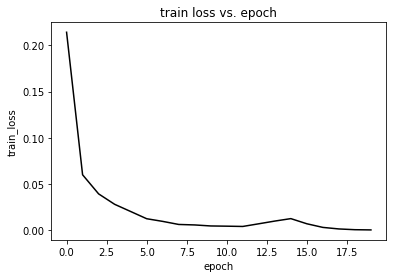

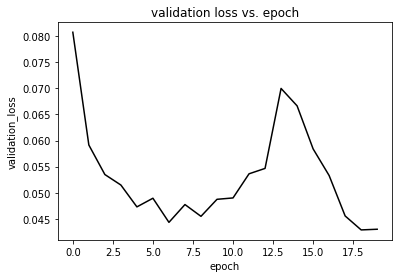

Accuracy of the network on the 10000 test images: 98.930 %


In [ ]:
class Classifier():
    def __init__(self, epoch=20, batch_size=500):

        self.epoch_range = epoch
        self.batch_size = batch_size
        valid_ratio = 0.3

        nb_train = int((1.0 - valid_ratio) * len(train_dataset))
        nb_valid =  int(valid_ratio * len(train_dataset))
        train_split_dataset, valid_split_dataset = torch.utils.data.dataset.random_split(train_dataset, [nb_train, nb_valid])

        self.trainloader = torch.utils.data.DataLoader(train_split_dataset, batch_size=self.batch_size,
                                          shuffle=True)
        self.validloader = torch.utils.data.DataLoader(valid_split_dataset, batch_size=self.batch_size,
                                          shuffle=True)
        self.testloader = torch.utils.data.DataLoader(test_dataset, 
                                        batch_size=self.batch_size, 
                                        shuffle=False,
                                        num_workers=1)

        self.net = Net().cuda()

        self.criterion = nn.CrossEntropyLoss().cuda()

        self.optimizer = optim.Adam(self.net.parameters(), lr=0.00146)

        from google.colab import drive
        drive.mount('/content/drive')
        self.PATH = 'cifar10_net_test_3.pth'

#-------------------------------------------------------------------------------

    def train(self):

          self.training_loss = []
          self.validation_loss = []

          start_time = time.time()
          best_loss = np.float('inf')
          for epoch in range(self.epoch_range): 

              running_loss = 0.0
              for i, data in enumerate(self.trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                # inputs, labels = data[0].to(device), data[1].to(device)
                 inputs, labels = data[0].cuda(), data[1].cuda()

                # zero the parameter gradients
                 self.optimizer.zero_grad()

                # forward + backward + optimize
                 outputs = self.net(inputs)
                 loss = self.criterion(outputs, labels)
                 loss.backward()
                 self.optimizer.step()

                # print statistics
                 running_loss += loss.item()

              epoch_loss = running_loss / (i+1)
              self.training_loss.append(epoch_loss)
              print("Epoch: ", epoch, " train loss: ", '%.3f' % epoch_loss)

            #---------------------------------

              with torch.no_grad(): 
                  running_loss = 0.0

                  for i, data in enumerate(self.validloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    #inputs, labels = data[0].to(device), data[1].to(device)
                      inputs, labels = data[0].cuda(), data[1].cuda()

                    # forward 
                      outputs = self.net(inputs)
                      loss = self.criterion(outputs, labels)

                    # print statistics
                      running_loss += loss.item()


                  epoch_loss = running_loss / (i+1)
                  self.validation_loss.append(epoch_loss)
                  print("Epoch: ", epoch, " validation loss: ", '%.3f' % epoch_loss)

                # save the best model based on validation loss
                  if epoch_loss < best_loss:
                      torch.save(self.net.state_dict(), self.PATH)
                      best_loss = epoch_loss

          time_elap = (time.time() - start_time) // 60
          print('Finished Training in %d mins' % time_elap)

          plt.plot(range(self.epoch_range), self.training_loss, 'k-')
          plt.title('train loss vs. epoch')
          plt.xlabel('epoch')
          plt.ylabel('train_loss')
          plt.show()

          plt.plot(range(self.epoch_range), self.validation_loss, 'k-')
          plt.title('validation loss vs. epoch')
          plt.xlabel('epoch')
          plt.ylabel('validation_loss')
          plt.show()

#-------------------------------------------------------------------------------

    def test_accuracy(self):

        correct = 0
        total = 0

        with torch.no_grad():
            for data in self.testloader:
                images, labels = data
                outputs = self.net(images.cuda())
                #print("Outputs shape:", outputs.shape)
                _, predicted = torch.max(outputs.data, 1)
                #print("predicted:", predicted.shape)
                total += labels.size(0)
                correct += (predicted == labels.cuda()).sum().item()

        print('Accuracy of the network on the 10000 test images: %.3F %%' % (
            100 * correct / total))



classifier = Classifier()
classifier.train()

classifier.test_accuracy()

#Building a GAN model 

In [ ]:
import matplotlib.gridspec as gridspec
class GAN():
    def __init__(self,params):
        # parameters
        self.epoch = params['max_epochs']
        self.sample_num = 100
        self.batch_size = 128
        self.input_size = 28
        self.z_dim = params['z_dim']
        self.base_size = params['base_size']

        # load dataset
        self.data_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=self.batch_size, 
                                               shuffle=True)
        data = self.data_loader.__iter__().__next__()[0]



        # initialization of the generator and discriminator
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size,base_size=self.base_size).cuda()
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size,base_size=self.base_size).cuda()
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        
        # initialization of the loss function
        #self.BCE_loss = nn.SmoothL1Loss(beta=0.9)
        self.BCE_loss = nn.BCELoss().cuda()
        self.BCE_loss = nn.MSELoss()
        
        # Gettng a batch of noise to generate the fake data
        self.sample_z_ = torch.rand((self.batch_size, self.z_dim)).cuda()
        
# Fucntion to train the GAN, where you alternate between the training of the genenator and discriminator
#--------------------------------------------------------------------------------------------------------

    def train(self):

       # Setting empty arrays for storing the losses

        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []
        self.train_hist['IS_score'] = []

        # Setting up the labels for real and fake images
        self.y_real_, self.y_fake_ = torch.ones(self.batch_size,1).fill_(0.9).type(torch.float32).cuda(), torch.zeros(self.batch_size, 1).cuda()
        
        print('training start!!')

        # Epoch loops

        for epoch in range(self.epoch):
            epoch_start_time = time.time()


            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                # Generate random noise to push through the generator   

                z_ = torch.rand((self.batch_size, self.z_dim))
                x_, z_ = x_.cuda(), z_.cuda()
               #x_ = x_.view(x_.size(0),-1)
                #z_ = z_.view(z_.size(0),-1)
                

         

                # update D network using 
                # 1. Set optimizer gradient to zero
                self.D_optimizer.zero_grad()
                
                D_real = self.D(x_)

                
                D_real_loss = self.BCE_loss(D_real, self.y_real_ )
                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)

                D_loss = D_real_loss + D_fake_loss
                # 3. Do back propagation to compute gradients
                D_loss.backward()
                # 4. Make a step of D_optimizer
                self.D_optimizer.step()

                # 5. Set the current loss in self.train_hist['D_loss]
                self.train_hist['D_loss'].append(D_loss.item())
                
                # update G network using 
                # 1. Set optimizer gradient to zero
                self.G_optimizer.zero_grad()
                # 2. Set generator losses on fake data
                G_ = self.G(z_)
                D_fake = self.D(G_)
                G_loss = self.BCE_loss(D_fake, self.y_real_)
                # 3. Do back propagation to compute gradients
                G_loss.backward()
                # 4. Make a step of G_optimizer
                self.G_optimizer.step()
                # 5. Set the current loss in self.train_hist['G_loss]    
                self.train_hist['G_loss'].append(G_loss.item())

                # Print iterations and losses

                if ((iter + 1) % 100) == 0:
                  print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))

            # Visualize results
            with torch.no_grad():
              visualize_results(self)

            if ((epoch+1) % 10) == 0:  
              print('Generator Reconstruction Images')
              visualise_output(self)

            is_avg, _ = inception_score(self)
            self.train_hist['IS_score'].append(is_avg)
       # digit_frequency(self)
        

        print("Training finished!")

In [ ]:
import matplotlib.pyplot as plt
plt.ion()
import torchvision.utils

def visualise_output(gan):

    with torch.no_grad():
        sample_z_ = torch.rand((gan.base_size, gan.z_dim)).cuda()
        samples = gan.G(sample_z_)
        samples = samples.cpu()
        samples = (samples + 1) / 2
        np_imagegrid = torchvision.utils.make_grid(samples[1:100], 10, 5).detach().numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

def digit_frequency(gan): 
  with torch.no_grad():
    z = torch.rand((gan.base_size, gan.z_dim)).cuda()
    z = gan.G(z)
    z = z.cpu()
    unique, counts = np.unique(z, return_counts=True)
    plt.bar(unique, counts)
    plt.xticks(unique)
    plt.xlabel("Label")
    plt.ylabel("Quantity")
    plt.title("Labels in MNIST 784 dataset")
  


  



# Training Gan with a latent dimension of 100

100 LATENT DIMENIONS
training start!!
Epoch: [ 1] [ 100/ 468] D_loss: 0.35914481, G_loss: 0.49323767
Epoch: [ 1] [ 200/ 468] D_loss: 0.26483178, G_loss: 0.54626155
Epoch: [ 1] [ 300/ 468] D_loss: 0.27963489, G_loss: 0.49973759
Epoch: [ 1] [ 400/ 468] D_loss: 0.34328330, G_loss: 0.39577866


<Figure size 72x720 with 0 Axes>

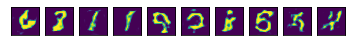

avg_is_score:	 6.432721
std_is_score:	 1.0489786
Epoch: [ 2] [ 100/ 468] D_loss: 0.26273382, G_loss: 0.49377379
Epoch: [ 2] [ 200/ 468] D_loss: 0.22934388, G_loss: 0.49731228
Epoch: [ 2] [ 300/ 468] D_loss: 0.25410461, G_loss: 0.48061275
Epoch: [ 2] [ 400/ 468] D_loss: 0.24404013, G_loss: 0.46254224


<Figure size 72x720 with 0 Axes>

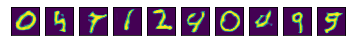

avg_is_score:	 5.996852
std_is_score:	 0.94196737
Epoch: [ 3] [ 100/ 468] D_loss: 0.23480022, G_loss: 0.52728587
Epoch: [ 3] [ 200/ 468] D_loss: 0.26457012, G_loss: 0.49709564
Epoch: [ 3] [ 300/ 468] D_loss: 0.23111075, G_loss: 0.56135440
Epoch: [ 3] [ 400/ 468] D_loss: 0.23982717, G_loss: 0.52143955


<Figure size 72x720 with 0 Axes>

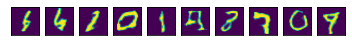

avg_is_score:	 6.3149304
std_is_score:	 0.76999
Epoch: [ 4] [ 100/ 468] D_loss: 0.18907216, G_loss: 0.50833565
Epoch: [ 4] [ 200/ 468] D_loss: 0.23114884, G_loss: 0.50655615
Epoch: [ 4] [ 300/ 468] D_loss: 0.24891031, G_loss: 0.49175876
Epoch: [ 4] [ 400/ 468] D_loss: 0.25798002, G_loss: 0.42917576


<Figure size 72x720 with 0 Axes>

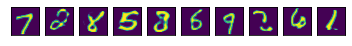

avg_is_score:	 6.45874
std_is_score:	 0.7438793
Epoch: [ 5] [ 100/ 468] D_loss: 0.24935976, G_loss: 0.44701338
Epoch: [ 5] [ 200/ 468] D_loss: 0.31276000, G_loss: 0.58057880
Epoch: [ 5] [ 300/ 468] D_loss: 0.28662038, G_loss: 0.47316593
Epoch: [ 5] [ 400/ 468] D_loss: 0.24912748, G_loss: 0.44362879


<Figure size 72x720 with 0 Axes>

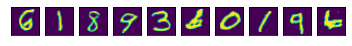

avg_is_score:	 6.451551
std_is_score:	 0.6126185
Epoch: [ 6] [ 100/ 468] D_loss: 0.25177851, G_loss: 0.56672043
Epoch: [ 6] [ 200/ 468] D_loss: 0.29893422, G_loss: 0.43887624
Epoch: [ 6] [ 300/ 468] D_loss: 0.26071459, G_loss: 0.43452156
Epoch: [ 6] [ 400/ 468] D_loss: 0.24342062, G_loss: 0.53226304


<Figure size 72x720 with 0 Axes>

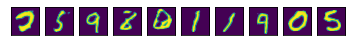

avg_is_score:	 6.8968225
std_is_score:	 0.58256197
Epoch: [ 7] [ 100/ 468] D_loss: 0.18375953, G_loss: 0.46842164
Epoch: [ 7] [ 200/ 468] D_loss: 0.22401181, G_loss: 0.56376708
Epoch: [ 7] [ 300/ 468] D_loss: 0.30924132, G_loss: 0.52911699
Epoch: [ 7] [ 400/ 468] D_loss: 0.27251279, G_loss: 0.47748011


<Figure size 72x720 with 0 Axes>

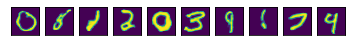

avg_is_score:	 5.5896606
std_is_score:	 0.59981227
Epoch: [ 8] [ 100/ 468] D_loss: 0.25902599, G_loss: 0.56936604
Epoch: [ 8] [ 200/ 468] D_loss: 0.16836637, G_loss: 0.51183403
Epoch: [ 8] [ 300/ 468] D_loss: 0.19126451, G_loss: 0.60997975
Epoch: [ 8] [ 400/ 468] D_loss: 0.20546365, G_loss: 0.57122523


<Figure size 72x720 with 0 Axes>

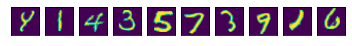

avg_is_score:	 6.279376
std_is_score:	 0.8740046
Epoch: [ 9] [ 100/ 468] D_loss: 0.23193383, G_loss: 0.62572157
Epoch: [ 9] [ 200/ 468] D_loss: 0.23525110, G_loss: 0.55185521
Epoch: [ 9] [ 300/ 468] D_loss: 0.30218428, G_loss: 0.59600890
Epoch: [ 9] [ 400/ 468] D_loss: 0.31687379, G_loss: 0.47763523


<Figure size 72x720 with 0 Axes>

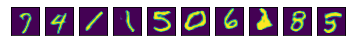

avg_is_score:	 6.15651
std_is_score:	 0.41061097
Epoch: [10] [ 100/ 468] D_loss: 0.22408341, G_loss: 0.54419726
Epoch: [10] [ 200/ 468] D_loss: 0.23626229, G_loss: 0.51600778
Epoch: [10] [ 300/ 468] D_loss: 0.18896012, G_loss: 0.50928622
Epoch: [10] [ 400/ 468] D_loss: 0.20045915, G_loss: 0.45978069


<Figure size 72x720 with 0 Axes>

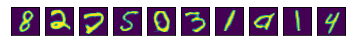

Generator Reconstruction Images


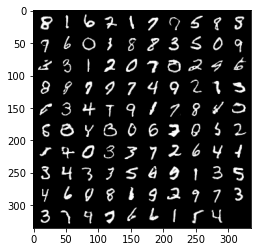

avg_is_score:	 6.287118
std_is_score:	 0.9535513
Epoch: [11] [ 100/ 468] D_loss: 0.35948670, G_loss: 0.38779444
Epoch: [11] [ 200/ 468] D_loss: 0.20214380, G_loss: 0.58559686
Epoch: [11] [ 300/ 468] D_loss: 0.20906270, G_loss: 0.62218899
Epoch: [11] [ 400/ 468] D_loss: 0.26276830, G_loss: 0.53289455


<Figure size 72x720 with 0 Axes>

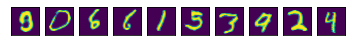

avg_is_score:	 6.1907554
std_is_score:	 0.92076886
Epoch: [12] [ 100/ 468] D_loss: 0.26655999, G_loss: 0.53766787
Epoch: [12] [ 200/ 468] D_loss: 0.21425043, G_loss: 0.64796495
Epoch: [12] [ 300/ 468] D_loss: 0.20314559, G_loss: 0.53548467
Epoch: [12] [ 400/ 468] D_loss: 0.21819821, G_loss: 0.52056837


<Figure size 72x720 with 0 Axes>

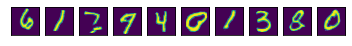

avg_is_score:	 6.2796535
std_is_score:	 0.9259756
Epoch: [13] [ 100/ 468] D_loss: 0.23939601, G_loss: 0.48046803
Epoch: [13] [ 200/ 468] D_loss: 0.20020980, G_loss: 0.42667478
Epoch: [13] [ 300/ 468] D_loss: 0.19028655, G_loss: 0.65425557
Epoch: [13] [ 400/ 468] D_loss: 0.16127165, G_loss: 0.63648689


<Figure size 72x720 with 0 Axes>

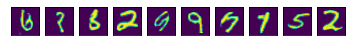

avg_is_score:	 6.076831
std_is_score:	 0.7774754
Epoch: [14] [ 100/ 468] D_loss: 0.14384811, G_loss: 0.60205913
Epoch: [14] [ 200/ 468] D_loss: 0.18187353, G_loss: 0.58208561
Epoch: [14] [ 300/ 468] D_loss: 0.25447425, G_loss: 0.41421393
Epoch: [14] [ 400/ 468] D_loss: 0.25765866, G_loss: 0.64048988


<Figure size 72x720 with 0 Axes>

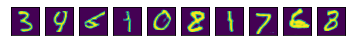

avg_is_score:	 6.382759
std_is_score:	 0.83687437
Epoch: [15] [ 100/ 468] D_loss: 0.18706423, G_loss: 0.65178955
Epoch: [15] [ 200/ 468] D_loss: 0.27018684, G_loss: 0.41354519
Epoch: [15] [ 300/ 468] D_loss: 0.20389545, G_loss: 0.45845601
Epoch: [15] [ 400/ 468] D_loss: 0.14681056, G_loss: 0.59910750


<Figure size 72x720 with 0 Axes>

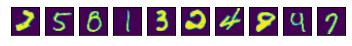

avg_is_score:	 6.463642
std_is_score:	 0.66455007
Epoch: [16] [ 100/ 468] D_loss: 0.20821802, G_loss: 0.56347585
Epoch: [16] [ 200/ 468] D_loss: 0.29852286, G_loss: 0.54356194
Epoch: [16] [ 300/ 468] D_loss: 0.16867009, G_loss: 0.71794176
Epoch: [16] [ 400/ 468] D_loss: 0.13759616, G_loss: 0.62185609


<Figure size 72x720 with 0 Axes>

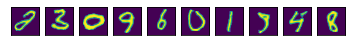

avg_is_score:	 6.2327614
std_is_score:	 0.59045255
Epoch: [17] [ 100/ 468] D_loss: 0.28121537, G_loss: 0.63273406
Epoch: [17] [ 200/ 468] D_loss: 0.13307123, G_loss: 0.61285329
Epoch: [17] [ 300/ 468] D_loss: 0.14929545, G_loss: 0.53444797
Epoch: [17] [ 400/ 468] D_loss: 0.16961898, G_loss: 0.42517495


<Figure size 72x720 with 0 Axes>

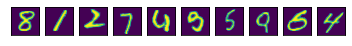

avg_is_score:	 6.290059
std_is_score:	 0.5347959
Epoch: [18] [ 100/ 468] D_loss: 0.20729552, G_loss: 0.59608924
Epoch: [18] [ 200/ 468] D_loss: 0.16506338, G_loss: 0.54177427
Epoch: [18] [ 300/ 468] D_loss: 0.21316174, G_loss: 0.72892147
Epoch: [18] [ 400/ 468] D_loss: 0.27951133, G_loss: 0.56996596


<Figure size 72x720 with 0 Axes>

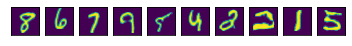

avg_is_score:	 6.096035
std_is_score:	 0.75760615
Epoch: [19] [ 100/ 468] D_loss: 0.14463788, G_loss: 0.66516054
Epoch: [19] [ 200/ 468] D_loss: 0.25320989, G_loss: 0.66271460
Epoch: [19] [ 300/ 468] D_loss: 0.12307119, G_loss: 0.69627130
Epoch: [19] [ 400/ 468] D_loss: 0.18400773, G_loss: 0.62951005


<Figure size 72x720 with 0 Axes>

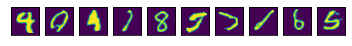

avg_is_score:	 6.1810155
std_is_score:	 1.0512935
Epoch: [20] [ 100/ 468] D_loss: 0.19965738, G_loss: 0.50325292
Epoch: [20] [ 200/ 468] D_loss: 0.13702491, G_loss: 0.63917971
Epoch: [20] [ 300/ 468] D_loss: 0.20425245, G_loss: 0.56878573
Epoch: [20] [ 400/ 468] D_loss: 0.16366014, G_loss: 0.70719332


<Figure size 72x720 with 0 Axes>

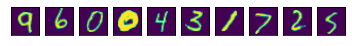

Generator Reconstruction Images


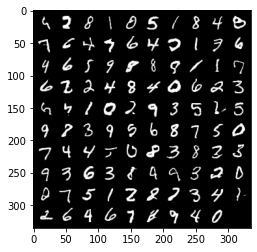

avg_is_score:	 6.247403
std_is_score:	 0.7960525
Epoch: [21] [ 100/ 468] D_loss: 0.15530260, G_loss: 0.57074046
Epoch: [21] [ 200/ 468] D_loss: 0.14581510, G_loss: 0.57657540
Epoch: [21] [ 300/ 468] D_loss: 0.17470983, G_loss: 0.67780685
Epoch: [21] [ 400/ 468] D_loss: 0.13254252, G_loss: 0.71233022


<Figure size 72x720 with 0 Axes>

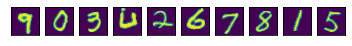

avg_is_score:	 6.4281816
std_is_score:	 0.65941155
Epoch: [22] [ 100/ 468] D_loss: 0.19470215, G_loss: 0.55012840
Epoch: [22] [ 200/ 468] D_loss: 0.16899374, G_loss: 0.48793432
Epoch: [22] [ 300/ 468] D_loss: 0.19871604, G_loss: 0.62424922
Epoch: [22] [ 400/ 468] D_loss: 0.18284160, G_loss: 0.66659266


<Figure size 72x720 with 0 Axes>

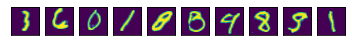

avg_is_score:	 6.161735
std_is_score:	 1.0729585
Epoch: [23] [ 100/ 468] D_loss: 0.15004045, G_loss: 0.61385155
Epoch: [23] [ 200/ 468] D_loss: 0.21620160, G_loss: 0.30564821
Epoch: [23] [ 300/ 468] D_loss: 0.09492703, G_loss: 0.68446851
Epoch: [23] [ 400/ 468] D_loss: 0.11450919, G_loss: 0.61704582


<Figure size 72x720 with 0 Axes>

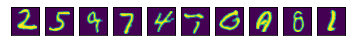

avg_is_score:	 6.4349813
std_is_score:	 0.6578597
Epoch: [24] [ 100/ 468] D_loss: 0.13496390, G_loss: 0.68700683
Epoch: [24] [ 200/ 468] D_loss: 0.16902909, G_loss: 0.70022142
Epoch: [24] [ 300/ 468] D_loss: 0.15652616, G_loss: 0.62752765
Epoch: [24] [ 400/ 468] D_loss: 0.17674819, G_loss: 0.71792698


<Figure size 72x720 with 0 Axes>

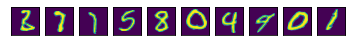

avg_is_score:	 6.8942313
std_is_score:	 0.7404045
Epoch: [25] [ 100/ 468] D_loss: 0.18130831, G_loss: 0.63024598
Epoch: [25] [ 200/ 468] D_loss: 0.12461205, G_loss: 0.60985106
Epoch: [25] [ 300/ 468] D_loss: 0.23995766, G_loss: 0.49165684
Epoch: [25] [ 400/ 468] D_loss: 0.17485692, G_loss: 0.68783230


<Figure size 72x720 with 0 Axes>

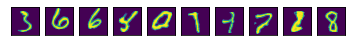

avg_is_score:	 6.0862517
std_is_score:	 0.5822036
Epoch: [26] [ 100/ 468] D_loss: 0.14239450, G_loss: 0.62392515
Epoch: [26] [ 200/ 468] D_loss: 0.10212842, G_loss: 0.64705074
Epoch: [26] [ 300/ 468] D_loss: 0.18749480, G_loss: 0.44918692
Epoch: [26] [ 400/ 468] D_loss: 0.14574350, G_loss: 0.58235162


<Figure size 72x720 with 0 Axes>

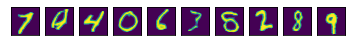

avg_is_score:	 6.4823046
std_is_score:	 1.1201745
Epoch: [27] [ 100/ 468] D_loss: 0.10783499, G_loss: 0.67007494
Epoch: [27] [ 200/ 468] D_loss: 0.11529683, G_loss: 0.67698455
Epoch: [27] [ 300/ 468] D_loss: 0.14798160, G_loss: 0.73318297
Epoch: [27] [ 400/ 468] D_loss: 0.16108549, G_loss: 0.68237394


<Figure size 72x720 with 0 Axes>

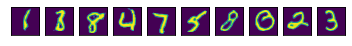

avg_is_score:	 6.1398396
std_is_score:	 0.71973836
Epoch: [28] [ 100/ 468] D_loss: 0.19183120, G_loss: 0.60180157
Epoch: [28] [ 200/ 468] D_loss: 0.12928686, G_loss: 0.64814532
Epoch: [28] [ 300/ 468] D_loss: 0.22757401, G_loss: 0.52803129
Epoch: [28] [ 400/ 468] D_loss: 0.17232068, G_loss: 0.66328108


<Figure size 72x720 with 0 Axes>

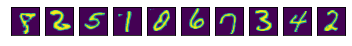

avg_is_score:	 6.4130087
std_is_score:	 0.7590204
Epoch: [29] [ 100/ 468] D_loss: 0.17428400, G_loss: 0.72731757
Epoch: [29] [ 200/ 468] D_loss: 0.14538322, G_loss: 0.59636819
Epoch: [29] [ 300/ 468] D_loss: 0.20718855, G_loss: 0.66128308
Epoch: [29] [ 400/ 468] D_loss: 0.15848577, G_loss: 0.72885585


<Figure size 72x720 with 0 Axes>

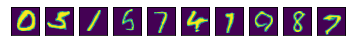

avg_is_score:	 5.765339
std_is_score:	 0.5177721
Epoch: [30] [ 100/ 468] D_loss: 0.37352550, G_loss: 0.52869594
Epoch: [30] [ 200/ 468] D_loss: 0.14062476, G_loss: 0.67465371
Epoch: [30] [ 300/ 468] D_loss: 0.11811104, G_loss: 0.62054020
Epoch: [30] [ 400/ 468] D_loss: 0.12173903, G_loss: 0.64053380


<Figure size 72x720 with 0 Axes>

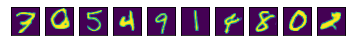

Generator Reconstruction Images


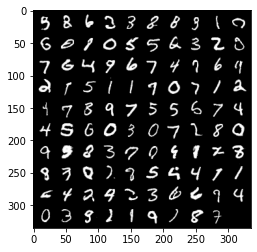

avg_is_score:	 6.1974993
std_is_score:	 0.811437
Epoch: [31] [ 100/ 468] D_loss: 0.14841986, G_loss: 0.67223179
Epoch: [31] [ 200/ 468] D_loss: 0.14709693, G_loss: 0.65607160
Epoch: [31] [ 300/ 468] D_loss: 0.14992771, G_loss: 0.59248781
Epoch: [31] [ 400/ 468] D_loss: 0.12700653, G_loss: 0.69202358


<Figure size 72x720 with 0 Axes>

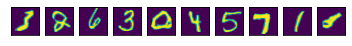

avg_is_score:	 6.115427
std_is_score:	 0.78323996
Epoch: [32] [ 100/ 468] D_loss: 0.13843042, G_loss: 0.63991898
Epoch: [32] [ 200/ 468] D_loss: 0.13199912, G_loss: 0.74218655
Epoch: [32] [ 300/ 468] D_loss: 0.12700041, G_loss: 0.63292348
Epoch: [32] [ 400/ 468] D_loss: 0.16771737, G_loss: 0.67502564


<Figure size 72x720 with 0 Axes>

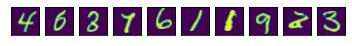

avg_is_score:	 6.250886
std_is_score:	 0.94298786
Epoch: [33] [ 100/ 468] D_loss: 0.13884968, G_loss: 0.68622482
Epoch: [33] [ 200/ 468] D_loss: 0.19506527, G_loss: 0.70828146
Epoch: [33] [ 300/ 468] D_loss: 0.19215792, G_loss: 0.68568599
Epoch: [33] [ 400/ 468] D_loss: 0.12032515, G_loss: 0.62262541


<Figure size 72x720 with 0 Axes>

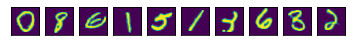

avg_is_score:	 6.0887604
std_is_score:	 0.6828498
Epoch: [34] [ 100/ 468] D_loss: 0.13039356, G_loss: 0.57267797
Epoch: [34] [ 200/ 468] D_loss: 0.09816781, G_loss: 0.69614637
Epoch: [34] [ 300/ 468] D_loss: 0.15894863, G_loss: 0.61164224
Epoch: [34] [ 400/ 468] D_loss: 0.14719278, G_loss: 0.74375391


<Figure size 72x720 with 0 Axes>

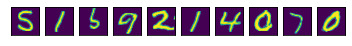

avg_is_score:	 6.5592146
std_is_score:	 0.97272193
Epoch: [35] [ 100/ 468] D_loss: 0.19587514, G_loss: 0.64429104
Epoch: [35] [ 200/ 468] D_loss: 0.15243208, G_loss: 0.72756582
Epoch: [35] [ 300/ 468] D_loss: 0.21559373, G_loss: 0.73857462
Epoch: [35] [ 400/ 468] D_loss: 0.12538639, G_loss: 0.61355293


<Figure size 72x720 with 0 Axes>

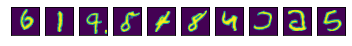

avg_is_score:	 5.7871475
std_is_score:	 0.6575899
Epoch: [36] [ 100/ 468] D_loss: 0.07048818, G_loss: 0.66356397
Epoch: [36] [ 200/ 468] D_loss: 0.09638636, G_loss: 0.72955060
Epoch: [36] [ 300/ 468] D_loss: 0.21992922, G_loss: 0.59271240
Epoch: [36] [ 400/ 468] D_loss: 0.15301245, G_loss: 0.64353776


<Figure size 72x720 with 0 Axes>

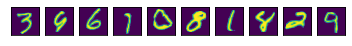

avg_is_score:	 5.7047057
std_is_score:	 0.5014168
Epoch: [37] [ 100/ 468] D_loss: 0.16057107, G_loss: 0.61116117
Epoch: [37] [ 200/ 468] D_loss: 0.15142208, G_loss: 0.67226458
Epoch: [37] [ 300/ 468] D_loss: 0.09858474, G_loss: 0.57778990
Epoch: [37] [ 400/ 468] D_loss: 0.14836429, G_loss: 0.63368261


<Figure size 72x720 with 0 Axes>

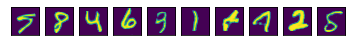

avg_is_score:	 6.23903
std_is_score:	 0.82782763
Epoch: [38] [ 100/ 468] D_loss: 0.09767581, G_loss: 0.63996851
Epoch: [38] [ 200/ 468] D_loss: 0.12153478, G_loss: 0.65608454
Epoch: [38] [ 300/ 468] D_loss: 0.13892463, G_loss: 0.61881459
Epoch: [38] [ 400/ 468] D_loss: 0.12750092, G_loss: 0.61695433


<Figure size 72x720 with 0 Axes>

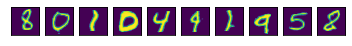

avg_is_score:	 6.2359924
std_is_score:	 1.1375022
Epoch: [39] [ 100/ 468] D_loss: 0.19533512, G_loss: 0.56398773
Epoch: [39] [ 200/ 468] D_loss: 0.11001068, G_loss: 0.70961815
Epoch: [39] [ 300/ 468] D_loss: 0.10863765, G_loss: 0.68799376
Epoch: [39] [ 400/ 468] D_loss: 0.13971671, G_loss: 0.75785375


<Figure size 72x720 with 0 Axes>

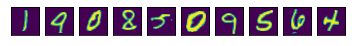

avg_is_score:	 6.220651
std_is_score:	 1.1277524
Epoch: [40] [ 100/ 468] D_loss: 0.34294808, G_loss: 0.50821865
Epoch: [40] [ 200/ 468] D_loss: 0.11954409, G_loss: 0.69635642
Epoch: [40] [ 300/ 468] D_loss: 0.13305047, G_loss: 0.71448106
Epoch: [40] [ 400/ 468] D_loss: 0.11034504, G_loss: 0.65245342


<Figure size 72x720 with 0 Axes>

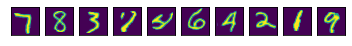

Generator Reconstruction Images


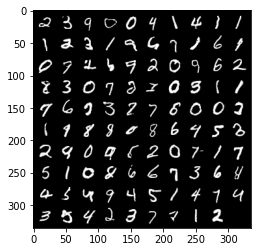

avg_is_score:	 6.1634264
std_is_score:	 1.2105328
Epoch: [41] [ 100/ 468] D_loss: 0.14344430, G_loss: 0.68840498
Epoch: [41] [ 200/ 468] D_loss: 0.10169389, G_loss: 0.71357524
Epoch: [41] [ 300/ 468] D_loss: 0.16464643, G_loss: 0.41699159
Epoch: [41] [ 400/ 468] D_loss: 0.22207940, G_loss: 0.65679598


<Figure size 72x720 with 0 Axes>

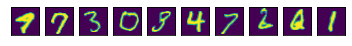

avg_is_score:	 6.4495454
std_is_score:	 1.0882739
Epoch: [42] [ 100/ 468] D_loss: 0.15686668, G_loss: 0.75985855
Epoch: [42] [ 200/ 468] D_loss: 0.12704021, G_loss: 0.71222508
Epoch: [42] [ 300/ 468] D_loss: 0.11080630, G_loss: 0.63679838
Epoch: [42] [ 400/ 468] D_loss: 0.36812884, G_loss: 0.61522192


<Figure size 72x720 with 0 Axes>

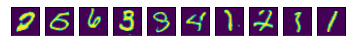

avg_is_score:	 6.5342474
std_is_score:	 0.71489555
Epoch: [43] [ 100/ 468] D_loss: 0.11480305, G_loss: 0.72646475
Epoch: [43] [ 200/ 468] D_loss: 0.12011255, G_loss: 0.64278018
Epoch: [43] [ 300/ 468] D_loss: 0.10614195, G_loss: 0.69506311
Epoch: [43] [ 400/ 468] D_loss: 0.13166365, G_loss: 0.72670674


<Figure size 72x720 with 0 Axes>

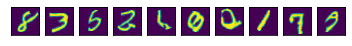

avg_is_score:	 5.966665
std_is_score:	 0.691138
Epoch: [44] [ 100/ 468] D_loss: 0.15870124, G_loss: 0.67536896
Epoch: [44] [ 200/ 468] D_loss: 0.16524005, G_loss: 0.72669715
Epoch: [44] [ 300/ 468] D_loss: 0.17097905, G_loss: 0.63728774
Epoch: [44] [ 400/ 468] D_loss: 0.18333554, G_loss: 0.75096381


<Figure size 72x720 with 0 Axes>

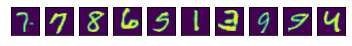

avg_is_score:	 6.379945
std_is_score:	 0.9893327
Epoch: [45] [ 100/ 468] D_loss: 0.11799550, G_loss: 0.67978817
Epoch: [45] [ 200/ 468] D_loss: 0.14699230, G_loss: 0.77061367
Epoch: [45] [ 300/ 468] D_loss: 0.10988520, G_loss: 0.72579116
Epoch: [45] [ 400/ 468] D_loss: 0.12676515, G_loss: 0.62510639


<Figure size 72x720 with 0 Axes>

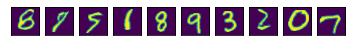

avg_is_score:	 6.440932
std_is_score:	 0.8508521
Epoch: [46] [ 100/ 468] D_loss: 0.10879972, G_loss: 0.74751943
Epoch: [46] [ 200/ 468] D_loss: 0.10806844, G_loss: 0.67882442
Epoch: [46] [ 300/ 468] D_loss: 0.14044514, G_loss: 0.61339211
Epoch: [46] [ 400/ 468] D_loss: 0.17329371, G_loss: 0.60212016


<Figure size 72x720 with 0 Axes>

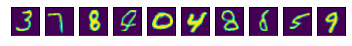

avg_is_score:	 6.494067
std_is_score:	 0.594224
Epoch: [47] [ 100/ 468] D_loss: 0.08451766, G_loss: 0.69311786
Epoch: [47] [ 200/ 468] D_loss: 0.12815863, G_loss: 0.68975866
Epoch: [47] [ 300/ 468] D_loss: 0.23130846, G_loss: 0.63411152
Epoch: [47] [ 400/ 468] D_loss: 0.12564099, G_loss: 0.59132314


<Figure size 72x720 with 0 Axes>

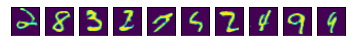

avg_is_score:	 6.1334114
std_is_score:	 0.7690402
Epoch: [48] [ 100/ 468] D_loss: 0.09753814, G_loss: 0.70635414
Epoch: [48] [ 200/ 468] D_loss: 0.20923856, G_loss: 0.75656641
Epoch: [48] [ 300/ 468] D_loss: 0.13293898, G_loss: 0.68230486
Epoch: [48] [ 400/ 468] D_loss: 0.17788723, G_loss: 0.75418544


<Figure size 72x720 with 0 Axes>

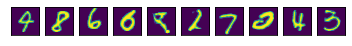

avg_is_score:	 6.469537
std_is_score:	 0.72314286
Epoch: [49] [ 100/ 468] D_loss: 0.20159738, G_loss: 0.67738557
Epoch: [49] [ 200/ 468] D_loss: 0.16799924, G_loss: 0.55194741
Epoch: [49] [ 300/ 468] D_loss: 0.11207741, G_loss: 0.55838537
Epoch: [49] [ 400/ 468] D_loss: 0.12330063, G_loss: 0.65923679


<Figure size 72x720 with 0 Axes>

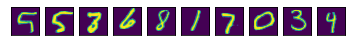

avg_is_score:	 5.934187
std_is_score:	 0.9076198
Epoch: [50] [ 100/ 468] D_loss: 0.10349579, G_loss: 0.74200594
Epoch: [50] [ 200/ 468] D_loss: 0.09869203, G_loss: 0.66283000
Epoch: [50] [ 300/ 468] D_loss: 0.14009733, G_loss: 0.73798025
Epoch: [50] [ 400/ 468] D_loss: 0.10025001, G_loss: 0.59262079


<Figure size 72x720 with 0 Axes>

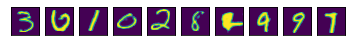

Generator Reconstruction Images


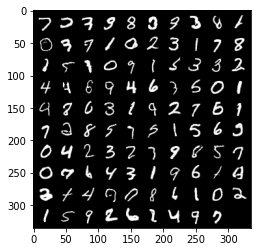

avg_is_score:	 6.335603
std_is_score:	 1.4302546
Epoch: [51] [ 100/ 468] D_loss: 0.08532602, G_loss: 0.76000714
Epoch: [51] [ 200/ 468] D_loss: 0.08419430, G_loss: 0.69225371
Epoch: [51] [ 300/ 468] D_loss: 0.11814962, G_loss: 0.66088831
Epoch: [51] [ 400/ 468] D_loss: 0.11571203, G_loss: 0.75131214


<Figure size 72x720 with 0 Axes>

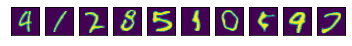

avg_is_score:	 6.332621
std_is_score:	 0.9065447
Epoch: [52] [ 100/ 468] D_loss: 0.14321698, G_loss: 0.73872882
Epoch: [52] [ 200/ 468] D_loss: 0.07217979, G_loss: 0.74953455
Epoch: [52] [ 300/ 468] D_loss: 0.07094244, G_loss: 0.72958517
Epoch: [52] [ 400/ 468] D_loss: 0.10408926, G_loss: 0.71452403


<Figure size 72x720 with 0 Axes>

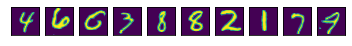

avg_is_score:	 5.9737673
std_is_score:	 0.8482436
Epoch: [53] [ 100/ 468] D_loss: 0.14688218, G_loss: 0.63453221
Epoch: [53] [ 200/ 468] D_loss: 0.13029148, G_loss: 0.63499880
Epoch: [53] [ 300/ 468] D_loss: 0.11754142, G_loss: 0.74586248
Epoch: [53] [ 400/ 468] D_loss: 0.13570105, G_loss: 0.73917007


<Figure size 72x720 with 0 Axes>

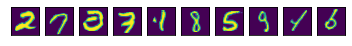

avg_is_score:	 5.8784895
std_is_score:	 0.7332054
Epoch: [54] [ 100/ 468] D_loss: 0.06751885, G_loss: 0.72501969
Epoch: [54] [ 200/ 468] D_loss: 0.10687589, G_loss: 0.71732128
Epoch: [54] [ 300/ 468] D_loss: 0.07452932, G_loss: 0.68449390
Epoch: [54] [ 400/ 468] D_loss: 0.10372707, G_loss: 0.76938725


<Figure size 72x720 with 0 Axes>

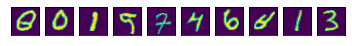

avg_is_score:	 6.817655
std_is_score:	 0.7828117
Epoch: [55] [ 100/ 468] D_loss: 0.06337262, G_loss: 0.68819869
Epoch: [55] [ 200/ 468] D_loss: 0.14846012, G_loss: 0.62558568
Epoch: [55] [ 300/ 468] D_loss: 0.10400596, G_loss: 0.77015752
Epoch: [55] [ 400/ 468] D_loss: 0.11076777, G_loss: 0.77070242


<Figure size 72x720 with 0 Axes>

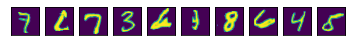

avg_is_score:	 6.638987
std_is_score:	 0.9991402
Epoch: [56] [ 100/ 468] D_loss: 0.08052546, G_loss: 0.72050059
Epoch: [56] [ 200/ 468] D_loss: 0.10954954, G_loss: 0.73946244
Epoch: [56] [ 300/ 468] D_loss: 0.09391221, G_loss: 0.60734582
Epoch: [56] [ 400/ 468] D_loss: 0.10578327, G_loss: 0.63268745


<Figure size 72x720 with 0 Axes>

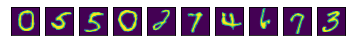

avg_is_score:	 6.7203994
std_is_score:	 0.9989816
Epoch: [57] [ 100/ 468] D_loss: 0.15727438, G_loss: 0.66151983
Epoch: [57] [ 200/ 468] D_loss: 0.09750267, G_loss: 0.74389529
Epoch: [57] [ 300/ 468] D_loss: 0.17727034, G_loss: 0.70246726
Epoch: [57] [ 400/ 468] D_loss: 0.18721972, G_loss: 0.59870619


<Figure size 72x720 with 0 Axes>

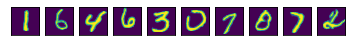

avg_is_score:	 6.204503
std_is_score:	 0.93680274
Epoch: [58] [ 100/ 468] D_loss: 0.13347363, G_loss: 0.76830286
Epoch: [58] [ 200/ 468] D_loss: 0.16022229, G_loss: 0.59126008
Epoch: [58] [ 300/ 468] D_loss: 0.17074807, G_loss: 0.66948402
Epoch: [58] [ 400/ 468] D_loss: 0.09450352, G_loss: 0.74693269


<Figure size 72x720 with 0 Axes>

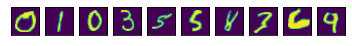

avg_is_score:	 7.0477104
std_is_score:	 0.8286867
Epoch: [59] [ 100/ 468] D_loss: 0.18434665, G_loss: 0.74903649
Epoch: [59] [ 200/ 468] D_loss: 0.09518057, G_loss: 0.73531991
Epoch: [59] [ 300/ 468] D_loss: 0.10305309, G_loss: 0.71292257
Epoch: [59] [ 400/ 468] D_loss: 0.07910192, G_loss: 0.72528076


<Figure size 72x720 with 0 Axes>

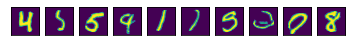

avg_is_score:	 6.588998
std_is_score:	 1.1719364
Epoch: [60] [ 100/ 468] D_loss: 0.12824042, G_loss: 0.69927120
Epoch: [60] [ 200/ 468] D_loss: 0.06807026, G_loss: 0.71041727
Epoch: [60] [ 300/ 468] D_loss: 0.12067118, G_loss: 0.64330512
Epoch: [60] [ 400/ 468] D_loss: 0.13573696, G_loss: 0.74343461


<Figure size 72x720 with 0 Axes>

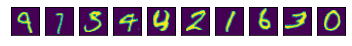

Generator Reconstruction Images


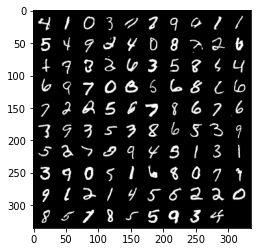

avg_is_score:	 5.9329195
std_is_score:	 1.2538619
Epoch: [61] [ 100/ 468] D_loss: 0.07809734, G_loss: 0.75507152
Epoch: [61] [ 200/ 468] D_loss: 0.06258637, G_loss: 0.73043555
Epoch: [61] [ 300/ 468] D_loss: 0.16273081, G_loss: 0.70867783
Epoch: [61] [ 400/ 468] D_loss: 0.11397152, G_loss: 0.73453605


<Figure size 72x720 with 0 Axes>

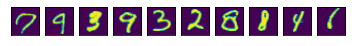

avg_is_score:	 6.138635
std_is_score:	 0.8536602
Epoch: [62] [ 100/ 468] D_loss: 0.13726583, G_loss: 0.67156118
Epoch: [62] [ 200/ 468] D_loss: 0.12643117, G_loss: 0.74120617
Epoch: [62] [ 300/ 468] D_loss: 0.13709933, G_loss: 0.67442203
Epoch: [62] [ 400/ 468] D_loss: 0.09686638, G_loss: 0.73708296


<Figure size 72x720 with 0 Axes>

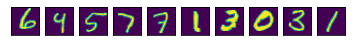

avg_is_score:	 6.5101523
std_is_score:	 1.0517944
Epoch: [63] [ 100/ 468] D_loss: 0.08509221, G_loss: 0.72335666
Epoch: [63] [ 200/ 468] D_loss: 0.09751767, G_loss: 0.71478045
Epoch: [63] [ 300/ 468] D_loss: 0.21534783, G_loss: 0.54615510
Epoch: [63] [ 400/ 468] D_loss: 0.12104104, G_loss: 0.64644456


<Figure size 72x720 with 0 Axes>

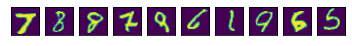

avg_is_score:	 6.447928
std_is_score:	 0.6206319
Epoch: [64] [ 100/ 468] D_loss: 0.15511543, G_loss: 0.75719631
Epoch: [64] [ 200/ 468] D_loss: 0.08013710, G_loss: 0.72827893
Epoch: [64] [ 300/ 468] D_loss: 0.13723612, G_loss: 0.68705654
Epoch: [64] [ 400/ 468] D_loss: 0.09991288, G_loss: 0.75712174


<Figure size 72x720 with 0 Axes>

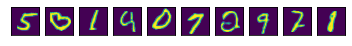

avg_is_score:	 6.5914984
std_is_score:	 0.8474157
Epoch: [65] [ 100/ 468] D_loss: 0.06892768, G_loss: 0.73909467
Epoch: [65] [ 200/ 468] D_loss: 0.29778045, G_loss: 0.68617082
Epoch: [65] [ 300/ 468] D_loss: 0.08511860, G_loss: 0.74607337
Epoch: [65] [ 400/ 468] D_loss: 0.11579697, G_loss: 0.70562136


<Figure size 72x720 with 0 Axes>

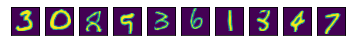

avg_is_score:	 6.453664
std_is_score:	 0.681354
Epoch: [66] [ 100/ 468] D_loss: 0.06592666, G_loss: 0.73832810
Epoch: [66] [ 200/ 468] D_loss: 0.08974998, G_loss: 0.71302259
Epoch: [66] [ 300/ 468] D_loss: 0.13411590, G_loss: 0.73751891
Epoch: [66] [ 400/ 468] D_loss: 0.10767024, G_loss: 0.73004365


<Figure size 72x720 with 0 Axes>

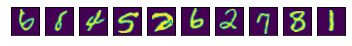

avg_is_score:	 6.2627096
std_is_score:	 0.8935638
Epoch: [67] [ 100/ 468] D_loss: 0.17449617, G_loss: 0.66658962
Epoch: [67] [ 200/ 468] D_loss: 0.11596981, G_loss: 0.59412849
Epoch: [67] [ 300/ 468] D_loss: 0.09568609, G_loss: 0.75288039
Epoch: [67] [ 400/ 468] D_loss: 0.09663747, G_loss: 0.66591501


<Figure size 72x720 with 0 Axes>

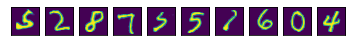

avg_is_score:	 5.7080398
std_is_score:	 0.9798686
Epoch: [68] [ 100/ 468] D_loss: 0.11736733, G_loss: 0.70258564
Epoch: [68] [ 200/ 468] D_loss: 0.09838630, G_loss: 0.72846305
Epoch: [68] [ 300/ 468] D_loss: 0.08756740, G_loss: 0.67719823
Epoch: [68] [ 400/ 468] D_loss: 0.10641532, G_loss: 0.71883184


<Figure size 72x720 with 0 Axes>

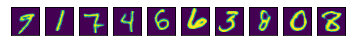

avg_is_score:	 6.1062417
std_is_score:	 0.8594285
Epoch: [69] [ 100/ 468] D_loss: 0.15039268, G_loss: 0.68360746
Epoch: [69] [ 200/ 468] D_loss: 0.09561557, G_loss: 0.75038350
Epoch: [69] [ 300/ 468] D_loss: 0.06035231, G_loss: 0.73963761
Epoch: [69] [ 400/ 468] D_loss: 0.09444461, G_loss: 0.74863279


<Figure size 72x720 with 0 Axes>

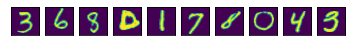

avg_is_score:	 6.1136384
std_is_score:	 1.0219666
Epoch: [70] [ 100/ 468] D_loss: 0.12673676, G_loss: 0.68924874
Epoch: [70] [ 200/ 468] D_loss: 0.11940865, G_loss: 0.75812542
Epoch: [70] [ 300/ 468] D_loss: 0.09073663, G_loss: 0.75712723
Epoch: [70] [ 400/ 468] D_loss: 0.17308462, G_loss: 0.70586574


<Figure size 72x720 with 0 Axes>

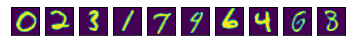

Generator Reconstruction Images


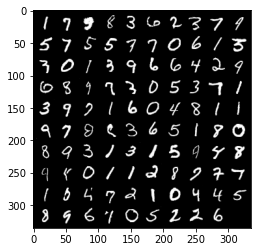

avg_is_score:	 6.1556883
std_is_score:	 0.842305
Epoch: [71] [ 100/ 468] D_loss: 0.14012799, G_loss: 0.63275456
Epoch: [71] [ 200/ 468] D_loss: 0.16382439, G_loss: 0.64083952
Epoch: [71] [ 300/ 468] D_loss: 0.11107943, G_loss: 0.71051556
Epoch: [71] [ 400/ 468] D_loss: 0.14273536, G_loss: 0.75376230


<Figure size 72x720 with 0 Axes>

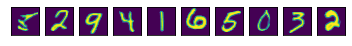

avg_is_score:	 6.1794105
std_is_score:	 1.1826383
Epoch: [72] [ 100/ 468] D_loss: 0.10172370, G_loss: 0.71343696
Epoch: [72] [ 200/ 468] D_loss: 0.10387816, G_loss: 0.69413000
Epoch: [72] [ 300/ 468] D_loss: 0.09673260, G_loss: 0.73301458
Epoch: [72] [ 400/ 468] D_loss: 0.07701723, G_loss: 0.74543029


<Figure size 72x720 with 0 Axes>

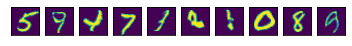

avg_is_score:	 6.1976676
std_is_score:	 0.96692675
Epoch: [73] [ 100/ 468] D_loss: 0.11497950, G_loss: 0.60699600
Epoch: [73] [ 200/ 468] D_loss: 0.06050282, G_loss: 0.71797478
Epoch: [73] [ 300/ 468] D_loss: 0.12417692, G_loss: 0.73755717
Epoch: [73] [ 400/ 468] D_loss: 0.10266966, G_loss: 0.76329231


<Figure size 72x720 with 0 Axes>

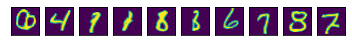

avg_is_score:	 6.1851215
std_is_score:	 1.0174917
Epoch: [74] [ 100/ 468] D_loss: 0.11027259, G_loss: 0.77158082
Epoch: [74] [ 200/ 468] D_loss: 0.13353205, G_loss: 0.70382500
Epoch: [74] [ 300/ 468] D_loss: 0.14694650, G_loss: 0.63439667
Epoch: [74] [ 400/ 468] D_loss: 0.12068886, G_loss: 0.73920393


<Figure size 72x720 with 0 Axes>

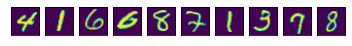

avg_is_score:	 6.2331114
std_is_score:	 1.0519221
Epoch: [75] [ 100/ 468] D_loss: 0.08696666, G_loss: 0.70982355
Epoch: [75] [ 200/ 468] D_loss: 0.08539025, G_loss: 0.70722592
Epoch: [75] [ 300/ 468] D_loss: 0.08478250, G_loss: 0.71459949
Epoch: [75] [ 400/ 468] D_loss: 0.19625242, G_loss: 0.72172755


<Figure size 72x720 with 0 Axes>

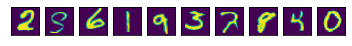

avg_is_score:	 6.03201
std_is_score:	 0.72828794
Epoch: [76] [ 100/ 468] D_loss: 0.10645374, G_loss: 0.66896278
Epoch: [76] [ 200/ 468] D_loss: 0.09538670, G_loss: 0.71949565
Epoch: [76] [ 300/ 468] D_loss: 0.09034340, G_loss: 0.74439299
Epoch: [76] [ 400/ 468] D_loss: 0.10353930, G_loss: 0.74035025


<Figure size 72x720 with 0 Axes>

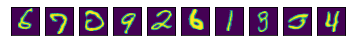

avg_is_score:	 6.1419587
std_is_score:	 0.85782623
Epoch: [77] [ 100/ 468] D_loss: 0.15162823, G_loss: 0.63269174
Epoch: [77] [ 200/ 468] D_loss: 0.08215253, G_loss: 0.75383389
Epoch: [77] [ 300/ 468] D_loss: 0.09930754, G_loss: 0.74627542
Epoch: [77] [ 400/ 468] D_loss: 0.09361057, G_loss: 0.62447178


<Figure size 72x720 with 0 Axes>

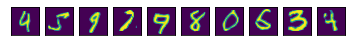

avg_is_score:	 6.0490813
std_is_score:	 0.8484019
Epoch: [78] [ 100/ 468] D_loss: 0.17143571, G_loss: 0.54459870
Epoch: [78] [ 200/ 468] D_loss: 0.12666796, G_loss: 0.66336071
Epoch: [78] [ 300/ 468] D_loss: 0.07476754, G_loss: 0.64275593
Epoch: [78] [ 400/ 468] D_loss: 0.14489773, G_loss: 0.55991447


<Figure size 72x720 with 0 Axes>

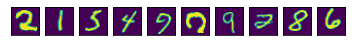

avg_is_score:	 6.130022
std_is_score:	 0.8863164
Epoch: [79] [ 100/ 468] D_loss: 0.07944678, G_loss: 0.74294388
Epoch: [79] [ 200/ 468] D_loss: 0.10512310, G_loss: 0.68888092
Epoch: [79] [ 300/ 468] D_loss: 0.11676058, G_loss: 0.77181959
Epoch: [79] [ 400/ 468] D_loss: 0.09737545, G_loss: 0.69189501


<Figure size 72x720 with 0 Axes>

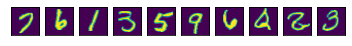

avg_is_score:	 6.566442
std_is_score:	 0.71911114
Epoch: [80] [ 100/ 468] D_loss: 0.07587911, G_loss: 0.70358807
Epoch: [80] [ 200/ 468] D_loss: 0.09783084, G_loss: 0.66369683
Epoch: [80] [ 300/ 468] D_loss: 0.19512306, G_loss: 0.67095339
Epoch: [80] [ 400/ 468] D_loss: 0.09477591, G_loss: 0.74981225


<Figure size 72x720 with 0 Axes>

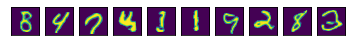

Generator Reconstruction Images


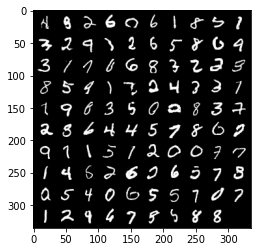

avg_is_score:	 6.2609844
std_is_score:	 0.6911866
Epoch: [81] [ 100/ 468] D_loss: 0.07132553, G_loss: 0.72593635
Epoch: [81] [ 200/ 468] D_loss: 0.10243579, G_loss: 0.71989459
Epoch: [81] [ 300/ 468] D_loss: 0.11978051, G_loss: 0.47963899
Epoch: [81] [ 400/ 468] D_loss: 0.23079492, G_loss: 0.45715541


<Figure size 72x720 with 0 Axes>

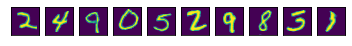

avg_is_score:	 6.115392
std_is_score:	 0.70712256
Epoch: [82] [ 100/ 468] D_loss: 0.19259562, G_loss: 0.72911042
Epoch: [82] [ 200/ 468] D_loss: 0.10785937, G_loss: 0.69158828
Epoch: [82] [ 300/ 468] D_loss: 0.11421955, G_loss: 0.74495196
Epoch: [82] [ 400/ 468] D_loss: 0.07828417, G_loss: 0.73320138


<Figure size 72x720 with 0 Axes>

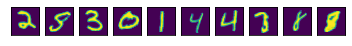

avg_is_score:	 6.4410944
std_is_score:	 0.82936937
Epoch: [83] [ 100/ 468] D_loss: 0.09265103, G_loss: 0.75462544
Epoch: [83] [ 200/ 468] D_loss: 0.13350263, G_loss: 0.67514592
Epoch: [83] [ 300/ 468] D_loss: 0.08249003, G_loss: 0.76004446
Epoch: [83] [ 400/ 468] D_loss: 0.07400651, G_loss: 0.69499737


<Figure size 72x720 with 0 Axes>

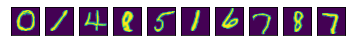

avg_is_score:	 6.12286
std_is_score:	 0.9821027
Epoch: [84] [ 100/ 468] D_loss: 0.09122533, G_loss: 0.72057956
Epoch: [84] [ 200/ 468] D_loss: 0.05857212, G_loss: 0.74183774
Epoch: [84] [ 300/ 468] D_loss: 0.09538375, G_loss: 0.70439756
Epoch: [84] [ 400/ 468] D_loss: 0.08465772, G_loss: 0.69042969


<Figure size 72x720 with 0 Axes>

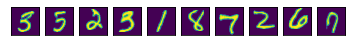

avg_is_score:	 6.3990507
std_is_score:	 0.78547055
Epoch: [85] [ 100/ 468] D_loss: 0.23462884, G_loss: 0.61903334
Epoch: [85] [ 200/ 468] D_loss: 0.16042264, G_loss: 0.74730080
Epoch: [85] [ 300/ 468] D_loss: 0.06365532, G_loss: 0.73320198
Epoch: [85] [ 400/ 468] D_loss: 0.21269609, G_loss: 0.76496035


<Figure size 72x720 with 0 Axes>

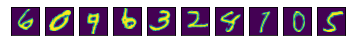

avg_is_score:	 6.8775787
std_is_score:	 0.5489306
Epoch: [86] [ 100/ 468] D_loss: 0.09642066, G_loss: 0.74816239
Epoch: [86] [ 200/ 468] D_loss: 0.09227690, G_loss: 0.73884422
Epoch: [86] [ 300/ 468] D_loss: 0.09303714, G_loss: 0.68331975
Epoch: [86] [ 400/ 468] D_loss: 0.14540383, G_loss: 0.77435124


<Figure size 72x720 with 0 Axes>

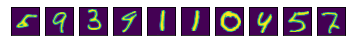

avg_is_score:	 5.9310017
std_is_score:	 1.1187207
Epoch: [87] [ 100/ 468] D_loss: 0.07648684, G_loss: 0.75517839
Epoch: [87] [ 200/ 468] D_loss: 0.08537954, G_loss: 0.73410755
Epoch: [87] [ 300/ 468] D_loss: 0.10339208, G_loss: 0.73975325
Epoch: [87] [ 400/ 468] D_loss: 0.14308910, G_loss: 0.77519405


<Figure size 72x720 with 0 Axes>

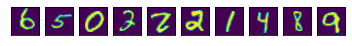

avg_is_score:	 5.6863947
std_is_score:	 0.8063308
Epoch: [88] [ 100/ 468] D_loss: 0.14310732, G_loss: 0.75119185
Epoch: [88] [ 200/ 468] D_loss: 0.07753119, G_loss: 0.75055528
Epoch: [88] [ 300/ 468] D_loss: 0.09489988, G_loss: 0.76818979
Epoch: [88] [ 400/ 468] D_loss: 0.07063527, G_loss: 0.73123968


<Figure size 72x720 with 0 Axes>

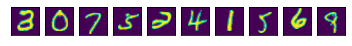

avg_is_score:	 6.4583054
std_is_score:	 0.9324342
Epoch: [89] [ 100/ 468] D_loss: 0.09588319, G_loss: 0.70147854
Epoch: [89] [ 200/ 468] D_loss: 0.09373089, G_loss: 0.70985919
Epoch: [89] [ 300/ 468] D_loss: 0.14139895, G_loss: 0.75721800
Epoch: [89] [ 400/ 468] D_loss: 0.17678666, G_loss: 0.59957987


<Figure size 72x720 with 0 Axes>

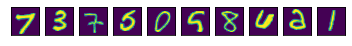

avg_is_score:	 6.389115
std_is_score:	 0.6602687
Epoch: [90] [ 100/ 468] D_loss: 0.11908297, G_loss: 0.74351633
Epoch: [90] [ 200/ 468] D_loss: 0.07062657, G_loss: 0.73362690
Epoch: [90] [ 300/ 468] D_loss: 0.13204779, G_loss: 0.68367445
Epoch: [90] [ 400/ 468] D_loss: 0.13829808, G_loss: 0.66457331


<Figure size 72x720 with 0 Axes>

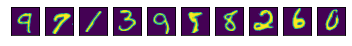

Generator Reconstruction Images


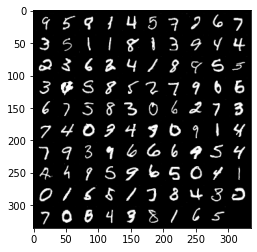

avg_is_score:	 6.014255
std_is_score:	 0.9391258
Epoch: [91] [ 100/ 468] D_loss: 0.08616515, G_loss: 0.68349755
Epoch: [91] [ 200/ 468] D_loss: 0.13313586, G_loss: 0.58273989
Epoch: [91] [ 300/ 468] D_loss: 0.13897768, G_loss: 0.70657539
Epoch: [91] [ 400/ 468] D_loss: 0.09714521, G_loss: 0.71012497


<Figure size 72x720 with 0 Axes>

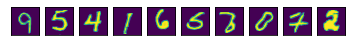

avg_is_score:	 5.9677715
std_is_score:	 1.0942402
Epoch: [92] [ 100/ 468] D_loss: 0.09000206, G_loss: 0.66488332
Epoch: [92] [ 200/ 468] D_loss: 0.07092994, G_loss: 0.75077057
Epoch: [92] [ 300/ 468] D_loss: 0.05885140, G_loss: 0.73990560
Epoch: [92] [ 400/ 468] D_loss: 0.12074103, G_loss: 0.76733500


<Figure size 72x720 with 0 Axes>

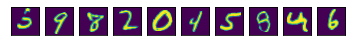

avg_is_score:	 5.704705
std_is_score:	 0.8202594
Epoch: [93] [ 100/ 468] D_loss: 0.08241012, G_loss: 0.76359427
Epoch: [93] [ 200/ 468] D_loss: 0.06999834, G_loss: 0.73975497
Epoch: [93] [ 300/ 468] D_loss: 0.11653018, G_loss: 0.69264734
Epoch: [93] [ 400/ 468] D_loss: 0.10064337, G_loss: 0.71927607


<Figure size 72x720 with 0 Axes>

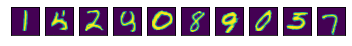

avg_is_score:	 6.316133
std_is_score:	 0.4977922
Epoch: [94] [ 100/ 468] D_loss: 0.10308279, G_loss: 0.70558220
Epoch: [94] [ 200/ 468] D_loss: 0.12357095, G_loss: 0.74045014
Epoch: [94] [ 300/ 468] D_loss: 0.08675153, G_loss: 0.74122173
Epoch: [94] [ 400/ 468] D_loss: 0.09207357, G_loss: 0.75007051


<Figure size 72x720 with 0 Axes>

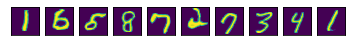

avg_is_score:	 6.38629
std_is_score:	 1.0870163
Epoch: [95] [ 100/ 468] D_loss: 0.06243366, G_loss: 0.74827194
Epoch: [95] [ 200/ 468] D_loss: 0.09077973, G_loss: 0.71844834
Epoch: [95] [ 300/ 468] D_loss: 0.08322145, G_loss: 0.75271642
Epoch: [95] [ 400/ 468] D_loss: 0.08149430, G_loss: 0.76029468


<Figure size 72x720 with 0 Axes>

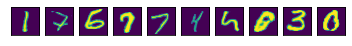

avg_is_score:	 6.4327726
std_is_score:	 0.5076237
Epoch: [96] [ 100/ 468] D_loss: 0.11132701, G_loss: 0.72159970
Epoch: [96] [ 200/ 468] D_loss: 0.08627720, G_loss: 0.68003845
Epoch: [96] [ 300/ 468] D_loss: 0.19152871, G_loss: 0.52489054
Epoch: [96] [ 400/ 468] D_loss: 0.08221687, G_loss: 0.74625325


<Figure size 72x720 with 0 Axes>

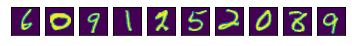

avg_is_score:	 6.290105
std_is_score:	 0.5946943
Epoch: [97] [ 100/ 468] D_loss: 0.09933316, G_loss: 0.66961139
Epoch: [97] [ 200/ 468] D_loss: 0.07477205, G_loss: 0.73654991
Epoch: [97] [ 300/ 468] D_loss: 0.11905800, G_loss: 0.76975024
Epoch: [97] [ 400/ 468] D_loss: 0.14913429, G_loss: 0.68279487


<Figure size 72x720 with 0 Axes>

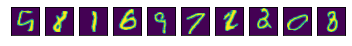

avg_is_score:	 6.356361
std_is_score:	 1.0149336
Epoch: [98] [ 100/ 468] D_loss: 0.09281551, G_loss: 0.77643633
Epoch: [98] [ 200/ 468] D_loss: 0.14661604, G_loss: 0.77658498
Epoch: [98] [ 300/ 468] D_loss: 0.07388981, G_loss: 0.74026471
Epoch: [98] [ 400/ 468] D_loss: 0.08905102, G_loss: 0.74264187


<Figure size 72x720 with 0 Axes>

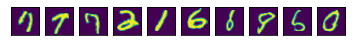

avg_is_score:	 6.3649607
std_is_score:	 1.0973419
Epoch: [99] [ 100/ 468] D_loss: 0.09309827, G_loss: 0.73641634
Epoch: [99] [ 200/ 468] D_loss: 0.08687074, G_loss: 0.77364898
Epoch: [99] [ 300/ 468] D_loss: 0.08323228, G_loss: 0.72369063
Epoch: [99] [ 400/ 468] D_loss: 0.22718164, G_loss: 0.64033461


<Figure size 72x720 with 0 Axes>

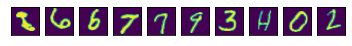

avg_is_score:	 6.548894
std_is_score:	 0.75527364
Epoch: [100] [ 100/ 468] D_loss: 0.11120075, G_loss: 0.73840225
Epoch: [100] [ 200/ 468] D_loss: 0.13012624, G_loss: 0.67023093
Epoch: [100] [ 300/ 468] D_loss: 0.07157065, G_loss: 0.72910178
Epoch: [100] [ 400/ 468] D_loss: 0.12058523, G_loss: 0.78722727


<Figure size 72x720 with 0 Axes>

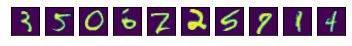

Generator Reconstruction Images


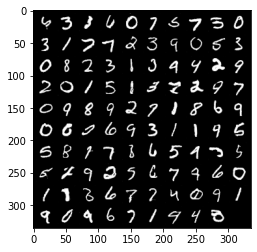

avg_is_score:	 6.326243
std_is_score:	 0.47414967
Training finished!


In [ ]:
import time
print("100 LATENT DIMENIONS")
params = {'beta1': 0.05, 'beta2': 0.999,'lr_g':0.0002,'lr_d':0.0002,'max_epochs':100}
params['z_dim'] =100
params['base_size'] = 128

gan = GAN(params)
gan.train()

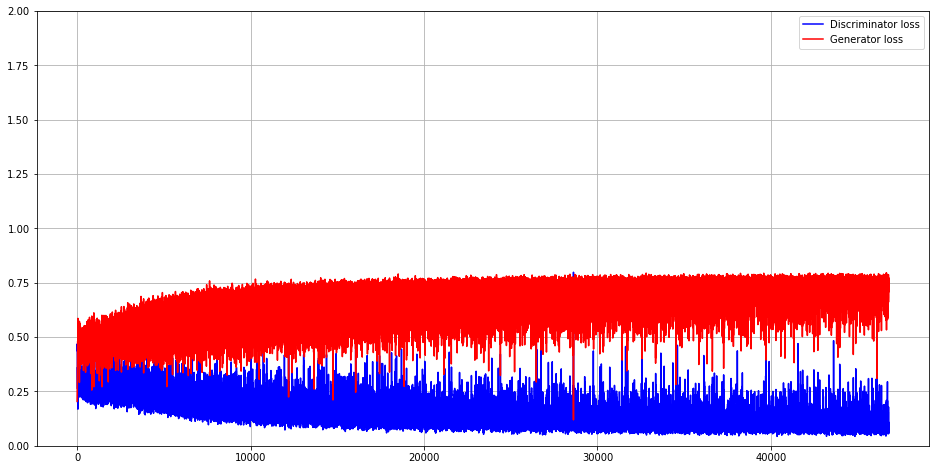

In [ ]:
plt.figure(figsize=(16,8))
s=plt.plot(gan.train_hist['D_loss'],c='b')
s=plt.plot(gan.train_hist['G_loss'],c='r')
s = plt.ylim((0,2))
s = plt.grid()
s=plt.legend(('Discriminator loss','Generator loss'))

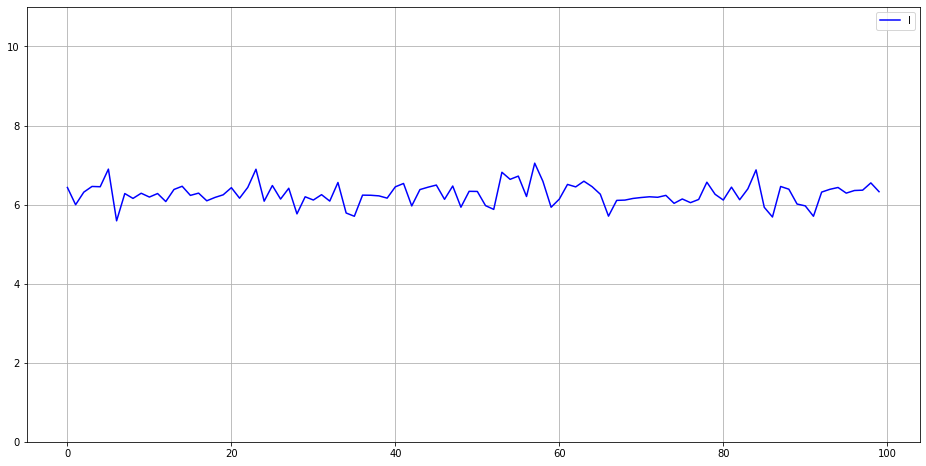

In [ ]:
plt.figure(figsize=(16,8))
s=plt.plot(gan.train_hist['IS_score'],c='b')
s = plt.ylim((0,11))
s = plt.grid()
s=plt.legend(('Inception Score'))

10 LATENT DIMENIONS
training start!!
Epoch: [ 1] [ 100/ 468] D_loss: 0.38289261, G_loss: 0.40487173
Epoch: [ 1] [ 200/ 468] D_loss: 0.33478582, G_loss: 0.40393817
Epoch: [ 1] [ 300/ 468] D_loss: 0.32886061, G_loss: 0.38347912
Epoch: [ 1] [ 400/ 468] D_loss: 0.38297167, G_loss: 0.32776538


<Figure size 72x720 with 0 Axes>

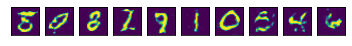

avg_is_score:	 5.650361
std_is_score:	 0.5697437
Epoch: [ 2] [ 100/ 468] D_loss: 0.34081876, G_loss: 0.41730279
Epoch: [ 2] [ 200/ 468] D_loss: 0.32576895, G_loss: 0.42929789
Epoch: [ 2] [ 300/ 468] D_loss: 0.31800333, G_loss: 0.39116949
Epoch: [ 2] [ 400/ 468] D_loss: 0.40454441, G_loss: 0.42663324


<Figure size 72x720 with 0 Axes>

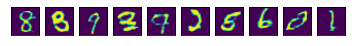

avg_is_score:	 5.974767
std_is_score:	 0.5856711
Epoch: [ 3] [ 100/ 468] D_loss: 0.32169878, G_loss: 0.40626746
Epoch: [ 3] [ 200/ 468] D_loss: 0.38228399, G_loss: 0.40930814
Epoch: [ 3] [ 300/ 468] D_loss: 0.31798720, G_loss: 0.42811954
Epoch: [ 3] [ 400/ 468] D_loss: 0.31919926, G_loss: 0.37889817


<Figure size 72x720 with 0 Axes>

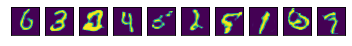

avg_is_score:	 6.2682943
std_is_score:	 1.0391366
Epoch: [ 4] [ 100/ 468] D_loss: 0.36847034, G_loss: 0.38649988
Epoch: [ 4] [ 200/ 468] D_loss: 0.33946282, G_loss: 0.41721293
Epoch: [ 4] [ 300/ 468] D_loss: 0.30855119, G_loss: 0.47026592
Epoch: [ 4] [ 400/ 468] D_loss: 0.32919848, G_loss: 0.38173610


<Figure size 72x720 with 0 Axes>

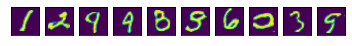

avg_is_score:	 6.2312975
std_is_score:	 0.7805088
Epoch: [ 5] [ 100/ 468] D_loss: 0.33283806, G_loss: 0.48939532
Epoch: [ 5] [ 200/ 468] D_loss: 0.31596440, G_loss: 0.48332149
Epoch: [ 5] [ 300/ 468] D_loss: 0.36815822, G_loss: 0.37039167
Epoch: [ 5] [ 400/ 468] D_loss: 0.34416789, G_loss: 0.45845491


<Figure size 72x720 with 0 Axes>

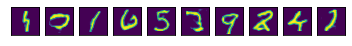

avg_is_score:	 6.499649
std_is_score:	 0.70148367
Epoch: [ 6] [ 100/ 468] D_loss: 0.31786501, G_loss: 0.45113552
Epoch: [ 6] [ 200/ 468] D_loss: 0.29209256, G_loss: 0.53436655
Epoch: [ 6] [ 300/ 468] D_loss: 0.36344126, G_loss: 0.42456195
Epoch: [ 6] [ 400/ 468] D_loss: 0.32438758, G_loss: 0.37246138


<Figure size 72x720 with 0 Axes>

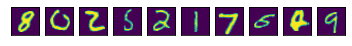

avg_is_score:	 6.5637007
std_is_score:	 0.6957783
Epoch: [ 7] [ 100/ 468] D_loss: 0.28508258, G_loss: 0.38891348
Epoch: [ 7] [ 200/ 468] D_loss: 0.33700126, G_loss: 0.51570708
Epoch: [ 7] [ 300/ 468] D_loss: 0.38430318, G_loss: 0.39801997
Epoch: [ 7] [ 400/ 468] D_loss: 0.23707882, G_loss: 0.46101588


<Figure size 72x720 with 0 Axes>

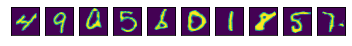

avg_is_score:	 6.2224073
std_is_score:	 0.8383252
Epoch: [ 8] [ 100/ 468] D_loss: 0.31772131, G_loss: 0.39659488
Epoch: [ 8] [ 200/ 468] D_loss: 0.27607027, G_loss: 0.54535270
Epoch: [ 8] [ 300/ 468] D_loss: 0.29253006, G_loss: 0.60560489
Epoch: [ 8] [ 400/ 468] D_loss: 0.29569820, G_loss: 0.48781767


<Figure size 72x720 with 0 Axes>

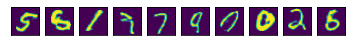

avg_is_score:	 5.470565
std_is_score:	 0.60108757
Epoch: [ 9] [ 100/ 468] D_loss: 0.24044849, G_loss: 0.55329496
Epoch: [ 9] [ 200/ 468] D_loss: 0.29299271, G_loss: 0.53188598
Epoch: [ 9] [ 300/ 468] D_loss: 0.27683574, G_loss: 0.47424030
Epoch: [ 9] [ 400/ 468] D_loss: 0.33570036, G_loss: 0.39514056


<Figure size 72x720 with 0 Axes>

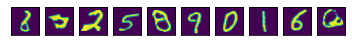

avg_is_score:	 6.3794007
std_is_score:	 0.8215475
Epoch: [10] [ 100/ 468] D_loss: 0.24696904, G_loss: 0.40642530
Epoch: [10] [ 200/ 468] D_loss: 0.43787381, G_loss: 0.47768503
Epoch: [10] [ 300/ 468] D_loss: 0.25090817, G_loss: 0.54014373
Epoch: [10] [ 400/ 468] D_loss: 0.26829806, G_loss: 0.47419983


<Figure size 72x720 with 0 Axes>

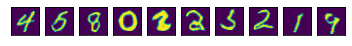

Generator Reconstruction Images


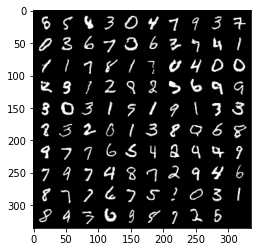

avg_is_score:	 6.3035126
std_is_score:	 0.7190582
Epoch: [11] [ 100/ 468] D_loss: 0.25163680, G_loss: 0.55528164
Epoch: [11] [ 200/ 468] D_loss: 0.27187631, G_loss: 0.59131658
Epoch: [11] [ 300/ 468] D_loss: 0.25443849, G_loss: 0.54195642
Epoch: [11] [ 400/ 468] D_loss: 0.26473188, G_loss: 0.58345795


<Figure size 72x720 with 0 Axes>

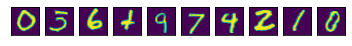

avg_is_score:	 6.1107683
std_is_score:	 0.98647976
Epoch: [12] [ 100/ 468] D_loss: 0.21097206, G_loss: 0.35811993
Epoch: [12] [ 200/ 468] D_loss: 0.30994701, G_loss: 0.46449810
Epoch: [12] [ 300/ 468] D_loss: 0.20683992, G_loss: 0.59031534
Epoch: [12] [ 400/ 468] D_loss: 0.24067378, G_loss: 0.56157476


<Figure size 72x720 with 0 Axes>

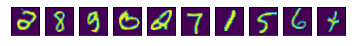

avg_is_score:	 6.4145203
std_is_score:	 0.65142405
Epoch: [13] [ 100/ 468] D_loss: 0.23753393, G_loss: 0.58046734
Epoch: [13] [ 200/ 468] D_loss: 0.19989632, G_loss: 0.63251686
Epoch: [13] [ 300/ 468] D_loss: 0.21441345, G_loss: 0.58076710
Epoch: [13] [ 400/ 468] D_loss: 0.20926121, G_loss: 0.53263092


<Figure size 72x720 with 0 Axes>

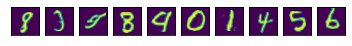

avg_is_score:	 6.368143
std_is_score:	 0.37154922
Epoch: [14] [ 100/ 468] D_loss: 0.21504325, G_loss: 0.50695795
Epoch: [14] [ 200/ 468] D_loss: 0.39684972, G_loss: 0.60102797
Epoch: [14] [ 300/ 468] D_loss: 0.16769686, G_loss: 0.54368550
Epoch: [14] [ 400/ 468] D_loss: 0.19415960, G_loss: 0.61978692


<Figure size 72x720 with 0 Axes>

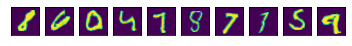

avg_is_score:	 6.13185
std_is_score:	 0.43238807
Epoch: [15] [ 100/ 468] D_loss: 0.18208253, G_loss: 0.43789768
Epoch: [15] [ 200/ 468] D_loss: 0.28224564, G_loss: 0.41305599
Epoch: [15] [ 300/ 468] D_loss: 0.19092689, G_loss: 0.60056180
Epoch: [15] [ 400/ 468] D_loss: 0.24898365, G_loss: 0.59872019


<Figure size 72x720 with 0 Axes>

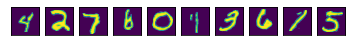

avg_is_score:	 6.202784
std_is_score:	 0.72363514
Epoch: [16] [ 100/ 468] D_loss: 0.15987021, G_loss: 0.53290844
Epoch: [16] [ 200/ 468] D_loss: 0.15624431, G_loss: 0.53659391
Epoch: [16] [ 300/ 468] D_loss: 0.16787189, G_loss: 0.51359361
Epoch: [16] [ 400/ 468] D_loss: 0.22979383, G_loss: 0.47412854


<Figure size 72x720 with 0 Axes>

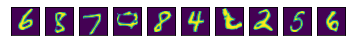

avg_is_score:	 6.1448464
std_is_score:	 0.87849265
Epoch: [17] [ 100/ 468] D_loss: 0.23492502, G_loss: 0.57818186
Epoch: [17] [ 200/ 468] D_loss: 0.17363937, G_loss: 0.59189880
Epoch: [17] [ 300/ 468] D_loss: 0.21237816, G_loss: 0.52989107
Epoch: [17] [ 400/ 468] D_loss: 0.27166811, G_loss: 0.66147137


<Figure size 72x720 with 0 Axes>

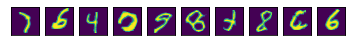

avg_is_score:	 6.627061
std_is_score:	 0.68155795
Epoch: [18] [ 100/ 468] D_loss: 0.21700579, G_loss: 0.42833734
Epoch: [18] [ 200/ 468] D_loss: 0.20672536, G_loss: 0.56603980
Epoch: [18] [ 300/ 468] D_loss: 0.16310927, G_loss: 0.59962153
Epoch: [18] [ 400/ 468] D_loss: 0.29735416, G_loss: 0.58535731


<Figure size 72x720 with 0 Axes>

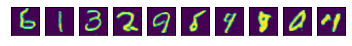

avg_is_score:	 6.239538
std_is_score:	 0.7621484
Epoch: [19] [ 100/ 468] D_loss: 0.16875026, G_loss: 0.63482434
Epoch: [19] [ 200/ 468] D_loss: 0.19106956, G_loss: 0.55377811
Epoch: [19] [ 300/ 468] D_loss: 0.22569013, G_loss: 0.50908691
Epoch: [19] [ 400/ 468] D_loss: 0.24116449, G_loss: 0.34182948


<Figure size 72x720 with 0 Axes>

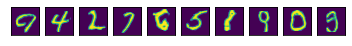

avg_is_score:	 5.8379154
std_is_score:	 0.74173474
Epoch: [20] [ 100/ 468] D_loss: 0.27354044, G_loss: 0.47943026
Epoch: [20] [ 200/ 468] D_loss: 0.15294640, G_loss: 0.51652253
Epoch: [20] [ 300/ 468] D_loss: 0.18077762, G_loss: 0.59866178
Epoch: [20] [ 400/ 468] D_loss: 0.18146217, G_loss: 0.53394842


<Figure size 72x720 with 0 Axes>

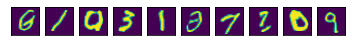

Generator Reconstruction Images


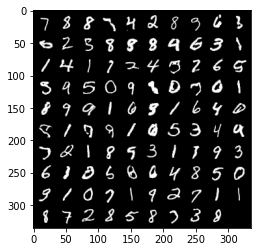

avg_is_score:	 6.100041
std_is_score:	 0.80503637
Epoch: [21] [ 100/ 468] D_loss: 0.17116144, G_loss: 0.57129133
Epoch: [21] [ 200/ 468] D_loss: 0.23670843, G_loss: 0.72605753
Epoch: [21] [ 300/ 468] D_loss: 0.13967046, G_loss: 0.59913933
Epoch: [21] [ 400/ 468] D_loss: 0.16099077, G_loss: 0.52674371


<Figure size 72x720 with 0 Axes>

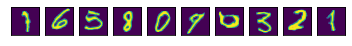

avg_is_score:	 6.1629057
std_is_score:	 0.655034
Epoch: [22] [ 100/ 468] D_loss: 0.19871253, G_loss: 0.67587984
Epoch: [22] [ 200/ 468] D_loss: 0.18941522, G_loss: 0.51594257
Epoch: [22] [ 300/ 468] D_loss: 0.19148284, G_loss: 0.62810665
Epoch: [22] [ 400/ 468] D_loss: 0.12434013, G_loss: 0.59044802


<Figure size 72x720 with 0 Axes>

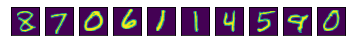

avg_is_score:	 6.2510185
std_is_score:	 0.8790353
Epoch: [23] [ 100/ 468] D_loss: 0.15702459, G_loss: 0.59213877
Epoch: [23] [ 200/ 468] D_loss: 0.15796380, G_loss: 0.50273657
Epoch: [23] [ 300/ 468] D_loss: 0.24035844, G_loss: 0.56155246
Epoch: [23] [ 400/ 468] D_loss: 0.32838625, G_loss: 0.62809527


<Figure size 72x720 with 0 Axes>

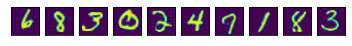

avg_is_score:	 6.0811653
std_is_score:	 1.1369433
Epoch: [24] [ 100/ 468] D_loss: 0.14006150, G_loss: 0.64160705
Epoch: [24] [ 200/ 468] D_loss: 0.23337269, G_loss: 0.57394022
Epoch: [24] [ 300/ 468] D_loss: 0.20049678, G_loss: 0.65653247
Epoch: [24] [ 400/ 468] D_loss: 0.17019519, G_loss: 0.53370976


<Figure size 72x720 with 0 Axes>

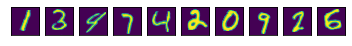

avg_is_score:	 6.285552
std_is_score:	 0.8544574
Epoch: [25] [ 100/ 468] D_loss: 0.24376480, G_loss: 0.64508116
Epoch: [25] [ 200/ 468] D_loss: 0.15414870, G_loss: 0.54651606
Epoch: [25] [ 300/ 468] D_loss: 0.26170585, G_loss: 0.56367016
Epoch: [25] [ 400/ 468] D_loss: 0.17607021, G_loss: 0.50168675


<Figure size 72x720 with 0 Axes>

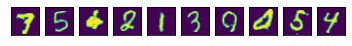

avg_is_score:	 6.4673743
std_is_score:	 0.85430026
Epoch: [26] [ 100/ 468] D_loss: 0.12648602, G_loss: 0.57761228
Epoch: [26] [ 200/ 468] D_loss: 0.13876948, G_loss: 0.68251431
Epoch: [26] [ 300/ 468] D_loss: 0.13910727, G_loss: 0.65038645
Epoch: [26] [ 400/ 468] D_loss: 0.17832480, G_loss: 0.68719208


<Figure size 72x720 with 0 Axes>

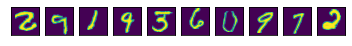

avg_is_score:	 5.916587
std_is_score:	 0.9294247
Epoch: [27] [ 100/ 468] D_loss: 0.11708580, G_loss: 0.65109396
Epoch: [27] [ 200/ 468] D_loss: 0.20094034, G_loss: 0.67854577
Epoch: [27] [ 300/ 468] D_loss: 0.17032222, G_loss: 0.63200063
Epoch: [27] [ 400/ 468] D_loss: 0.16846238, G_loss: 0.71405619


<Figure size 72x720 with 0 Axes>

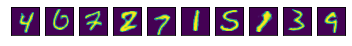

avg_is_score:	 6.052202
std_is_score:	 0.718511
Epoch: [28] [ 100/ 468] D_loss: 0.18818569, G_loss: 0.53250444
Epoch: [28] [ 200/ 468] D_loss: 0.12583907, G_loss: 0.65895510
Epoch: [28] [ 300/ 468] D_loss: 0.12869456, G_loss: 0.66119516
Epoch: [28] [ 400/ 468] D_loss: 0.22267117, G_loss: 0.61517501


<Figure size 72x720 with 0 Axes>

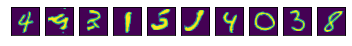

avg_is_score:	 6.6708727
std_is_score:	 1.0096816
Epoch: [29] [ 100/ 468] D_loss: 0.16197470, G_loss: 0.56980968
Epoch: [29] [ 200/ 468] D_loss: 0.16294079, G_loss: 0.69243807
Epoch: [29] [ 300/ 468] D_loss: 0.20020314, G_loss: 0.69119203
Epoch: [29] [ 400/ 468] D_loss: 0.13398692, G_loss: 0.56910050


<Figure size 72x720 with 0 Axes>

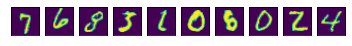

avg_is_score:	 6.5499153
std_is_score:	 0.605973
Epoch: [30] [ 100/ 468] D_loss: 0.21515726, G_loss: 0.43637007
Epoch: [30] [ 200/ 468] D_loss: 0.14522289, G_loss: 0.56279981
Epoch: [30] [ 300/ 468] D_loss: 0.24503022, G_loss: 0.65433085
Epoch: [30] [ 400/ 468] D_loss: 0.09522612, G_loss: 0.63070768


<Figure size 72x720 with 0 Axes>

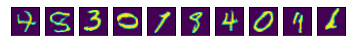

Generator Reconstruction Images


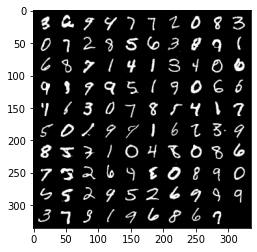

avg_is_score:	 6.837191
std_is_score:	 1.1787673
Epoch: [31] [ 100/ 468] D_loss: 0.17686988, G_loss: 0.70537233
Epoch: [31] [ 200/ 468] D_loss: 0.20414281, G_loss: 0.66307116
Epoch: [31] [ 300/ 468] D_loss: 0.13913384, G_loss: 0.65167964
Epoch: [31] [ 400/ 468] D_loss: 0.25295368, G_loss: 0.67597336


<Figure size 72x720 with 0 Axes>

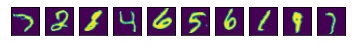

avg_is_score:	 6.2517657
std_is_score:	 0.70977026
Epoch: [32] [ 100/ 468] D_loss: 0.13825315, G_loss: 0.59578264
Epoch: [32] [ 200/ 468] D_loss: 0.19552319, G_loss: 0.55175072
Epoch: [32] [ 300/ 468] D_loss: 0.10458204, G_loss: 0.67434144
Epoch: [32] [ 400/ 468] D_loss: 0.11886631, G_loss: 0.63742656


<Figure size 72x720 with 0 Axes>

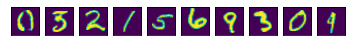

avg_is_score:	 6.052881
std_is_score:	 1.4414328
Epoch: [33] [ 100/ 468] D_loss: 0.10787190, G_loss: 0.65744537
Epoch: [33] [ 200/ 468] D_loss: 0.30185461, G_loss: 0.69156027
Epoch: [33] [ 300/ 468] D_loss: 0.18200764, G_loss: 0.65540999
Epoch: [33] [ 400/ 468] D_loss: 0.21782449, G_loss: 0.59965688


<Figure size 72x720 with 0 Axes>

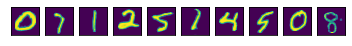

avg_is_score:	 5.9761114
std_is_score:	 0.97695076
Epoch: [34] [ 100/ 468] D_loss: 0.17242725, G_loss: 0.73548579
Epoch: [34] [ 200/ 468] D_loss: 0.20766494, G_loss: 0.65107322
Epoch: [34] [ 300/ 468] D_loss: 0.13800251, G_loss: 0.58631623
Epoch: [34] [ 400/ 468] D_loss: 0.19970578, G_loss: 0.61959112


<Figure size 72x720 with 0 Axes>

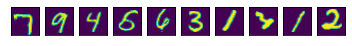

avg_is_score:	 6.8057885
std_is_score:	 0.67532426
Epoch: [35] [ 100/ 468] D_loss: 0.14666888, G_loss: 0.72810644
Epoch: [35] [ 200/ 468] D_loss: 0.12194425, G_loss: 0.67433310
Epoch: [35] [ 300/ 468] D_loss: 0.16555618, G_loss: 0.67618221
Epoch: [35] [ 400/ 468] D_loss: 0.11956216, G_loss: 0.65687895


<Figure size 72x720 with 0 Axes>

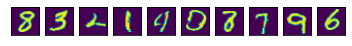

avg_is_score:	 5.92392
std_is_score:	 0.9142411
Epoch: [36] [ 100/ 468] D_loss: 0.09248498, G_loss: 0.66469324
Epoch: [36] [ 200/ 468] D_loss: 0.11905456, G_loss: 0.59711003
Epoch: [36] [ 300/ 468] D_loss: 0.25106436, G_loss: 0.56872678
Epoch: [36] [ 400/ 468] D_loss: 0.09388942, G_loss: 0.65329993


<Figure size 72x720 with 0 Axes>

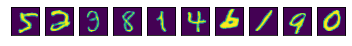

avg_is_score:	 5.918007
std_is_score:	 0.8586956
Epoch: [37] [ 100/ 468] D_loss: 0.16942096, G_loss: 0.69872785
Epoch: [37] [ 200/ 468] D_loss: 0.10107046, G_loss: 0.65259373
Epoch: [37] [ 300/ 468] D_loss: 0.10942740, G_loss: 0.71765351
Epoch: [37] [ 400/ 468] D_loss: 0.10773450, G_loss: 0.69651747


<Figure size 72x720 with 0 Axes>

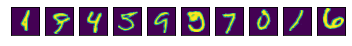

avg_is_score:	 6.832236
std_is_score:	 0.8525896
Epoch: [38] [ 100/ 468] D_loss: 0.12470495, G_loss: 0.66828847
Epoch: [38] [ 200/ 468] D_loss: 0.13990207, G_loss: 0.69310516
Epoch: [38] [ 300/ 468] D_loss: 0.36587489, G_loss: 0.57387578
Epoch: [38] [ 400/ 468] D_loss: 0.11827751, G_loss: 0.70307100


<Figure size 72x720 with 0 Axes>

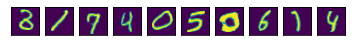

avg_is_score:	 6.148262
std_is_score:	 0.7038395
Epoch: [39] [ 100/ 468] D_loss: 0.08469712, G_loss: 0.67434788
Epoch: [39] [ 200/ 468] D_loss: 0.10079646, G_loss: 0.69343704
Epoch: [39] [ 300/ 468] D_loss: 0.14768322, G_loss: 0.60443765
Epoch: [39] [ 400/ 468] D_loss: 0.12566571, G_loss: 0.69139469


<Figure size 72x720 with 0 Axes>

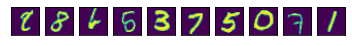

avg_is_score:	 6.4111853
std_is_score:	 0.79835856
Epoch: [40] [ 100/ 468] D_loss: 0.11391768, G_loss: 0.68945765
Epoch: [40] [ 200/ 468] D_loss: 0.11561396, G_loss: 0.69626200
Epoch: [40] [ 300/ 468] D_loss: 0.20589286, G_loss: 0.75214016
Epoch: [40] [ 400/ 468] D_loss: 0.11962529, G_loss: 0.71690512


<Figure size 72x720 with 0 Axes>

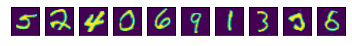

Generator Reconstruction Images


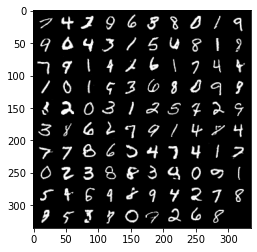

avg_is_score:	 6.503724
std_is_score:	 0.9115859
Epoch: [41] [ 100/ 468] D_loss: 0.14886963, G_loss: 0.58000612
Epoch: [41] [ 200/ 468] D_loss: 0.09064354, G_loss: 0.67186052
Epoch: [41] [ 300/ 468] D_loss: 0.10828087, G_loss: 0.64508998
Epoch: [41] [ 400/ 468] D_loss: 0.15083542, G_loss: 0.74407738


<Figure size 72x720 with 0 Axes>

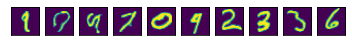

avg_is_score:	 6.4723105
std_is_score:	 0.82631713
Epoch: [42] [ 100/ 468] D_loss: 0.22463879, G_loss: 0.53879088
Epoch: [42] [ 200/ 468] D_loss: 0.09524222, G_loss: 0.64756376
Epoch: [42] [ 300/ 468] D_loss: 0.10575861, G_loss: 0.73371601
Epoch: [42] [ 400/ 468] D_loss: 0.09986854, G_loss: 0.69029844


<Figure size 72x720 with 0 Axes>

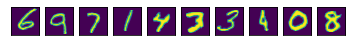

avg_is_score:	 6.561905
std_is_score:	 0.7271333
Epoch: [43] [ 100/ 468] D_loss: 0.13203989, G_loss: 0.72611219
Epoch: [43] [ 200/ 468] D_loss: 0.10654332, G_loss: 0.70727265
Epoch: [43] [ 300/ 468] D_loss: 0.10319896, G_loss: 0.67972606
Epoch: [43] [ 400/ 468] D_loss: 0.25926054, G_loss: 0.61441076


<Figure size 72x720 with 0 Axes>

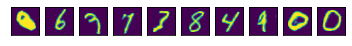

avg_is_score:	 5.860968
std_is_score:	 0.9080862
Epoch: [44] [ 100/ 468] D_loss: 0.08987284, G_loss: 0.68106925
Epoch: [44] [ 200/ 468] D_loss: 0.08474879, G_loss: 0.65635967
Epoch: [44] [ 300/ 468] D_loss: 0.11310503, G_loss: 0.68137282
Epoch: [44] [ 400/ 468] D_loss: 0.22581689, G_loss: 0.69453788


<Figure size 72x720 with 0 Axes>

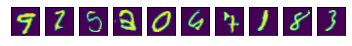

avg_is_score:	 6.607315
std_is_score:	 0.6162369
Epoch: [45] [ 100/ 468] D_loss: 0.10889890, G_loss: 0.68083489
Epoch: [45] [ 200/ 468] D_loss: 0.11855830, G_loss: 0.70557380
Epoch: [45] [ 300/ 468] D_loss: 0.10023497, G_loss: 0.59847170
Epoch: [45] [ 400/ 468] D_loss: 0.21174204, G_loss: 0.67250335


<Figure size 72x720 with 0 Axes>

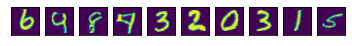

avg_is_score:	 6.6033163
std_is_score:	 0.84947485
Epoch: [46] [ 100/ 468] D_loss: 0.17243598, G_loss: 0.62217319
Epoch: [46] [ 200/ 468] D_loss: 0.23325378, G_loss: 0.58663428
Epoch: [46] [ 300/ 468] D_loss: 0.09873115, G_loss: 0.63058817
Epoch: [46] [ 400/ 468] D_loss: 0.12752452, G_loss: 0.73484075


<Figure size 72x720 with 0 Axes>

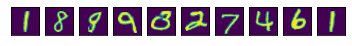

avg_is_score:	 5.8667383
std_is_score:	 0.7278643
Epoch: [47] [ 100/ 468] D_loss: 0.07927269, G_loss: 0.71881157
Epoch: [47] [ 200/ 468] D_loss: 0.15799180, G_loss: 0.58658111
Epoch: [47] [ 300/ 468] D_loss: 0.09940644, G_loss: 0.66867757
Epoch: [47] [ 400/ 468] D_loss: 0.12419793, G_loss: 0.65205652


<Figure size 72x720 with 0 Axes>

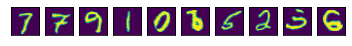

avg_is_score:	 6.17367
std_is_score:	 0.9642384
Epoch: [48] [ 100/ 468] D_loss: 0.09570044, G_loss: 0.72118294
Epoch: [48] [ 200/ 468] D_loss: 0.14696980, G_loss: 0.68251371
Epoch: [48] [ 300/ 468] D_loss: 0.11973721, G_loss: 0.70691800
Epoch: [48] [ 400/ 468] D_loss: 0.14511046, G_loss: 0.69781137


<Figure size 72x720 with 0 Axes>

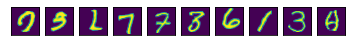

avg_is_score:	 6.099808
std_is_score:	 0.95361745
Epoch: [49] [ 100/ 468] D_loss: 0.17977524, G_loss: 0.54891002
Epoch: [49] [ 200/ 468] D_loss: 0.17573822, G_loss: 0.57720953
Epoch: [49] [ 300/ 468] D_loss: 0.14994675, G_loss: 0.60096157
Epoch: [49] [ 400/ 468] D_loss: 0.10605714, G_loss: 0.69243097


<Figure size 72x720 with 0 Axes>

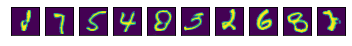

avg_is_score:	 7.0588064
std_is_score:	 1.017536
Epoch: [50] [ 100/ 468] D_loss: 0.13786167, G_loss: 0.74162865
Epoch: [50] [ 200/ 468] D_loss: 0.12181942, G_loss: 0.69034863
Epoch: [50] [ 300/ 468] D_loss: 0.15840837, G_loss: 0.68329644
Epoch: [50] [ 400/ 468] D_loss: 0.11572091, G_loss: 0.65200716


<Figure size 72x720 with 0 Axes>

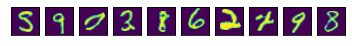

Generator Reconstruction Images


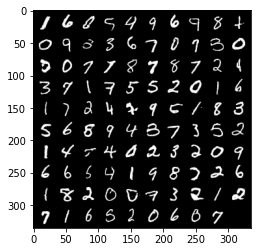

avg_is_score:	 6.1159697
std_is_score:	 0.78735584
Epoch: [51] [ 100/ 468] D_loss: 0.13108449, G_loss: 0.65499139
Epoch: [51] [ 200/ 468] D_loss: 0.08365991, G_loss: 0.70886803
Epoch: [51] [ 300/ 468] D_loss: 0.09360454, G_loss: 0.69678688
Epoch: [51] [ 400/ 468] D_loss: 0.07775069, G_loss: 0.70542735


<Figure size 72x720 with 0 Axes>

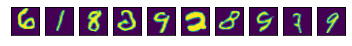

avg_is_score:	 5.99568
std_is_score:	 0.71841836
Epoch: [52] [ 100/ 468] D_loss: 0.13808057, G_loss: 0.73627955
Epoch: [52] [ 200/ 468] D_loss: 0.17502579, G_loss: 0.64679503
Epoch: [52] [ 300/ 468] D_loss: 0.08263522, G_loss: 0.65539682
Epoch: [52] [ 400/ 468] D_loss: 0.15827997, G_loss: 0.64863694


<Figure size 72x720 with 0 Axes>

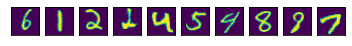

avg_is_score:	 6.272278
std_is_score:	 0.51023513
Epoch: [53] [ 100/ 468] D_loss: 0.16203710, G_loss: 0.57107514
Epoch: [53] [ 200/ 468] D_loss: 0.13481331, G_loss: 0.64982569
Epoch: [53] [ 300/ 468] D_loss: 0.12400267, G_loss: 0.62014335
Epoch: [53] [ 400/ 468] D_loss: 0.15886213, G_loss: 0.71736181


<Figure size 72x720 with 0 Axes>

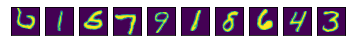

avg_is_score:	 5.720558
std_is_score:	 0.84776306
Epoch: [54] [ 100/ 468] D_loss: 0.10189998, G_loss: 0.68136847
Epoch: [54] [ 200/ 468] D_loss: 0.09932787, G_loss: 0.62182355
Epoch: [54] [ 300/ 468] D_loss: 0.18736982, G_loss: 0.59753120
Epoch: [54] [ 400/ 468] D_loss: 0.11658339, G_loss: 0.66975945


<Figure size 72x720 with 0 Axes>

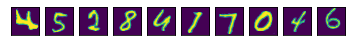

avg_is_score:	 6.547412
std_is_score:	 0.83661425
Epoch: [55] [ 100/ 468] D_loss: 0.09138318, G_loss: 0.72146773
Epoch: [55] [ 200/ 468] D_loss: 0.11441045, G_loss: 0.71222049
Epoch: [55] [ 300/ 468] D_loss: 0.14132497, G_loss: 0.72434187
Epoch: [55] [ 400/ 468] D_loss: 0.09085621, G_loss: 0.66108215


<Figure size 72x720 with 0 Axes>

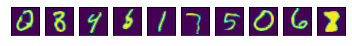

avg_is_score:	 6.4226236
std_is_score:	 0.5684234
Epoch: [56] [ 100/ 468] D_loss: 0.07332219, G_loss: 0.71634221
Epoch: [56] [ 200/ 468] D_loss: 0.13704008, G_loss: 0.73154259
Epoch: [56] [ 300/ 468] D_loss: 0.08797391, G_loss: 0.64339471
Epoch: [56] [ 400/ 468] D_loss: 0.11551529, G_loss: 0.74181581


<Figure size 72x720 with 0 Axes>

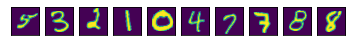

avg_is_score:	 6.3053737
std_is_score:	 0.69438887
Epoch: [57] [ 100/ 468] D_loss: 0.07223015, G_loss: 0.68046784
Epoch: [57] [ 200/ 468] D_loss: 0.12828329, G_loss: 0.72411668
Epoch: [57] [ 300/ 468] D_loss: 0.13997543, G_loss: 0.67067879
Epoch: [57] [ 400/ 468] D_loss: 0.17967188, G_loss: 0.75878394


<Figure size 72x720 with 0 Axes>

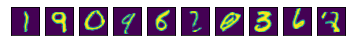

avg_is_score:	 5.835488
std_is_score:	 0.77806884
Epoch: [58] [ 100/ 468] D_loss: 0.12184611, G_loss: 0.72889054
Epoch: [58] [ 200/ 468] D_loss: 0.15244836, G_loss: 0.75232959
Epoch: [58] [ 300/ 468] D_loss: 0.07030110, G_loss: 0.70114470
Epoch: [58] [ 400/ 468] D_loss: 0.12304112, G_loss: 0.69626665


<Figure size 72x720 with 0 Axes>

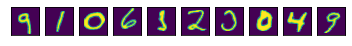

avg_is_score:	 6.3744035
std_is_score:	 0.8041724
Epoch: [59] [ 100/ 468] D_loss: 0.08894607, G_loss: 0.61259508
Epoch: [59] [ 200/ 468] D_loss: 0.14682782, G_loss: 0.61039126
Epoch: [59] [ 300/ 468] D_loss: 0.11916725, G_loss: 0.69049227
Epoch: [59] [ 400/ 468] D_loss: 0.10618454, G_loss: 0.70600283


<Figure size 72x720 with 0 Axes>

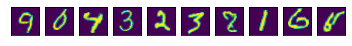

avg_is_score:	 6.0094213
std_is_score:	 0.59295005
Epoch: [60] [ 100/ 468] D_loss: 0.16366312, G_loss: 0.71882463
Epoch: [60] [ 200/ 468] D_loss: 0.11091366, G_loss: 0.72878599
Epoch: [60] [ 300/ 468] D_loss: 0.23413050, G_loss: 0.52701449
Epoch: [60] [ 400/ 468] D_loss: 0.08291113, G_loss: 0.63227719


<Figure size 72x720 with 0 Axes>

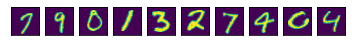

Generator Reconstruction Images


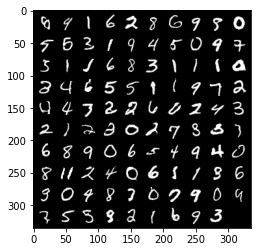

avg_is_score:	 6.8803506
std_is_score:	 0.76072955
Epoch: [61] [ 100/ 468] D_loss: 0.18366694, G_loss: 0.70999396
Epoch: [61] [ 200/ 468] D_loss: 0.16510162, G_loss: 0.63185894
Epoch: [61] [ 300/ 468] D_loss: 0.11366829, G_loss: 0.66342431
Epoch: [61] [ 400/ 468] D_loss: 0.22062613, G_loss: 0.50001824


<Figure size 72x720 with 0 Axes>

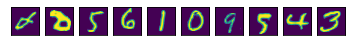

avg_is_score:	 5.8396606
std_is_score:	 0.78277326
Epoch: [62] [ 100/ 468] D_loss: 0.08663021, G_loss: 0.72204798
Epoch: [62] [ 200/ 468] D_loss: 0.08641026, G_loss: 0.75835949
Epoch: [62] [ 300/ 468] D_loss: 0.08602071, G_loss: 0.69691873
Epoch: [62] [ 400/ 468] D_loss: 0.13407466, G_loss: 0.72018921


<Figure size 72x720 with 0 Axes>

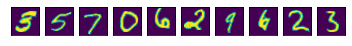

avg_is_score:	 6.0373855
std_is_score:	 0.7336238
Epoch: [63] [ 100/ 468] D_loss: 0.29015088, G_loss: 0.66042805
Epoch: [63] [ 200/ 468] D_loss: 0.09085298, G_loss: 0.63957971
Epoch: [63] [ 300/ 468] D_loss: 0.07819583, G_loss: 0.74324727
Epoch: [63] [ 400/ 468] D_loss: 0.16351478, G_loss: 0.72738814


<Figure size 72x720 with 0 Axes>

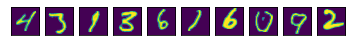

avg_is_score:	 6.905716
std_is_score:	 1.0391785
Epoch: [64] [ 100/ 468] D_loss: 0.11526953, G_loss: 0.76083738
Epoch: [64] [ 200/ 468] D_loss: 0.10559985, G_loss: 0.66866958
Epoch: [64] [ 300/ 468] D_loss: 0.10341533, G_loss: 0.69762832
Epoch: [64] [ 400/ 468] D_loss: 0.13239393, G_loss: 0.70769966


<Figure size 72x720 with 0 Axes>

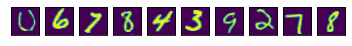

avg_is_score:	 6.160135
std_is_score:	 0.38674083
Epoch: [65] [ 100/ 468] D_loss: 0.07828733, G_loss: 0.71182239
Epoch: [65] [ 200/ 468] D_loss: 0.11853808, G_loss: 0.70144069
Epoch: [65] [ 300/ 468] D_loss: 0.10517123, G_loss: 0.66123837
Epoch: [65] [ 400/ 468] D_loss: 0.14240874, G_loss: 0.71963799


<Figure size 72x720 with 0 Axes>

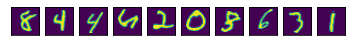

avg_is_score:	 5.9568458
std_is_score:	 0.90374184
Epoch: [66] [ 100/ 468] D_loss: 0.11156677, G_loss: 0.67303288
Epoch: [66] [ 200/ 468] D_loss: 0.10219611, G_loss: 0.68545628
Epoch: [66] [ 300/ 468] D_loss: 0.13208450, G_loss: 0.71673262
Epoch: [66] [ 400/ 468] D_loss: 0.15847750, G_loss: 0.58032620


<Figure size 72x720 with 0 Axes>

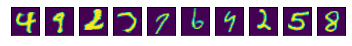

avg_is_score:	 6.1800523
std_is_score:	 0.6171459
Epoch: [67] [ 100/ 468] D_loss: 0.17402980, G_loss: 0.68186152
Epoch: [67] [ 200/ 468] D_loss: 0.11939974, G_loss: 0.71515524
Epoch: [67] [ 300/ 468] D_loss: 0.06668185, G_loss: 0.71032989
Epoch: [67] [ 400/ 468] D_loss: 0.11498390, G_loss: 0.65773547


<Figure size 72x720 with 0 Axes>

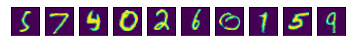

avg_is_score:	 6.019801
std_is_score:	 0.8520345
Epoch: [68] [ 100/ 468] D_loss: 0.11776258, G_loss: 0.66287631
Epoch: [68] [ 200/ 468] D_loss: 0.07242158, G_loss: 0.72722656
Epoch: [68] [ 300/ 468] D_loss: 0.23902090, G_loss: 0.46401149
Epoch: [68] [ 400/ 468] D_loss: 0.09302895, G_loss: 0.72546411


<Figure size 72x720 with 0 Axes>

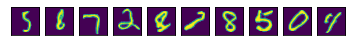

avg_is_score:	 5.8851395
std_is_score:	 0.6071672
Epoch: [69] [ 100/ 468] D_loss: 0.09915772, G_loss: 0.69592613
Epoch: [69] [ 200/ 468] D_loss: 0.11026576, G_loss: 0.74233842
Epoch: [69] [ 300/ 468] D_loss: 0.17015095, G_loss: 0.72238088
Epoch: [69] [ 400/ 468] D_loss: 0.10096467, G_loss: 0.74547505


<Figure size 72x720 with 0 Axes>

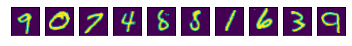

avg_is_score:	 5.6865125
std_is_score:	 0.87399703
Epoch: [70] [ 100/ 468] D_loss: 0.11688083, G_loss: 0.75642765
Epoch: [70] [ 200/ 468] D_loss: 0.19609624, G_loss: 0.74605161
Epoch: [70] [ 300/ 468] D_loss: 0.10206445, G_loss: 0.71570575
Epoch: [70] [ 400/ 468] D_loss: 0.10894663, G_loss: 0.74189055


<Figure size 72x720 with 0 Axes>

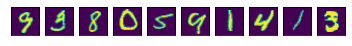

Generator Reconstruction Images


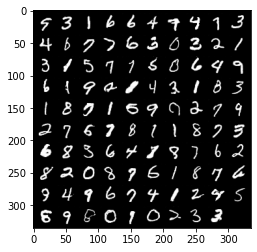

avg_is_score:	 6.6704283
std_is_score:	 0.74369204
Epoch: [71] [ 100/ 468] D_loss: 0.07638930, G_loss: 0.74396312
Epoch: [71] [ 200/ 468] D_loss: 0.09277935, G_loss: 0.75858855
Epoch: [71] [ 300/ 468] D_loss: 0.06486552, G_loss: 0.74477583
Epoch: [71] [ 400/ 468] D_loss: 0.07244223, G_loss: 0.75173622


<Figure size 72x720 with 0 Axes>

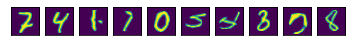

avg_is_score:	 6.4576316
std_is_score:	 0.6560302
Epoch: [72] [ 100/ 468] D_loss: 0.08260910, G_loss: 0.75096834
Epoch: [72] [ 200/ 468] D_loss: 0.10179560, G_loss: 0.69665349
Epoch: [72] [ 300/ 468] D_loss: 0.09711377, G_loss: 0.75466645
Epoch: [72] [ 400/ 468] D_loss: 0.08489818, G_loss: 0.73862362


<Figure size 72x720 with 0 Axes>

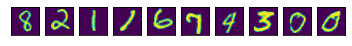

avg_is_score:	 5.9833307
std_is_score:	 0.5466016
Epoch: [73] [ 100/ 468] D_loss: 0.10972985, G_loss: 0.71984887
Epoch: [73] [ 200/ 468] D_loss: 0.11512526, G_loss: 0.70434040
Epoch: [73] [ 300/ 468] D_loss: 0.10126090, G_loss: 0.73876143
Epoch: [73] [ 400/ 468] D_loss: 0.06048919, G_loss: 0.71595967


<Figure size 72x720 with 0 Axes>

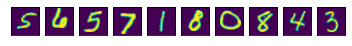

avg_is_score:	 6.471057
std_is_score:	 0.8108375
Epoch: [74] [ 100/ 468] D_loss: 0.13099152, G_loss: 0.77182102
Epoch: [74] [ 200/ 468] D_loss: 0.10710768, G_loss: 0.77038300
Epoch: [74] [ 300/ 468] D_loss: 0.09145691, G_loss: 0.73509073
Epoch: [74] [ 400/ 468] D_loss: 0.11200474, G_loss: 0.71901584


<Figure size 72x720 with 0 Axes>

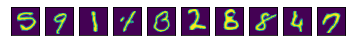

avg_is_score:	 6.137354
std_is_score:	 0.85888827
Epoch: [75] [ 100/ 468] D_loss: 0.19590811, G_loss: 0.66082329
Epoch: [75] [ 200/ 468] D_loss: 0.07499289, G_loss: 0.72278911
Epoch: [75] [ 300/ 468] D_loss: 0.08402059, G_loss: 0.77951515
Epoch: [75] [ 400/ 468] D_loss: 0.14811698, G_loss: 0.75168955


<Figure size 72x720 with 0 Axes>

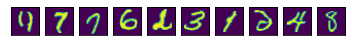

avg_is_score:	 6.3667574
std_is_score:	 0.7104392
Epoch: [76] [ 100/ 468] D_loss: 0.07251103, G_loss: 0.70780587
Epoch: [76] [ 200/ 468] D_loss: 0.08814019, G_loss: 0.71254539
Epoch: [76] [ 300/ 468] D_loss: 0.26974475, G_loss: 0.46378329
Epoch: [76] [ 400/ 468] D_loss: 0.10735513, G_loss: 0.72791964


<Figure size 72x720 with 0 Axes>

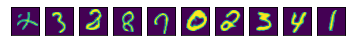

avg_is_score:	 6.088379
std_is_score:	 0.7872699
Epoch: [77] [ 100/ 468] D_loss: 0.07429431, G_loss: 0.73617166
Epoch: [77] [ 200/ 468] D_loss: 0.09165533, G_loss: 0.72575915
Epoch: [77] [ 300/ 468] D_loss: 0.09557687, G_loss: 0.69588518
Epoch: [77] [ 400/ 468] D_loss: 0.10481048, G_loss: 0.76007140


<Figure size 72x720 with 0 Axes>

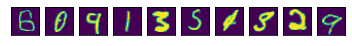

avg_is_score:	 6.857335
std_is_score:	 0.5591199
Epoch: [78] [ 100/ 468] D_loss: 0.07857160, G_loss: 0.78496647
Epoch: [78] [ 200/ 468] D_loss: 0.12198193, G_loss: 0.74240685
Epoch: [78] [ 300/ 468] D_loss: 0.07194697, G_loss: 0.71094334
Epoch: [78] [ 400/ 468] D_loss: 0.12682393, G_loss: 0.70519531


<Figure size 72x720 with 0 Axes>

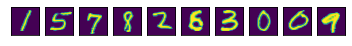

avg_is_score:	 5.715535
std_is_score:	 0.6407645
Epoch: [79] [ 100/ 468] D_loss: 0.12025779, G_loss: 0.71579182
Epoch: [79] [ 200/ 468] D_loss: 0.05670390, G_loss: 0.73349679
Epoch: [79] [ 300/ 468] D_loss: 0.09588821, G_loss: 0.75340533
Epoch: [79] [ 400/ 468] D_loss: 0.15864539, G_loss: 0.59982616


<Figure size 72x720 with 0 Axes>

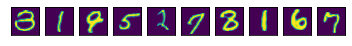

avg_is_score:	 5.802731
std_is_score:	 0.63927233
Epoch: [80] [ 100/ 468] D_loss: 0.08945720, G_loss: 0.67450732
Epoch: [80] [ 200/ 468] D_loss: 0.15638883, G_loss: 0.53153521
Epoch: [80] [ 300/ 468] D_loss: 0.17984968, G_loss: 0.59727806
Epoch: [80] [ 400/ 468] D_loss: 0.13504501, G_loss: 0.76078498


<Figure size 72x720 with 0 Axes>

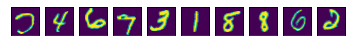

Generator Reconstruction Images


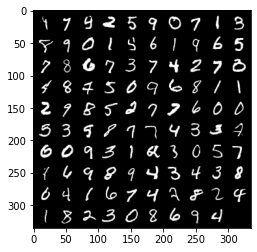

avg_is_score:	 6.7148867
std_is_score:	 0.977176
Epoch: [81] [ 100/ 468] D_loss: 0.09372482, G_loss: 0.69874811
Epoch: [81] [ 200/ 468] D_loss: 0.08631865, G_loss: 0.74588031
Epoch: [81] [ 300/ 468] D_loss: 0.05491814, G_loss: 0.70761961
Epoch: [81] [ 400/ 468] D_loss: 0.16712458, G_loss: 0.62120348


<Figure size 72x720 with 0 Axes>

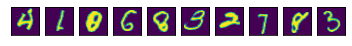

avg_is_score:	 5.9369497
std_is_score:	 0.67419165
Epoch: [82] [ 100/ 468] D_loss: 0.08333547, G_loss: 0.73518884
Epoch: [82] [ 200/ 468] D_loss: 0.15226330, G_loss: 0.70003617
Epoch: [82] [ 300/ 468] D_loss: 0.06832214, G_loss: 0.72967887
Epoch: [82] [ 400/ 468] D_loss: 0.09974377, G_loss: 0.71969950


<Figure size 72x720 with 0 Axes>

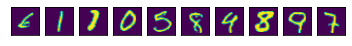

avg_is_score:	 6.162263
std_is_score:	 0.8162493
Epoch: [83] [ 100/ 468] D_loss: 0.07898003, G_loss: 0.71137977
Epoch: [83] [ 200/ 468] D_loss: 0.09307419, G_loss: 0.74817210
Epoch: [83] [ 300/ 468] D_loss: 0.07952057, G_loss: 0.72958994
Epoch: [83] [ 400/ 468] D_loss: 0.13308214, G_loss: 0.66787171


<Figure size 72x720 with 0 Axes>

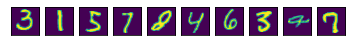

avg_is_score:	 6.187652
std_is_score:	 1.2801968
Epoch: [84] [ 100/ 468] D_loss: 0.13563721, G_loss: 0.76951069
Epoch: [84] [ 200/ 468] D_loss: 0.06787197, G_loss: 0.70779932
Epoch: [84] [ 300/ 468] D_loss: 0.11849866, G_loss: 0.76095831
Epoch: [84] [ 400/ 468] D_loss: 0.11514331, G_loss: 0.74045593


<Figure size 72x720 with 0 Axes>

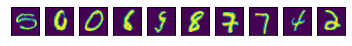

avg_is_score:	 5.9868784
std_is_score:	 1.134279
Epoch: [85] [ 100/ 468] D_loss: 0.08071104, G_loss: 0.76518369
Epoch: [85] [ 200/ 468] D_loss: 0.14311227, G_loss: 0.65357697
Epoch: [85] [ 300/ 468] D_loss: 0.08527119, G_loss: 0.67668867
Epoch: [85] [ 400/ 468] D_loss: 0.06692023, G_loss: 0.71662742


<Figure size 72x720 with 0 Axes>

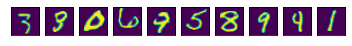

avg_is_score:	 6.2009096
std_is_score:	 0.39562294
Epoch: [86] [ 100/ 468] D_loss: 0.06431517, G_loss: 0.73362631
Epoch: [86] [ 200/ 468] D_loss: 0.11745724, G_loss: 0.69755566
Epoch: [86] [ 300/ 468] D_loss: 0.11319224, G_loss: 0.77470744
Epoch: [86] [ 400/ 468] D_loss: 0.10401563, G_loss: 0.73368597


<Figure size 72x720 with 0 Axes>

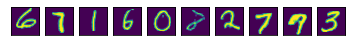

avg_is_score:	 6.2666593
std_is_score:	 0.720685
Epoch: [87] [ 100/ 468] D_loss: 0.11063601, G_loss: 0.76683307
Epoch: [87] [ 200/ 468] D_loss: 0.09196617, G_loss: 0.69430691
Epoch: [87] [ 300/ 468] D_loss: 0.13752137, G_loss: 0.62131155
Epoch: [87] [ 400/ 468] D_loss: 0.06578813, G_loss: 0.74521971


<Figure size 72x720 with 0 Axes>

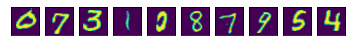

avg_is_score:	 6.9192634
std_is_score:	 0.9275178
Epoch: [88] [ 100/ 468] D_loss: 0.07770698, G_loss: 0.66619277
Epoch: [88] [ 200/ 468] D_loss: 0.10045911, G_loss: 0.69215310
Epoch: [88] [ 300/ 468] D_loss: 0.08371964, G_loss: 0.67381871
Epoch: [88] [ 400/ 468] D_loss: 0.11942329, G_loss: 0.74341691


<Figure size 72x720 with 0 Axes>

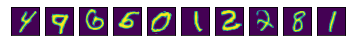

avg_is_score:	 6.239011
std_is_score:	 0.5211491
Epoch: [89] [ 100/ 468] D_loss: 0.10409274, G_loss: 0.73959255
Epoch: [89] [ 200/ 468] D_loss: 0.07796146, G_loss: 0.75700945
Epoch: [89] [ 300/ 468] D_loss: 0.13489975, G_loss: 0.67552114
Epoch: [89] [ 400/ 468] D_loss: 0.08492447, G_loss: 0.72535849


<Figure size 72x720 with 0 Axes>

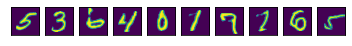

avg_is_score:	 6.7685075
std_is_score:	 0.74251527
Epoch: [90] [ 100/ 468] D_loss: 0.09304555, G_loss: 0.75828445
Epoch: [90] [ 200/ 468] D_loss: 0.06522904, G_loss: 0.76491487
Epoch: [90] [ 300/ 468] D_loss: 0.11959316, G_loss: 0.68930495
Epoch: [90] [ 400/ 468] D_loss: 0.06649062, G_loss: 0.74854898


<Figure size 72x720 with 0 Axes>

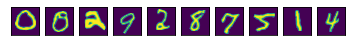

Generator Reconstruction Images


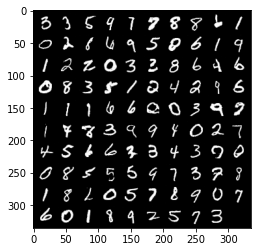

avg_is_score:	 6.3405466
std_is_score:	 0.72798455
Epoch: [91] [ 100/ 468] D_loss: 0.12670982, G_loss: 0.76812124
Epoch: [91] [ 200/ 468] D_loss: 0.09032698, G_loss: 0.71791470
Epoch: [91] [ 300/ 468] D_loss: 0.11192736, G_loss: 0.65949887
Epoch: [91] [ 400/ 468] D_loss: 0.14211592, G_loss: 0.75554240


<Figure size 72x720 with 0 Axes>

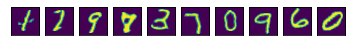

avg_is_score:	 6.7021484
std_is_score:	 0.65566
Epoch: [92] [ 100/ 468] D_loss: 0.11844656, G_loss: 0.69706881
Epoch: [92] [ 200/ 468] D_loss: 0.11898372, G_loss: 0.75470018
Epoch: [92] [ 300/ 468] D_loss: 0.12364924, G_loss: 0.78322375
Epoch: [92] [ 400/ 468] D_loss: 0.28083289, G_loss: 0.60418141


<Figure size 72x720 with 0 Axes>

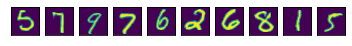

avg_is_score:	 5.987998
std_is_score:	 1.2238332
Epoch: [93] [ 100/ 468] D_loss: 0.09997489, G_loss: 0.66850483
Epoch: [93] [ 200/ 468] D_loss: 0.10389383, G_loss: 0.63500035
Epoch: [93] [ 300/ 468] D_loss: 0.09335722, G_loss: 0.75661284
Epoch: [93] [ 400/ 468] D_loss: 0.09194263, G_loss: 0.73238528


<Figure size 72x720 with 0 Axes>

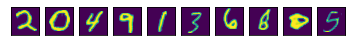

avg_is_score:	 6.224605
std_is_score:	 1.1736538
Epoch: [94] [ 100/ 468] D_loss: 0.06940372, G_loss: 0.76667428
Epoch: [94] [ 200/ 468] D_loss: 0.14186344, G_loss: 0.66459608
Epoch: [94] [ 300/ 468] D_loss: 0.09564003, G_loss: 0.64991862
Epoch: [94] [ 400/ 468] D_loss: 0.08400512, G_loss: 0.67740226


<Figure size 72x720 with 0 Axes>

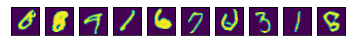

avg_is_score:	 6.4771256
std_is_score:	 1.049031
Epoch: [95] [ 100/ 468] D_loss: 0.07586630, G_loss: 0.74154860
Epoch: [95] [ 200/ 468] D_loss: 0.11275987, G_loss: 0.76803637
Epoch: [95] [ 300/ 468] D_loss: 0.14531279, G_loss: 0.71520346
Epoch: [95] [ 400/ 468] D_loss: 0.07189822, G_loss: 0.74142265


<Figure size 72x720 with 0 Axes>

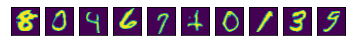

avg_is_score:	 6.741603
std_is_score:	 0.83716905
Epoch: [96] [ 100/ 468] D_loss: 0.11003162, G_loss: 0.77391422
Epoch: [96] [ 200/ 468] D_loss: 0.08947422, G_loss: 0.69490761
Epoch: [96] [ 300/ 468] D_loss: 0.06456525, G_loss: 0.71794534
Epoch: [96] [ 400/ 468] D_loss: 0.06967227, G_loss: 0.77346051


<Figure size 72x720 with 0 Axes>

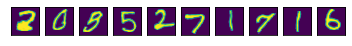

avg_is_score:	 6.358541
std_is_score:	 0.6360382
Epoch: [97] [ 100/ 468] D_loss: 0.10731162, G_loss: 0.72432268
Epoch: [97] [ 200/ 468] D_loss: 0.12251578, G_loss: 0.74557590
Epoch: [97] [ 300/ 468] D_loss: 0.15688437, G_loss: 0.66697168
Epoch: [97] [ 400/ 468] D_loss: 0.10866792, G_loss: 0.72232729


<Figure size 72x720 with 0 Axes>

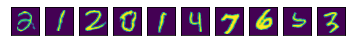

avg_is_score:	 6.28851
std_is_score:	 0.7911438
Epoch: [98] [ 100/ 468] D_loss: 0.07343534, G_loss: 0.75744206
Epoch: [98] [ 200/ 468] D_loss: 0.05585698, G_loss: 0.73258102
Epoch: [98] [ 300/ 468] D_loss: 0.11907467, G_loss: 0.70811009
Epoch: [98] [ 400/ 468] D_loss: 0.06643819, G_loss: 0.72066367


<Figure size 72x720 with 0 Axes>

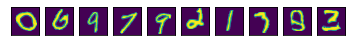

avg_is_score:	 6.411223
std_is_score:	 0.8062083
Epoch: [99] [ 100/ 468] D_loss: 0.07257311, G_loss: 0.75377917
Epoch: [99] [ 200/ 468] D_loss: 0.07644757, G_loss: 0.72609556
Epoch: [99] [ 300/ 468] D_loss: 0.08196761, G_loss: 0.76000881
Epoch: [99] [ 400/ 468] D_loss: 0.14726889, G_loss: 0.72178078


<Figure size 72x720 with 0 Axes>

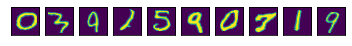

avg_is_score:	 6.648423
std_is_score:	 0.62657166
Epoch: [100] [ 100/ 468] D_loss: 0.07775789, G_loss: 0.72646725
Epoch: [100] [ 200/ 468] D_loss: 0.07909847, G_loss: 0.75642675
Epoch: [100] [ 300/ 468] D_loss: 0.08456242, G_loss: 0.69047427
Epoch: [100] [ 400/ 468] D_loss: 0.10003544, G_loss: 0.72504306


<Figure size 72x720 with 0 Axes>

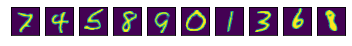

Generator Reconstruction Images


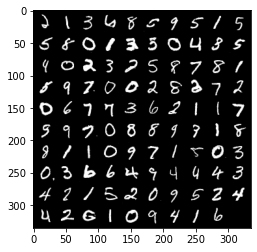

avg_is_score:	 6.060478
std_is_score:	 0.5733346
Training finished!


In [ ]:
import time
print("10 LATENT DIMENIONS")
params = {'beta1': 0.05, 'beta2': 0.999,'lr_g':0.0002,'lr_d':0.0002,'max_epochs':100}
params['z_dim'] = 10
params['base_size'] = 128

gan = GAN(params)
gan.train()

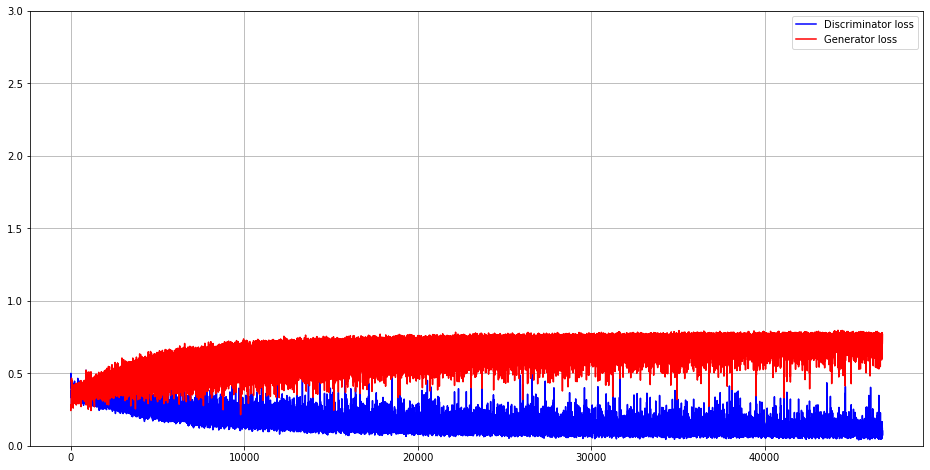

In [ ]:
plt.figure(figsize=(16,8))
s=plt.plot(gan.train_hist['D_loss'],c='b')
s=plt.plot(gan.train_hist['G_loss'],c='r')
s = plt.ylim((0,3))
s = plt.grid()
s=plt.legend(('Discriminator loss','Generator loss'))

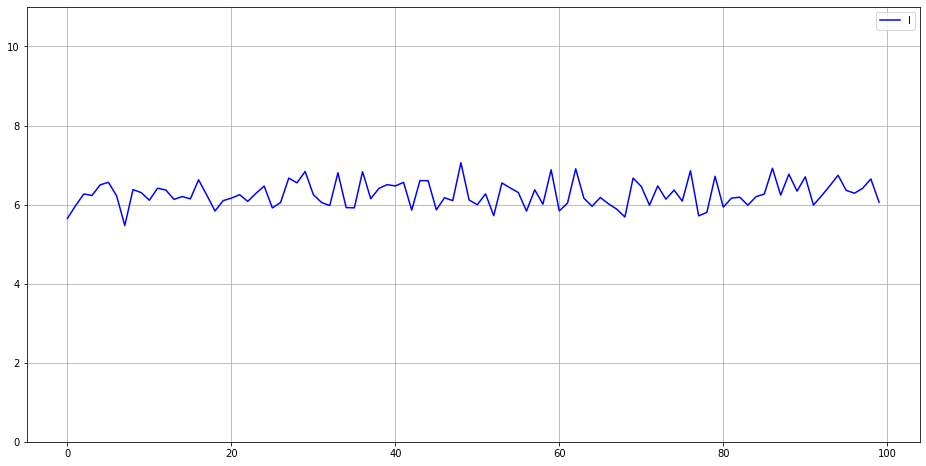

In [ ]:
plt.figure(figsize=(16,8))
s=plt.plot(gan.train_hist['IS_score'],c='b')
s = plt.ylim((0,11))
s = plt.grid()
s=plt.legend(('Inception Score'))

1 LATENT DIMENION
training start!!
Epoch: [ 1] [ 100/ 468] D_loss: 0.35226905, G_loss: 0.33789831
Epoch: [ 1] [ 200/ 468] D_loss: 0.27480343, G_loss: 0.35229236
Epoch: [ 1] [ 300/ 468] D_loss: 0.15787140, G_loss: 0.37852728
Epoch: [ 1] [ 400/ 468] D_loss: 0.22905003, G_loss: 0.47637051


<Figure size 72x720 with 0 Axes>

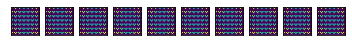

avg_is_score:	 3.5433216
std_is_score:	 0.55503196
Epoch: [ 2] [ 100/ 468] D_loss: 0.07575931, G_loss: 0.48765993
Epoch: [ 2] [ 200/ 468] D_loss: 0.08168275, G_loss: 0.54777735
Epoch: [ 2] [ 300/ 468] D_loss: 0.05638843, G_loss: 0.55878305
Epoch: [ 2] [ 400/ 468] D_loss: 0.07663900, G_loss: 0.51626855


<Figure size 72x720 with 0 Axes>

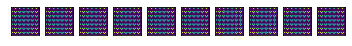

avg_is_score:	 3.149217
std_is_score:	 0.75032103
Epoch: [ 3] [ 100/ 468] D_loss: 0.02577459, G_loss: 0.61754596
Epoch: [ 3] [ 200/ 468] D_loss: 0.01350991, G_loss: 0.65145224
Epoch: [ 3] [ 300/ 468] D_loss: 0.01288972, G_loss: 0.68054926
Epoch: [ 3] [ 400/ 468] D_loss: 0.01541128, G_loss: 0.64679062


<Figure size 72x720 with 0 Axes>

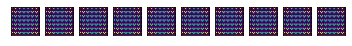

avg_is_score:	 2.6255288
std_is_score:	 0.91871154
Epoch: [ 4] [ 100/ 468] D_loss: 0.01043273, G_loss: 0.66356009
Epoch: [ 4] [ 200/ 468] D_loss: 0.02096891, G_loss: 0.66017252
Epoch: [ 4] [ 300/ 468] D_loss: 0.00797947, G_loss: 0.68946862
Epoch: [ 4] [ 400/ 468] D_loss: 0.01353220, G_loss: 0.71636701


<Figure size 72x720 with 0 Axes>

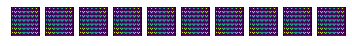

avg_is_score:	 2.147662
std_is_score:	 0.45719853
Epoch: [ 5] [ 100/ 468] D_loss: 0.00644728, G_loss: 0.70376348
Epoch: [ 5] [ 200/ 468] D_loss: 0.01350731, G_loss: 0.72746736
Epoch: [ 5] [ 300/ 468] D_loss: 0.00596641, G_loss: 0.72807705
Epoch: [ 5] [ 400/ 468] D_loss: 0.01110739, G_loss: 0.62278998


<Figure size 72x720 with 0 Axes>

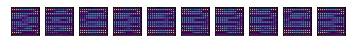

avg_is_score:	 3.5210595
std_is_score:	 0.35965994
Epoch: [ 6] [ 100/ 468] D_loss: 0.00357531, G_loss: 0.75183100
Epoch: [ 6] [ 200/ 468] D_loss: 0.00352276, G_loss: 0.73777020
Epoch: [ 6] [ 300/ 468] D_loss: 0.00689443, G_loss: 0.73415244
Epoch: [ 6] [ 400/ 468] D_loss: 0.01063119, G_loss: 0.76216388


<Figure size 72x720 with 0 Axes>

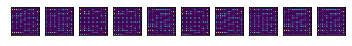

avg_is_score:	 3.7382114
std_is_score:	 0.34291545
Epoch: [ 7] [ 100/ 468] D_loss: 0.00382857, G_loss: 0.73524064
Epoch: [ 7] [ 200/ 468] D_loss: 0.00643273, G_loss: 0.71204960
Epoch: [ 7] [ 300/ 468] D_loss: 0.00454624, G_loss: 0.72669882
Epoch: [ 7] [ 400/ 468] D_loss: 0.00305753, G_loss: 0.73776376


<Figure size 72x720 with 0 Axes>

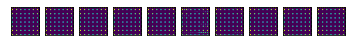

avg_is_score:	 2.5525496
std_is_score:	 0.58601046
Epoch: [ 8] [ 100/ 468] D_loss: 0.00352529, G_loss: 0.74049902
Epoch: [ 8] [ 200/ 468] D_loss: 0.00463415, G_loss: 0.74039829
Epoch: [ 8] [ 300/ 468] D_loss: 0.00520288, G_loss: 0.72563541
Epoch: [ 8] [ 400/ 468] D_loss: 0.00554146, G_loss: 0.75372422


<Figure size 72x720 with 0 Axes>

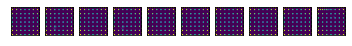

avg_is_score:	 2.5985732
std_is_score:	 0.33143964
Epoch: [ 9] [ 100/ 468] D_loss: 0.00477009, G_loss: 0.75977468
Epoch: [ 9] [ 200/ 468] D_loss: 0.01023243, G_loss: 0.76183689
Epoch: [ 9] [ 300/ 468] D_loss: 0.00311483, G_loss: 0.76805747
Epoch: [ 9] [ 400/ 468] D_loss: 0.00726082, G_loss: 0.74978757


<Figure size 72x720 with 0 Axes>

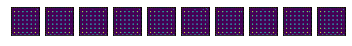

avg_is_score:	 2.14508
std_is_score:	 0.4434108
Epoch: [10] [ 100/ 468] D_loss: 0.00651685, G_loss: 0.72878385
Epoch: [10] [ 200/ 468] D_loss: 0.01511341, G_loss: 0.73137623
Epoch: [10] [ 300/ 468] D_loss: 0.00503504, G_loss: 0.74861896
Epoch: [10] [ 400/ 468] D_loss: 0.13408478, G_loss: 0.36394519


<Figure size 72x720 with 0 Axes>

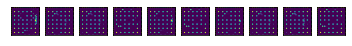

Generator Reconstruction Images


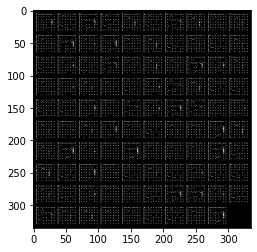

avg_is_score:	 3.3754668
std_is_score:	 0.41781452
Epoch: [11] [ 100/ 468] D_loss: 0.02036073, G_loss: 0.79169858
Epoch: [11] [ 200/ 468] D_loss: 0.00358626, G_loss: 0.77172971
Epoch: [11] [ 300/ 468] D_loss: 0.00245914, G_loss: 0.78032744
Epoch: [11] [ 400/ 468] D_loss: 0.01187939, G_loss: 0.77645326


<Figure size 72x720 with 0 Axes>

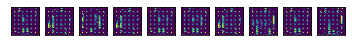

avg_is_score:	 4.2668753
std_is_score:	 0.867575
Epoch: [12] [ 100/ 468] D_loss: 0.03607490, G_loss: 0.75274920
Epoch: [12] [ 200/ 468] D_loss: 0.00370508, G_loss: 0.77007347
Epoch: [12] [ 300/ 468] D_loss: 0.00468745, G_loss: 0.77202517
Epoch: [12] [ 400/ 468] D_loss: 0.00337992, G_loss: 0.76658702


<Figure size 72x720 with 0 Axes>

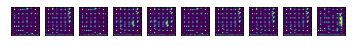

avg_is_score:	 3.3990211
std_is_score:	 0.40039906
Epoch: [13] [ 100/ 468] D_loss: 0.00855047, G_loss: 0.75260955
Epoch: [13] [ 200/ 468] D_loss: 0.00879853, G_loss: 0.74688184
Epoch: [13] [ 300/ 468] D_loss: 0.00655882, G_loss: 0.73170155
Epoch: [13] [ 400/ 468] D_loss: 0.00525902, G_loss: 0.76364470


<Figure size 72x720 with 0 Axes>

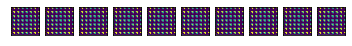

avg_is_score:	 2.8355203
std_is_score:	 0.7123778
Epoch: [14] [ 100/ 468] D_loss: 0.00323024, G_loss: 0.75619441
Epoch: [14] [ 200/ 468] D_loss: 0.00320994, G_loss: 0.76253438
Epoch: [14] [ 300/ 468] D_loss: 0.00454090, G_loss: 0.77229637
Epoch: [14] [ 400/ 468] D_loss: 0.00288210, G_loss: 0.75740463


<Figure size 72x720 with 0 Axes>

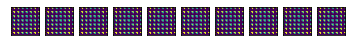

avg_is_score:	 2.170523
std_is_score:	 0.50457895
Epoch: [15] [ 100/ 468] D_loss: 0.00253301, G_loss: 0.76479256
Epoch: [15] [ 200/ 468] D_loss: 0.00213681, G_loss: 0.75966102
Epoch: [15] [ 300/ 468] D_loss: 0.00400345, G_loss: 0.76157033
Epoch: [15] [ 400/ 468] D_loss: 0.00265921, G_loss: 0.76288158


<Figure size 72x720 with 0 Axes>

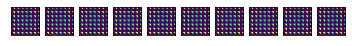

avg_is_score:	 2.8804824
std_is_score:	 0.53530157
Epoch: [16] [ 100/ 468] D_loss: 0.00783038, G_loss: 0.73221290
Epoch: [16] [ 200/ 468] D_loss: 0.00299482, G_loss: 0.76393241
Epoch: [16] [ 300/ 468] D_loss: 0.00357923, G_loss: 0.77178133
Epoch: [16] [ 400/ 468] D_loss: 0.00386645, G_loss: 0.76311135


<Figure size 72x720 with 0 Axes>

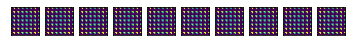

avg_is_score:	 2.5807087
std_is_score:	 0.58245564
Epoch: [17] [ 100/ 468] D_loss: 0.00623341, G_loss: 0.78314668
Epoch: [17] [ 200/ 468] D_loss: 0.00488419, G_loss: 0.76396418
Epoch: [17] [ 300/ 468] D_loss: 0.00250314, G_loss: 0.77654785
Epoch: [17] [ 400/ 468] D_loss: 0.01193427, G_loss: 0.78812408


<Figure size 72x720 with 0 Axes>

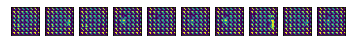

avg_is_score:	 3.6576164
std_is_score:	 0.41977066
Epoch: [18] [ 100/ 468] D_loss: 0.01147188, G_loss: 0.77787989
Epoch: [18] [ 200/ 468] D_loss: 0.00707602, G_loss: 0.77336752
Epoch: [18] [ 300/ 468] D_loss: 0.00299136, G_loss: 0.76389241
Epoch: [18] [ 400/ 468] D_loss: 0.00461818, G_loss: 0.76725107


<Figure size 72x720 with 0 Axes>

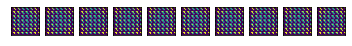

avg_is_score:	 2.988613
std_is_score:	 0.6973795
Epoch: [19] [ 100/ 468] D_loss: 0.00472142, G_loss: 0.74616188
Epoch: [19] [ 200/ 468] D_loss: 0.00358315, G_loss: 0.75736272
Epoch: [19] [ 300/ 468] D_loss: 0.00203663, G_loss: 0.77275217
Epoch: [19] [ 400/ 468] D_loss: 0.00277421, G_loss: 0.76678187


<Figure size 72x720 with 0 Axes>

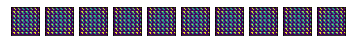

avg_is_score:	 2.6771483
std_is_score:	 0.654338
Epoch: [20] [ 100/ 468] D_loss: 0.00187861, G_loss: 0.77303243
Epoch: [20] [ 200/ 468] D_loss: 0.00177655, G_loss: 0.77832210
Epoch: [20] [ 300/ 468] D_loss: 0.00254042, G_loss: 0.78294027
Epoch: [20] [ 400/ 468] D_loss: 0.00541721, G_loss: 0.76979542


<Figure size 72x720 with 0 Axes>

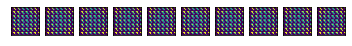

Generator Reconstruction Images


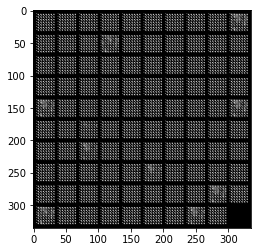

avg_is_score:	 3.2954793
std_is_score:	 0.49138054
Epoch: [21] [ 100/ 468] D_loss: 0.00956484, G_loss: 0.77772921
Epoch: [21] [ 200/ 468] D_loss: 0.00205774, G_loss: 0.78214061
Epoch: [21] [ 300/ 468] D_loss: 0.00339228, G_loss: 0.78025842
Epoch: [21] [ 400/ 468] D_loss: 0.00210883, G_loss: 0.78244376


<Figure size 72x720 with 0 Axes>

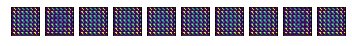

avg_is_score:	 2.8002474
std_is_score:	 0.9024862
Epoch: [22] [ 100/ 468] D_loss: 0.00325905, G_loss: 0.77690530
Epoch: [22] [ 200/ 468] D_loss: 0.00122637, G_loss: 0.78717315
Epoch: [22] [ 300/ 468] D_loss: 0.00379189, G_loss: 0.77599436
Epoch: [22] [ 400/ 468] D_loss: 0.00386097, G_loss: 0.78913653


<Figure size 72x720 with 0 Axes>

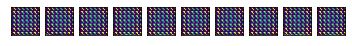

avg_is_score:	 2.9729962
std_is_score:	 0.456987
Epoch: [23] [ 100/ 468] D_loss: 0.00236840, G_loss: 0.78286242
Epoch: [23] [ 200/ 468] D_loss: 0.00190648, G_loss: 0.78880769
Epoch: [23] [ 300/ 468] D_loss: 0.00178147, G_loss: 0.78313601
Epoch: [23] [ 400/ 468] D_loss: 0.00165556, G_loss: 0.78167677


<Figure size 72x720 with 0 Axes>

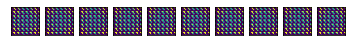

avg_is_score:	 2.5078464
std_is_score:	 0.41955757
Epoch: [24] [ 100/ 468] D_loss: 0.00463360, G_loss: 0.77203274
Epoch: [24] [ 200/ 468] D_loss: 0.00256585, G_loss: 0.77259326
Epoch: [24] [ 300/ 468] D_loss: 0.00222994, G_loss: 0.77327222
Epoch: [24] [ 400/ 468] D_loss: 0.00176675, G_loss: 0.76487529


<Figure size 72x720 with 0 Axes>

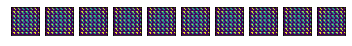

avg_is_score:	 2.4516335
std_is_score:	 0.7905002
Epoch: [25] [ 100/ 468] D_loss: 0.00164318, G_loss: 0.78115803
Epoch: [25] [ 200/ 468] D_loss: 0.00186969, G_loss: 0.77960050
Epoch: [25] [ 300/ 468] D_loss: 0.00120262, G_loss: 0.78420562
Epoch: [25] [ 400/ 468] D_loss: 0.04983199, G_loss: 0.28525630


<Figure size 72x720 with 0 Axes>

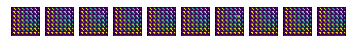

avg_is_score:	 1.8576138
std_is_score:	 0.29272762
Epoch: [26] [ 100/ 468] D_loss: 0.00219385, G_loss: 0.77962101
Epoch: [26] [ 200/ 468] D_loss: 0.00222074, G_loss: 0.78184664
Epoch: [26] [ 300/ 468] D_loss: 0.00161699, G_loss: 0.78770375
Epoch: [26] [ 400/ 468] D_loss: 0.00197981, G_loss: 0.79155481


<Figure size 72x720 with 0 Axes>

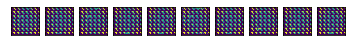

avg_is_score:	 3.089538
std_is_score:	 0.4210405
Epoch: [27] [ 100/ 468] D_loss: 0.00676978, G_loss: 0.78918433
Epoch: [27] [ 200/ 468] D_loss: 0.00222177, G_loss: 0.78648686
Epoch: [27] [ 300/ 468] D_loss: 0.00121237, G_loss: 0.78875899
Epoch: [27] [ 400/ 468] D_loss: 0.00151506, G_loss: 0.79483676


<Figure size 72x720 with 0 Axes>

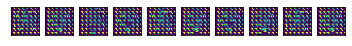

avg_is_score:	 3.6015759
std_is_score:	 0.6526813
Epoch: [28] [ 100/ 468] D_loss: 0.00288060, G_loss: 0.79365522
Epoch: [28] [ 200/ 468] D_loss: 0.00253441, G_loss: 0.79386312
Epoch: [28] [ 300/ 468] D_loss: 0.00546392, G_loss: 0.79041564
Epoch: [28] [ 400/ 468] D_loss: 0.00308968, G_loss: 0.77366203


<Figure size 72x720 with 0 Axes>

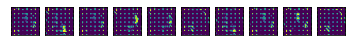

avg_is_score:	 4.2004576
std_is_score:	 0.3915747
Epoch: [29] [ 100/ 468] D_loss: 0.01886465, G_loss: 0.75708514
Epoch: [29] [ 200/ 468] D_loss: 0.00243990, G_loss: 0.76226419
Epoch: [29] [ 300/ 468] D_loss: 0.00254426, G_loss: 0.76507539
Epoch: [29] [ 400/ 468] D_loss: 0.00173852, G_loss: 0.77662468


<Figure size 72x720 with 0 Axes>

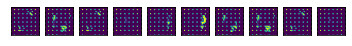

avg_is_score:	 3.441096
std_is_score:	 0.764934
Epoch: [30] [ 100/ 468] D_loss: 0.00137383, G_loss: 0.78500891
Epoch: [30] [ 200/ 468] D_loss: 0.00180485, G_loss: 0.78051108
Epoch: [30] [ 300/ 468] D_loss: 0.00246444, G_loss: 0.78154582
Epoch: [30] [ 400/ 468] D_loss: 0.00108430, G_loss: 0.78417879


<Figure size 72x720 with 0 Axes>

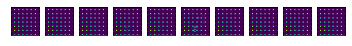

Generator Reconstruction Images


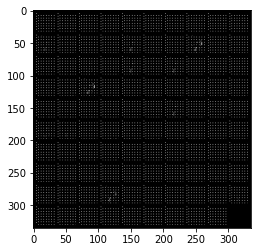

avg_is_score:	 3.209264
std_is_score:	 0.75668716
Epoch: [31] [ 100/ 468] D_loss: 0.01925798, G_loss: 0.77562559
Epoch: [31] [ 200/ 468] D_loss: 0.00122439, G_loss: 0.78091002
Epoch: [31] [ 300/ 468] D_loss: 0.00109746, G_loss: 0.78377980
Epoch: [31] [ 400/ 468] D_loss: 0.00201528, G_loss: 0.76832187


<Figure size 72x720 with 0 Axes>

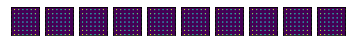

avg_is_score:	 2.0709567
std_is_score:	 0.33295798
Epoch: [32] [ 100/ 468] D_loss: 0.00518187, G_loss: 0.77564955
Epoch: [32] [ 200/ 468] D_loss: 0.00214850, G_loss: 0.78821999
Epoch: [32] [ 300/ 468] D_loss: 0.00275367, G_loss: 0.76202738
Epoch: [32] [ 400/ 468] D_loss: 0.00129857, G_loss: 0.76940191


<Figure size 72x720 with 0 Axes>

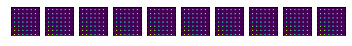

avg_is_score:	 1.3070983
std_is_score:	 0.08882385
Epoch: [33] [ 100/ 468] D_loss: 0.00238845, G_loss: 0.75538218
Epoch: [33] [ 200/ 468] D_loss: 0.00145170, G_loss: 0.78021604
Epoch: [33] [ 300/ 468] D_loss: 0.00109174, G_loss: 0.77738893
Epoch: [33] [ 400/ 468] D_loss: 0.00101985, G_loss: 0.78490424


<Figure size 72x720 with 0 Axes>

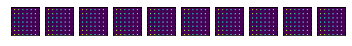

avg_is_score:	 1.8199784
std_is_score:	 0.2841215
Epoch: [34] [ 100/ 468] D_loss: 0.00119548, G_loss: 0.78920019
Epoch: [34] [ 200/ 468] D_loss: 0.00255354, G_loss: 0.77064425
Epoch: [34] [ 300/ 468] D_loss: 0.00244271, G_loss: 0.74816692
Epoch: [34] [ 400/ 468] D_loss: 0.00216496, G_loss: 0.77976429


<Figure size 72x720 with 0 Axes>

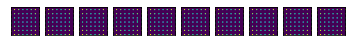

avg_is_score:	 1.7746788
std_is_score:	 0.51727074
Epoch: [35] [ 100/ 468] D_loss: 0.00161455, G_loss: 0.77841967
Epoch: [35] [ 200/ 468] D_loss: 0.00147280, G_loss: 0.77578884
Epoch: [35] [ 300/ 468] D_loss: 0.00216194, G_loss: 0.79054135
Epoch: [35] [ 400/ 468] D_loss: 0.00145364, G_loss: 0.78873432


<Figure size 72x720 with 0 Axes>

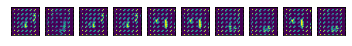

avg_is_score:	 2.8910303
std_is_score:	 0.39014104
Epoch: [36] [ 100/ 468] D_loss: 0.03616788, G_loss: 0.64179897
Epoch: [36] [ 200/ 468] D_loss: 0.00210470, G_loss: 0.79338992
Epoch: [36] [ 300/ 468] D_loss: 0.00089548, G_loss: 0.79615057
Epoch: [36] [ 400/ 468] D_loss: 0.00109024, G_loss: 0.78974903


<Figure size 72x720 with 0 Axes>

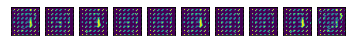

avg_is_score:	 2.710364
std_is_score:	 0.27068707
Epoch: [37] [ 100/ 468] D_loss: 0.00213900, G_loss: 0.79072595
Epoch: [37] [ 200/ 468] D_loss: 0.00098714, G_loss: 0.78867638
Epoch: [37] [ 300/ 468] D_loss: 0.00086426, G_loss: 0.79335570
Epoch: [37] [ 400/ 468] D_loss: 0.00074216, G_loss: 0.79878199


<Figure size 72x720 with 0 Axes>

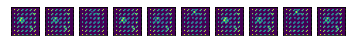

avg_is_score:	 3.0842206
std_is_score:	 0.43949005
Epoch: [38] [ 100/ 468] D_loss: 0.00114258, G_loss: 0.79016542
Epoch: [38] [ 200/ 468] D_loss: 0.00081336, G_loss: 0.79454726
Epoch: [38] [ 300/ 468] D_loss: 0.00104710, G_loss: 0.79529196
Epoch: [38] [ 400/ 468] D_loss: 0.00115856, G_loss: 0.78884542


<Figure size 72x720 with 0 Axes>

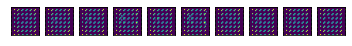

avg_is_score:	 2.6384645
std_is_score:	 0.36981595
Epoch: [39] [ 100/ 468] D_loss: 0.00089119, G_loss: 0.79503071
Epoch: [39] [ 200/ 468] D_loss: 0.00046136, G_loss: 0.79602647
Epoch: [39] [ 300/ 468] D_loss: 0.00481354, G_loss: 0.77823877
Epoch: [39] [ 400/ 468] D_loss: 0.00175992, G_loss: 0.79565001


<Figure size 72x720 with 0 Axes>

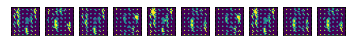

avg_is_score:	 4.3549604
std_is_score:	 0.44886726
Epoch: [40] [ 100/ 468] D_loss: 0.00155456, G_loss: 0.79430240
Epoch: [40] [ 200/ 468] D_loss: 0.00150630, G_loss: 0.79147518
Epoch: [40] [ 300/ 468] D_loss: 0.00135025, G_loss: 0.78796810
Epoch: [40] [ 400/ 468] D_loss: 0.00336136, G_loss: 0.77173209


<Figure size 72x720 with 0 Axes>

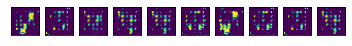

Generator Reconstruction Images


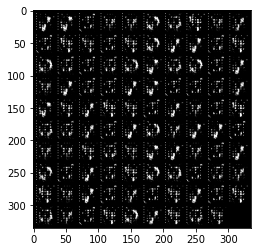

avg_is_score:	 4.0107813
std_is_score:	 0.78380644
Epoch: [41] [ 100/ 468] D_loss: 0.00246189, G_loss: 0.76514339
Epoch: [41] [ 200/ 468] D_loss: 0.00244011, G_loss: 0.76832771
Epoch: [41] [ 300/ 468] D_loss: 0.00194029, G_loss: 0.77682132
Epoch: [41] [ 400/ 468] D_loss: 0.00264211, G_loss: 0.76277804


<Figure size 72x720 with 0 Axes>

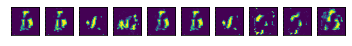

avg_is_score:	 4.558008
std_is_score:	 0.58762866
Epoch: [42] [ 100/ 468] D_loss: 0.00202146, G_loss: 0.79349542
Epoch: [42] [ 200/ 468] D_loss: 0.00154892, G_loss: 0.78882897
Epoch: [42] [ 300/ 468] D_loss: 0.00259708, G_loss: 0.78819764
Epoch: [42] [ 400/ 468] D_loss: 0.00177281, G_loss: 0.78462124


<Figure size 72x720 with 0 Axes>

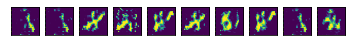

avg_is_score:	 3.9489353
std_is_score:	 0.68573797
Epoch: [43] [ 100/ 468] D_loss: 0.00204845, G_loss: 0.79220235
Epoch: [43] [ 200/ 468] D_loss: 0.00146568, G_loss: 0.79085588
Epoch: [43] [ 300/ 468] D_loss: 0.00160286, G_loss: 0.79324472
Epoch: [43] [ 400/ 468] D_loss: 0.00114827, G_loss: 0.79048842


<Figure size 72x720 with 0 Axes>

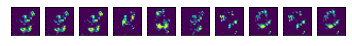

avg_is_score:	 3.7592692
std_is_score:	 0.48349616
Epoch: [44] [ 100/ 468] D_loss: 0.00156460, G_loss: 0.79182017
Epoch: [44] [ 200/ 468] D_loss: 0.00124236, G_loss: 0.78735340
Epoch: [44] [ 300/ 468] D_loss: 0.00107043, G_loss: 0.79372817
Epoch: [44] [ 400/ 468] D_loss: 0.00072155, G_loss: 0.79195178


<Figure size 72x720 with 0 Axes>

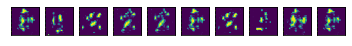

avg_is_score:	 4.09494
std_is_score:	 0.42233354
Epoch: [45] [ 100/ 468] D_loss: 0.00072382, G_loss: 0.79326463
Epoch: [45] [ 200/ 468] D_loss: 0.00113231, G_loss: 0.78479540
Epoch: [45] [ 300/ 468] D_loss: 0.00544886, G_loss: 0.78982294
Epoch: [45] [ 400/ 468] D_loss: 0.00165505, G_loss: 0.78761888


<Figure size 72x720 with 0 Axes>

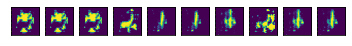

avg_is_score:	 4.14012
std_is_score:	 0.6025381
Epoch: [46] [ 100/ 468] D_loss: 0.00681259, G_loss: 0.78740299
Epoch: [46] [ 200/ 468] D_loss: 0.06572989, G_loss: 0.62957150
Epoch: [46] [ 300/ 468] D_loss: 0.17428389, G_loss: 0.55842036
Epoch: [46] [ 400/ 468] D_loss: 0.07423110, G_loss: 0.72105551


<Figure size 72x720 with 0 Axes>

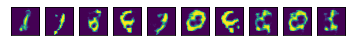

avg_is_score:	 4.62479
std_is_score:	 0.6665181
Epoch: [47] [ 100/ 468] D_loss: 0.07869249, G_loss: 0.56514752
Epoch: [47] [ 200/ 468] D_loss: 0.08192006, G_loss: 0.56088060
Epoch: [47] [ 300/ 468] D_loss: 0.08982647, G_loss: 0.59195006
Epoch: [47] [ 400/ 468] D_loss: 0.13194594, G_loss: 0.53168744


<Figure size 72x720 with 0 Axes>

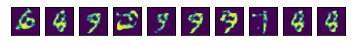

avg_is_score:	 4.8109007
std_is_score:	 0.4732177
Epoch: [48] [ 100/ 468] D_loss: 0.06343496, G_loss: 0.58533484
Epoch: [48] [ 200/ 468] D_loss: 0.05561836, G_loss: 0.57246947
Epoch: [48] [ 300/ 468] D_loss: 0.09237205, G_loss: 0.56910801
Epoch: [48] [ 400/ 468] D_loss: 0.07043879, G_loss: 0.57318413


<Figure size 72x720 with 0 Axes>

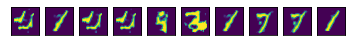

avg_is_score:	 4.947084
std_is_score:	 0.6926584
Epoch: [49] [ 100/ 468] D_loss: 0.07339043, G_loss: 0.55529928
Epoch: [49] [ 200/ 468] D_loss: 0.17154168, G_loss: 0.55390471
Epoch: [49] [ 300/ 468] D_loss: 0.08312967, G_loss: 0.58679682
Epoch: [49] [ 400/ 468] D_loss: 0.29030532, G_loss: 0.53955209


<Figure size 72x720 with 0 Axes>

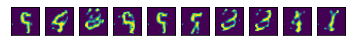

avg_is_score:	 4.986944
std_is_score:	 0.93232024
Epoch: [50] [ 100/ 468] D_loss: 0.13605362, G_loss: 0.54241884
Epoch: [50] [ 200/ 468] D_loss: 0.14702535, G_loss: 0.54255772
Epoch: [50] [ 300/ 468] D_loss: 0.12799735, G_loss: 0.48923331
Epoch: [50] [ 400/ 468] D_loss: 0.20449793, G_loss: 0.64059806


<Figure size 72x720 with 0 Axes>

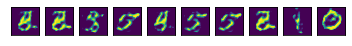

Generator Reconstruction Images


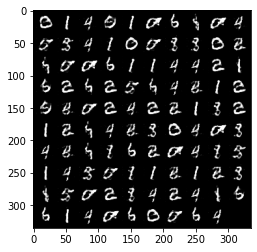

avg_is_score:	 5.5533614
std_is_score:	 0.9478509
Epoch: [51] [ 100/ 468] D_loss: 0.12931097, G_loss: 0.53361368
Epoch: [51] [ 200/ 468] D_loss: 0.09700070, G_loss: 0.54237616
Epoch: [51] [ 300/ 468] D_loss: 0.08284852, G_loss: 0.61620319
Epoch: [51] [ 400/ 468] D_loss: 0.12086929, G_loss: 0.56537890


<Figure size 72x720 with 0 Axes>

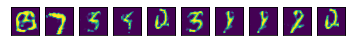

avg_is_score:	 4.9986024
std_is_score:	 0.740857
Epoch: [52] [ 100/ 468] D_loss: 0.06671757, G_loss: 0.61558080
Epoch: [52] [ 200/ 468] D_loss: 0.17360547, G_loss: 0.59817398
Epoch: [52] [ 300/ 468] D_loss: 0.17992367, G_loss: 0.51119852
Epoch: [52] [ 400/ 468] D_loss: 0.09292242, G_loss: 0.55946994


<Figure size 72x720 with 0 Axes>

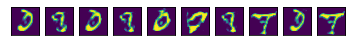

avg_is_score:	 4.702085
std_is_score:	 0.7732608
Epoch: [53] [ 100/ 468] D_loss: 0.03307961, G_loss: 0.67515290
Epoch: [53] [ 200/ 468] D_loss: 0.14443487, G_loss: 0.54998899
Epoch: [53] [ 300/ 468] D_loss: 0.09298086, G_loss: 0.61888218
Epoch: [53] [ 400/ 468] D_loss: 0.08016533, G_loss: 0.64213127


<Figure size 72x720 with 0 Axes>

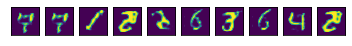

avg_is_score:	 4.2982016
std_is_score:	 0.5108084
Epoch: [54] [ 100/ 468] D_loss: 0.08264461, G_loss: 0.59302855
Epoch: [54] [ 200/ 468] D_loss: 0.16094527, G_loss: 0.54712921
Epoch: [54] [ 300/ 468] D_loss: 0.07650457, G_loss: 0.60256684
Epoch: [54] [ 400/ 468] D_loss: 0.10812235, G_loss: 0.65423942


<Figure size 72x720 with 0 Axes>

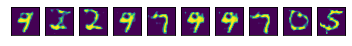

avg_is_score:	 5.722377
std_is_score:	 0.46365708
Epoch: [55] [ 100/ 468] D_loss: 0.21156962, G_loss: 0.52173364
Epoch: [55] [ 200/ 468] D_loss: 0.08725050, G_loss: 0.61401862
Epoch: [55] [ 300/ 468] D_loss: 0.17663014, G_loss: 0.59923321
Epoch: [55] [ 400/ 468] D_loss: 0.18277234, G_loss: 0.50613081


<Figure size 72x720 with 0 Axes>

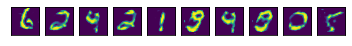

avg_is_score:	 4.867726
std_is_score:	 0.5902457
Epoch: [56] [ 100/ 468] D_loss: 0.12645620, G_loss: 0.51759726
Epoch: [56] [ 200/ 468] D_loss: 0.09968436, G_loss: 0.60076630
Epoch: [56] [ 300/ 468] D_loss: 0.08051331, G_loss: 0.60838091
Epoch: [56] [ 400/ 468] D_loss: 0.13142771, G_loss: 0.55374277


<Figure size 72x720 with 0 Axes>

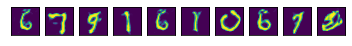

avg_is_score:	 4.316285
std_is_score:	 0.62493765
Epoch: [57] [ 100/ 468] D_loss: 0.02140855, G_loss: 0.65920097
Epoch: [57] [ 200/ 468] D_loss: 0.05289243, G_loss: 0.64021534
Epoch: [57] [ 300/ 468] D_loss: 0.17919272, G_loss: 0.71055210
Epoch: [57] [ 400/ 468] D_loss: 0.02560732, G_loss: 0.69788581


<Figure size 72x720 with 0 Axes>

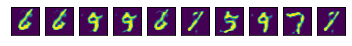

avg_is_score:	 5.2082114
std_is_score:	 0.63205624
Epoch: [58] [ 100/ 468] D_loss: 0.20095176, G_loss: 0.57471418
Epoch: [58] [ 200/ 468] D_loss: 0.09043847, G_loss: 0.54520655
Epoch: [58] [ 300/ 468] D_loss: 0.05035730, G_loss: 0.63337207
Epoch: [58] [ 400/ 468] D_loss: 0.04024215, G_loss: 0.65801406


<Figure size 72x720 with 0 Axes>

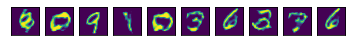

avg_is_score:	 5.2799263
std_is_score:	 0.58557284
Epoch: [59] [ 100/ 468] D_loss: 0.14908788, G_loss: 0.59608436
Epoch: [59] [ 200/ 468] D_loss: 0.05484567, G_loss: 0.70230341
Epoch: [59] [ 300/ 468] D_loss: 0.26011389, G_loss: 0.67467821
Epoch: [59] [ 400/ 468] D_loss: 0.10453941, G_loss: 0.62254870


<Figure size 72x720 with 0 Axes>

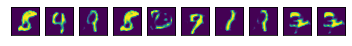

avg_is_score:	 5.4894323
std_is_score:	 0.7992077
Epoch: [60] [ 100/ 468] D_loss: 0.08215465, G_loss: 0.71849710
Epoch: [60] [ 200/ 468] D_loss: 0.07931459, G_loss: 0.58406937
Epoch: [60] [ 300/ 468] D_loss: 0.06249452, G_loss: 0.65320230
Epoch: [60] [ 400/ 468] D_loss: 0.05411702, G_loss: 0.68628097


<Figure size 72x720 with 0 Axes>

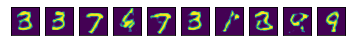

Generator Reconstruction Images


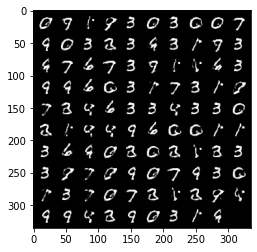

avg_is_score:	 5.0638437
std_is_score:	 0.54404
Epoch: [61] [ 100/ 468] D_loss: 0.02609507, G_loss: 0.70146370
Epoch: [61] [ 200/ 468] D_loss: 0.08291478, G_loss: 0.60869682
Epoch: [61] [ 300/ 468] D_loss: 0.03785314, G_loss: 0.68056047
Epoch: [61] [ 400/ 468] D_loss: 0.04612319, G_loss: 0.65432382


<Figure size 72x720 with 0 Axes>

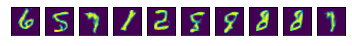

avg_is_score:	 4.9335732
std_is_score:	 0.7193666
Epoch: [62] [ 100/ 468] D_loss: 0.15700179, G_loss: 0.61266732
Epoch: [62] [ 200/ 468] D_loss: 0.06997085, G_loss: 0.75379467
Epoch: [62] [ 300/ 468] D_loss: 0.07833886, G_loss: 0.65460891
Epoch: [62] [ 400/ 468] D_loss: 0.19295219, G_loss: 0.59262407


<Figure size 72x720 with 0 Axes>

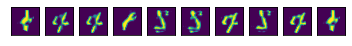

avg_is_score:	 6.039571
std_is_score:	 1.0825768
Epoch: [63] [ 100/ 468] D_loss: 0.09880054, G_loss: 0.69082367
Epoch: [63] [ 200/ 468] D_loss: 0.08718006, G_loss: 0.66948938
Epoch: [63] [ 300/ 468] D_loss: 0.09239971, G_loss: 0.71358812
Epoch: [63] [ 400/ 468] D_loss: 0.13590245, G_loss: 0.61392105


<Figure size 72x720 with 0 Axes>

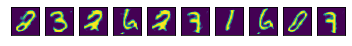

avg_is_score:	 5.1527567
std_is_score:	 0.7810148
Epoch: [64] [ 100/ 468] D_loss: 0.10338408, G_loss: 0.66897845
Epoch: [64] [ 200/ 468] D_loss: 0.03012677, G_loss: 0.70708269
Epoch: [64] [ 300/ 468] D_loss: 0.11942125, G_loss: 0.57050163
Epoch: [64] [ 400/ 468] D_loss: 0.13711743, G_loss: 0.63526261


<Figure size 72x720 with 0 Axes>

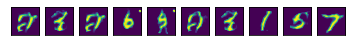

avg_is_score:	 5.362597
std_is_score:	 1.1773189
Epoch: [65] [ 100/ 468] D_loss: 0.07883783, G_loss: 0.60645694
Epoch: [65] [ 200/ 468] D_loss: 0.02679007, G_loss: 0.73654675
Epoch: [65] [ 300/ 468] D_loss: 0.19554795, G_loss: 0.71236652
Epoch: [65] [ 400/ 468] D_loss: 0.04712318, G_loss: 0.65951556


<Figure size 72x720 with 0 Axes>

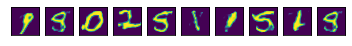

avg_is_score:	 5.3272386
std_is_score:	 0.7984493
Epoch: [66] [ 100/ 468] D_loss: 0.15732481, G_loss: 0.67156386
Epoch: [66] [ 200/ 468] D_loss: 0.00436928, G_loss: 0.80616748
Epoch: [66] [ 300/ 468] D_loss: 0.01020700, G_loss: 0.80300176
Epoch: [66] [ 400/ 468] D_loss: 0.00759287, G_loss: 0.80286777


<Figure size 72x720 with 0 Axes>

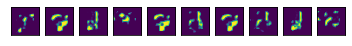

avg_is_score:	 4.3788667
std_is_score:	 0.8320674
Epoch: [67] [ 100/ 468] D_loss: 0.00428448, G_loss: 0.79712576
Epoch: [67] [ 200/ 468] D_loss: 0.00317255, G_loss: 0.80192709
Epoch: [67] [ 300/ 468] D_loss: 0.00403284, G_loss: 0.79612941
Epoch: [67] [ 400/ 468] D_loss: 0.00818244, G_loss: 0.80519247


<Figure size 72x720 with 0 Axes>

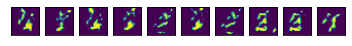

avg_is_score:	 4.5576987
std_is_score:	 0.3924983
Epoch: [68] [ 100/ 468] D_loss: 0.00366695, G_loss: 0.80272317
Epoch: [68] [ 200/ 468] D_loss: 0.05922402, G_loss: 0.72965175
Epoch: [68] [ 300/ 468] D_loss: 0.22618282, G_loss: 0.68648273
Epoch: [68] [ 400/ 468] D_loss: 0.04168739, G_loss: 0.65010649


<Figure size 72x720 with 0 Axes>

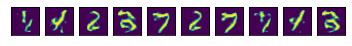

avg_is_score:	 5.715005
std_is_score:	 0.8694036
Epoch: [69] [ 100/ 468] D_loss: 0.11102778, G_loss: 0.79172218
Epoch: [69] [ 200/ 468] D_loss: 0.02203724, G_loss: 0.71028805
Epoch: [69] [ 300/ 468] D_loss: 0.11676192, G_loss: 0.65704858
Epoch: [69] [ 400/ 468] D_loss: 0.04360819, G_loss: 0.66686100


<Figure size 72x720 with 0 Axes>

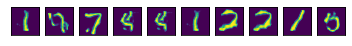

avg_is_score:	 4.843296
std_is_score:	 0.7268988
Epoch: [70] [ 100/ 468] D_loss: 0.19615841, G_loss: 0.59221613
Epoch: [70] [ 200/ 468] D_loss: 0.05274634, G_loss: 0.59823060
Epoch: [70] [ 300/ 468] D_loss: 0.09322124, G_loss: 0.63896877
Epoch: [70] [ 400/ 468] D_loss: 0.05675161, G_loss: 0.69858873


<Figure size 72x720 with 0 Axes>

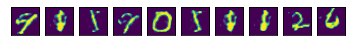

Generator Reconstruction Images


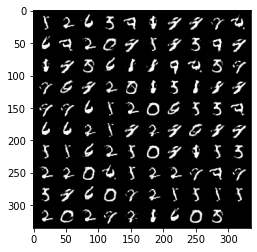

avg_is_score:	 5.2052054
std_is_score:	 0.7086972
Epoch: [71] [ 100/ 468] D_loss: 0.06114224, G_loss: 0.68947780
Epoch: [71] [ 200/ 468] D_loss: 0.07925324, G_loss: 0.61534417
Epoch: [71] [ 300/ 468] D_loss: 0.03637231, G_loss: 0.70064533
Epoch: [71] [ 400/ 468] D_loss: 0.06330950, G_loss: 0.43090203


<Figure size 72x720 with 0 Axes>

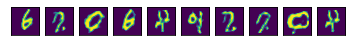

avg_is_score:	 4.7014613
std_is_score:	 0.64245796
Epoch: [72] [ 100/ 468] D_loss: 0.06995378, G_loss: 0.72373879
Epoch: [72] [ 200/ 468] D_loss: 0.02698242, G_loss: 0.69431210
Epoch: [72] [ 300/ 468] D_loss: 0.00414884, G_loss: 0.78559518
Epoch: [72] [ 400/ 468] D_loss: 0.01764489, G_loss: 0.71307278


<Figure size 72x720 with 0 Axes>

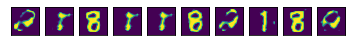

avg_is_score:	 4.820569
std_is_score:	 0.68363905
Epoch: [73] [ 100/ 468] D_loss: 0.23268591, G_loss: 0.60907364
Epoch: [73] [ 200/ 468] D_loss: 0.09080102, G_loss: 0.61961675
Epoch: [73] [ 300/ 468] D_loss: 0.05036182, G_loss: 0.65471733
Epoch: [73] [ 400/ 468] D_loss: 0.03340910, G_loss: 0.66828400


<Figure size 72x720 with 0 Axes>

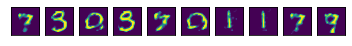

avg_is_score:	 5.86786
std_is_score:	 0.95511687
Epoch: [74] [ 100/ 468] D_loss: 0.02779641, G_loss: 0.71832597
Epoch: [74] [ 200/ 468] D_loss: 0.03724965, G_loss: 0.73483634
Epoch: [74] [ 300/ 468] D_loss: 0.05120730, G_loss: 0.65874135
Epoch: [74] [ 400/ 468] D_loss: 0.09073450, G_loss: 0.68020320


<Figure size 72x720 with 0 Axes>

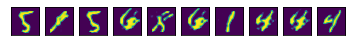

avg_is_score:	 4.374793
std_is_score:	 0.7462766
Epoch: [75] [ 100/ 468] D_loss: 0.07551948, G_loss: 0.64659989
Epoch: [75] [ 200/ 468] D_loss: 0.09439214, G_loss: 0.73744428
Epoch: [75] [ 300/ 468] D_loss: 0.04518718, G_loss: 0.72649419
Epoch: [75] [ 400/ 468] D_loss: 0.03027759, G_loss: 0.65483242


<Figure size 72x720 with 0 Axes>

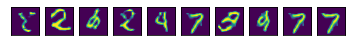

avg_is_score:	 5.580253
std_is_score:	 0.82352287
Epoch: [76] [ 100/ 468] D_loss: 0.52219421, G_loss: 0.70739263
Epoch: [76] [ 200/ 468] D_loss: 0.02756753, G_loss: 0.70137024
Epoch: [76] [ 300/ 468] D_loss: 0.09788497, G_loss: 0.62657344
Epoch: [76] [ 400/ 468] D_loss: 0.08734347, G_loss: 0.73846805


<Figure size 72x720 with 0 Axes>

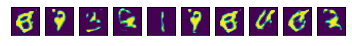

avg_is_score:	 5.361724
std_is_score:	 0.6372801
Epoch: [77] [ 100/ 468] D_loss: 0.12274874, G_loss: 0.71404898
Epoch: [77] [ 200/ 468] D_loss: 0.04910404, G_loss: 0.68090284
Epoch: [77] [ 300/ 468] D_loss: 0.06268105, G_loss: 0.74228728
Epoch: [77] [ 400/ 468] D_loss: 0.02722088, G_loss: 0.72219551


<Figure size 72x720 with 0 Axes>

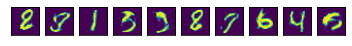

avg_is_score:	 4.9827843
std_is_score:	 0.8832623
Epoch: [78] [ 100/ 468] D_loss: 0.04170585, G_loss: 0.71382880
Epoch: [78] [ 200/ 468] D_loss: 0.05615863, G_loss: 0.60911667
Epoch: [78] [ 300/ 468] D_loss: 0.01611653, G_loss: 0.70691800
Epoch: [78] [ 400/ 468] D_loss: 0.03957339, G_loss: 0.74792147


<Figure size 72x720 with 0 Axes>

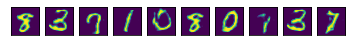

avg_is_score:	 4.970513
std_is_score:	 0.58836037
Epoch: [79] [ 100/ 468] D_loss: 0.00726652, G_loss: 0.80605257
Epoch: [79] [ 200/ 468] D_loss: 0.00700000, G_loss: 0.78601325
Epoch: [79] [ 300/ 468] D_loss: 0.00825817, G_loss: 0.79544103
Epoch: [79] [ 400/ 468] D_loss: 0.05915630, G_loss: 0.68847084


<Figure size 72x720 with 0 Axes>

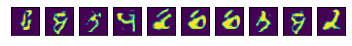

avg_is_score:	 5.0270033
std_is_score:	 0.7822443
Epoch: [80] [ 100/ 468] D_loss: 0.03558097, G_loss: 0.71464455
Epoch: [80] [ 200/ 468] D_loss: 0.01483912, G_loss: 0.75333291
Epoch: [80] [ 300/ 468] D_loss: 0.03156552, G_loss: 0.66662276
Epoch: [80] [ 400/ 468] D_loss: 0.02401643, G_loss: 0.74125624


<Figure size 72x720 with 0 Axes>

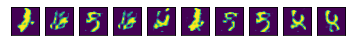

Generator Reconstruction Images


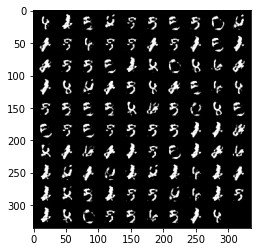

avg_is_score:	 4.6004047
std_is_score:	 0.71280193
Epoch: [81] [ 100/ 468] D_loss: 0.02021714, G_loss: 0.71051902
Epoch: [81] [ 200/ 468] D_loss: 0.02919576, G_loss: 0.69511127
Epoch: [81] [ 300/ 468] D_loss: 0.00575967, G_loss: 0.75390834
Epoch: [81] [ 400/ 468] D_loss: 0.00672415, G_loss: 0.75900573


<Figure size 72x720 with 0 Axes>

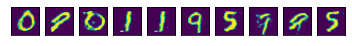

avg_is_score:	 5.095958
std_is_score:	 0.679648
Epoch: [82] [ 100/ 468] D_loss: 0.02618466, G_loss: 0.69616377
Epoch: [82] [ 200/ 468] D_loss: 0.00383435, G_loss: 0.80298436
Epoch: [82] [ 300/ 468] D_loss: 0.00542652, G_loss: 0.80000496
Epoch: [82] [ 400/ 468] D_loss: 0.00552094, G_loss: 0.80428255


<Figure size 72x720 with 0 Axes>

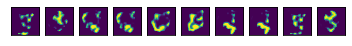

avg_is_score:	 4.057579
std_is_score:	 0.94183475
Epoch: [83] [ 100/ 468] D_loss: 0.00559194, G_loss: 0.79041028
Epoch: [83] [ 200/ 468] D_loss: 0.01589756, G_loss: 0.71628475
Epoch: [83] [ 300/ 468] D_loss: 0.04726388, G_loss: 0.69113302
Epoch: [83] [ 400/ 468] D_loss: 0.01784701, G_loss: 0.75407529


<Figure size 72x720 with 0 Axes>

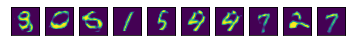

avg_is_score:	 5.5146556
std_is_score:	 0.6858816
Epoch: [84] [ 100/ 468] D_loss: 0.03343828, G_loss: 0.74748725
Epoch: [84] [ 200/ 468] D_loss: 0.10661209, G_loss: 0.71000302
Epoch: [84] [ 300/ 468] D_loss: 0.06239548, G_loss: 0.71266770
Epoch: [84] [ 400/ 468] D_loss: 0.01459423, G_loss: 0.75208354


<Figure size 72x720 with 0 Axes>

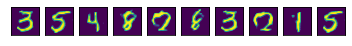

avg_is_score:	 5.7749286
std_is_score:	 1.0553553
Epoch: [85] [ 100/ 468] D_loss: 0.03180658, G_loss: 0.76813281
Epoch: [85] [ 200/ 468] D_loss: 0.02488964, G_loss: 0.73431122
Epoch: [85] [ 300/ 468] D_loss: 0.02080501, G_loss: 0.72076958
Epoch: [85] [ 400/ 468] D_loss: 0.03982282, G_loss: 0.71675688


<Figure size 72x720 with 0 Axes>

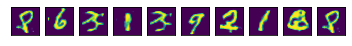

avg_is_score:	 5.350925
std_is_score:	 0.7481559
Epoch: [86] [ 100/ 468] D_loss: 0.01939351, G_loss: 0.73379821
Epoch: [86] [ 200/ 468] D_loss: 0.02538411, G_loss: 0.74894142
Epoch: [86] [ 300/ 468] D_loss: 0.02337606, G_loss: 0.69308186
Epoch: [86] [ 400/ 468] D_loss: 0.01729742, G_loss: 0.69551456


<Figure size 72x720 with 0 Axes>

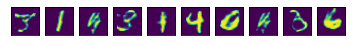

avg_is_score:	 4.7420535
std_is_score:	 0.94740736
Epoch: [87] [ 100/ 468] D_loss: 0.05487113, G_loss: 0.66384649
Epoch: [87] [ 200/ 468] D_loss: 0.02454137, G_loss: 0.72222573
Epoch: [87] [ 300/ 468] D_loss: 0.07232779, G_loss: 0.64313245
Epoch: [87] [ 400/ 468] D_loss: 0.01593709, G_loss: 0.71577281


<Figure size 72x720 with 0 Axes>

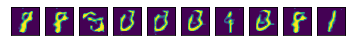

avg_is_score:	 4.865756
std_is_score:	 0.68596864
Epoch: [88] [ 100/ 468] D_loss: 0.03126455, G_loss: 0.76246005
Epoch: [88] [ 200/ 468] D_loss: 0.00796959, G_loss: 0.74268997
Epoch: [88] [ 300/ 468] D_loss: 0.00757385, G_loss: 0.77999043
Epoch: [88] [ 400/ 468] D_loss: 0.01943472, G_loss: 0.69647193


<Figure size 72x720 with 0 Axes>

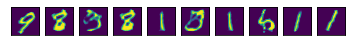

avg_is_score:	 5.8279448
std_is_score:	 1.1240782
Epoch: [89] [ 100/ 468] D_loss: 0.01389855, G_loss: 0.76189077
Epoch: [89] [ 200/ 468] D_loss: 0.02582110, G_loss: 0.72132027
Epoch: [89] [ 300/ 468] D_loss: 0.01157905, G_loss: 0.78147566
Epoch: [89] [ 400/ 468] D_loss: 0.04397873, G_loss: 0.77325916


<Figure size 72x720 with 0 Axes>

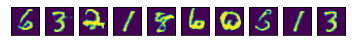

avg_is_score:	 5.8193946
std_is_score:	 0.8740318
Epoch: [90] [ 100/ 468] D_loss: 0.02531871, G_loss: 0.72923088
Epoch: [90] [ 200/ 468] D_loss: 0.01296848, G_loss: 0.72831047
Epoch: [90] [ 300/ 468] D_loss: 0.14893089, G_loss: 0.67610323
Epoch: [90] [ 400/ 468] D_loss: 0.00941774, G_loss: 0.75833237


<Figure size 72x720 with 0 Axes>

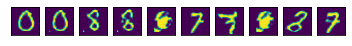

Generator Reconstruction Images


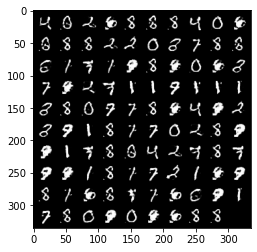

avg_is_score:	 5.404025
std_is_score:	 1.0688989
Epoch: [91] [ 100/ 468] D_loss: 0.02885832, G_loss: 0.70197147
Epoch: [91] [ 200/ 468] D_loss: 0.01316411, G_loss: 0.75522435
Epoch: [91] [ 300/ 468] D_loss: 0.01195622, G_loss: 0.74439859
Epoch: [91] [ 400/ 468] D_loss: 0.01948932, G_loss: 0.70426404


<Figure size 72x720 with 0 Axes>

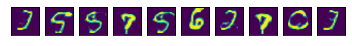

avg_is_score:	 5.567235
std_is_score:	 0.74233496
Epoch: [92] [ 100/ 468] D_loss: 0.02666986, G_loss: 0.76073980
Epoch: [92] [ 200/ 468] D_loss: 0.03742922, G_loss: 0.66742837
Epoch: [92] [ 300/ 468] D_loss: 0.03459843, G_loss: 0.73803300
Epoch: [92] [ 400/ 468] D_loss: 0.01805038, G_loss: 0.72786111


<Figure size 72x720 with 0 Axes>

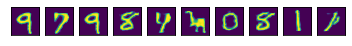

avg_is_score:	 5.2664285
std_is_score:	 0.5014805
Epoch: [93] [ 100/ 468] D_loss: 0.06337558, G_loss: 0.76628757
Epoch: [93] [ 200/ 468] D_loss: 0.03164523, G_loss: 0.71178377
Epoch: [93] [ 300/ 468] D_loss: 0.00659342, G_loss: 0.76155603
Epoch: [93] [ 400/ 468] D_loss: 0.09762898, G_loss: 0.62331593


<Figure size 72x720 with 0 Axes>

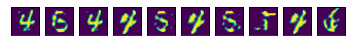

avg_is_score:	 5.235592
std_is_score:	 1.1649704
Epoch: [94] [ 100/ 468] D_loss: 0.00773003, G_loss: 0.80866599
Epoch: [94] [ 200/ 468] D_loss: 0.00479960, G_loss: 0.80964786
Epoch: [94] [ 300/ 468] D_loss: 0.00620125, G_loss: 0.80451500
Epoch: [94] [ 400/ 468] D_loss: 0.00472585, G_loss: 0.80884588


<Figure size 72x720 with 0 Axes>

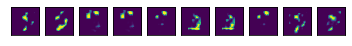

avg_is_score:	 4.8012404
std_is_score:	 0.85362536
Epoch: [95] [ 100/ 468] D_loss: 0.00287903, G_loss: 0.80659163
Epoch: [95] [ 200/ 468] D_loss: 0.00336194, G_loss: 0.80813336
Epoch: [95] [ 300/ 468] D_loss: 0.00362362, G_loss: 0.80777276
Epoch: [95] [ 400/ 468] D_loss: 0.00426825, G_loss: 0.80872846


<Figure size 72x720 with 0 Axes>

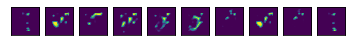

avg_is_score:	 4.5465665
std_is_score:	 0.64204776
Epoch: [96] [ 100/ 468] D_loss: 0.00295533, G_loss: 0.80723262
Epoch: [96] [ 200/ 468] D_loss: 0.00340625, G_loss: 0.80879802
Epoch: [96] [ 300/ 468] D_loss: 0.00475445, G_loss: 0.80921507
Epoch: [96] [ 400/ 468] D_loss: 0.00251542, G_loss: 0.80534208


<Figure size 72x720 with 0 Axes>

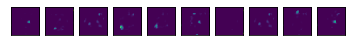

avg_is_score:	 1.0279586
std_is_score:	 0.016604407
Epoch: [97] [ 100/ 468] D_loss: 0.10530847, G_loss: 0.79598719
Epoch: [97] [ 200/ 468] D_loss: 0.01135850, G_loss: 0.79919636
Epoch: [97] [ 300/ 468] D_loss: 0.01285657, G_loss: 0.78747576
Epoch: [97] [ 400/ 468] D_loss: 0.04587962, G_loss: 0.61602020


<Figure size 72x720 with 0 Axes>

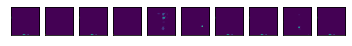

avg_is_score:	 2.0790799
std_is_score:	 0.1841774
Epoch: [98] [ 100/ 468] D_loss: 0.01015665, G_loss: 0.74768543
Epoch: [98] [ 200/ 468] D_loss: 0.00839752, G_loss: 0.80981743
Epoch: [98] [ 300/ 468] D_loss: 0.00886277, G_loss: 0.80980110
Epoch: [98] [ 400/ 468] D_loss: 0.01296773, G_loss: 0.80964923


<Figure size 72x720 with 0 Axes>

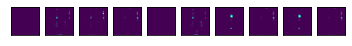

avg_is_score:	 1.8112285
std_is_score:	 0.32162455
Epoch: [99] [ 100/ 468] D_loss: 0.00733902, G_loss: 0.80892849
Epoch: [99] [ 200/ 468] D_loss: 0.00692239, G_loss: 0.80798388
Epoch: [99] [ 300/ 468] D_loss: 0.00736717, G_loss: 0.80666089
Epoch: [99] [ 400/ 468] D_loss: 0.00751776, G_loss: 0.80662113


<Figure size 72x720 with 0 Axes>

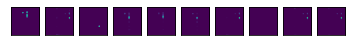

avg_is_score:	 1.6002861
std_is_score:	 0.26047748
Epoch: [100] [ 100/ 468] D_loss: 0.03040847, G_loss: 0.61872029
Epoch: [100] [ 200/ 468] D_loss: 0.00642199, G_loss: 0.80986583
Epoch: [100] [ 300/ 468] D_loss: 0.00598419, G_loss: 0.80982971
Epoch: [100] [ 400/ 468] D_loss: 0.00644018, G_loss: 0.80989909


<Figure size 72x720 with 0 Axes>

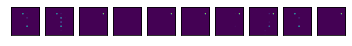

Generator Reconstruction Images


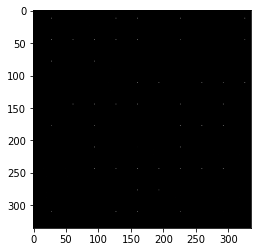

avg_is_score:	 2.0869331
std_is_score:	 0.22373676
Training finished!


In [ ]:
import time
print("1 LATENT DIMENION")
params = {'beta1': 0.05, 'beta2': 0.999,'lr_g':0.0002,'lr_d':0.0002,'max_epochs':100}
params['z_dim'] = 1
params['base_size'] = 128

gan = GAN(params)
gan.train()

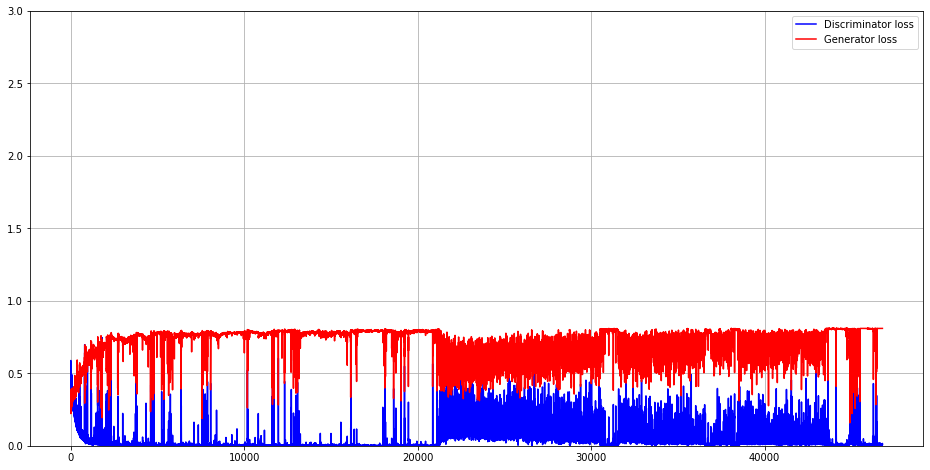

In [ ]:
plt.figure(figsize=(16,8))
s=plt.plot(gan.train_hist['D_loss'],c='b')
s=plt.plot(gan.train_hist['G_loss'],c='r')
s = plt.ylim((0,3))
s = plt.grid()
s=plt.legend(('Discriminator loss','Generator loss'))

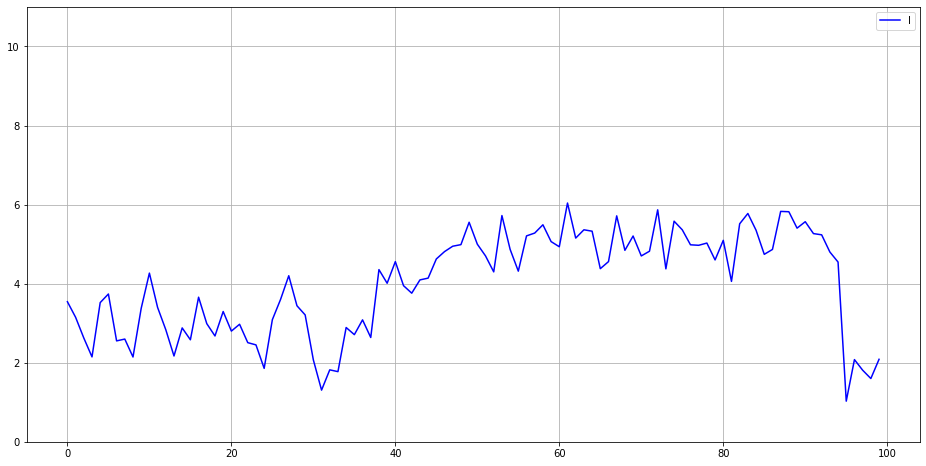

In [ ]:
plt.figure(figsize=(16,8))
s=plt.plot(gan.train_hist['IS_score'],c='b')
s = plt.ylim((0,11))
s = plt.grid()
s=plt.legend(('Inception Score'))